# Table des matières

### [Introduction](#I)

### [Importation du jeu de données](#T1)
- [Importation des librairies](#T1C1)
- [Importation du jeu de données](#T1C2)
- [Fonctions d'affichages](#T1C3)

### [Exploration du jeu de données](#T2)
- [Jeu de données](#T2C1)
- [Fusion + data engineering : LightGBM with Simple Features](#T2C2)
- [Feature selection (données manquantes, dupliquées, sans variance)](#T2C3)
- [Exploration des données](#T2C4)

### [Modélisations](#T3)
- [Pipeline](#T3C1)
- [DummyClassifier](#T3C2)
- [KNeighborsClassifier](#T3C3)
- [RandomForestClassifier](#T3C4)
- [LogisticRegression](#T3C5)
- [SGDClassifier](#T3C6)
- [GradientBoostingClassifier](#T3C7)
- [XGBClassifier](#T3C8)
- [LightGBM](#T3C9)


### [Conclusions générales](#C)

***
# <a name="I">Introduction</a>

Nous travaillons pour l'entreprise "Prêt à dépenser", qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt. 

L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit.

Prêt à dépenser décide donc qu'il faut qu'on développe un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 

***
# <a name="T1">Importation du jeu de données</a>

### <a name = "T1C1">a. Importation des librairies</a>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sklearn
import lightgbm
import xgboost
import imblearn
import shap
import random
import mlflow
import copy

from collections import Counter
from IPython.display import clear_output
from scipy import stats

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, fbeta_score

from imblearn.pipeline import Pipeline # sklearn ne prend pas en compte les méthodes de sampling
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

from mlflow.sklearn import log_model

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

libraries = {
    "Pandas" : pd,
    "Numpy" : np,
    "Scikit-Learn" : sklearn,
    "Xgboost" : xgboost,
    "LightGBM" : lightgbm,
    "Imblearn" : imblearn,
    "SHAP": shap,
    "mlflow": mlflow
}

# On affiche les différentes versions des librairies utilisées
for lib_name, lib in libraries.items():
    print(f"{lib_name} Version : {lib.__version__}")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Pandas Version : 1.5.3
Numpy Version : 1.23.5
Scikit-Learn Version : 1.2.2
Xgboost Version : 1.7.6
LightGBM Version : 4.0.0
Imblearn Version : 0.11.0
SHAP Version : 0.42.1
mlflow Version : 2.6.0


In [2]:
num_threads = os.cpu_count()
print("Nombre de threads :", num_threads)

os.environ["THREADPOOLCTL_THREAD_COUNT"] = "8"

Nombre de threads : 16


### <a name = "T1C2">b. Importation du jeu de données</a>

On réalise l'importation du jeu de données.

In [3]:
google_colab = False

#Pour une utilisation sur google colab
if google_colab:

    from google.colab import drive
    drive.mount('/content/drive')
    path_data = "/content/drive/My Drive/Projet 7/"

else :
    # On récupère le file path du notebook
    path_data = os.getcwd()

In [4]:
# On récupère la liste de fichiers dans le dossier
file_list = os.listdir(path_data)

# On filtre sur les fichiers csv
csv_files = [file for file in file_list if file.endswith('.csv')]

# Si l'opération de merge a déjà été réalisée, on ne la refait pas
if "concatenate_files.csv" in (csv_files):
    data = pd.read_csv("concatenate_files.csv")

***
# <a name="T2">Exploration du jeu de données</a>

### <a name = "T2C1">a. Jeux de données</a>

In [5]:
with pd.option_context('display.max_columns', None):
    for file in [files for files in csv_files if files != "concatenate_files.csv"]:
        
        print("Nom de fichier :", file)
        
        # On lit le fichier avec le décodeur classique UTF-8, sinon on tente latin1
        try:          
            df = pd.read_csv(file, sep = ',', encoding = "UTF-8")        
        
        except UnicodeDecodeError:
            
            print(f"UnicodeDecodeError: Erreur d'encodage, ne peut pas lire {csv_files} avec UTF-8.")
            
            try:
                df = pd.read_csv(file, sep = ',', encoding='latin1')
            
            except:
                print(f"UnicodeDecodeError: Erreur d'encodage, ne peut pas lire {csv_files} avec latin1.")
                print("Trouver un autre encodeur")
        
        # On affiche les données du fichier
        display(df)

Nom de fichier : application_test.csv


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0          100001         Cash loans           F            N               Y   
1          100005         Cash loans           M            N               Y   
2          100013         Cash loans           M            Y               Y   
3          100028         Cash loans           F            N               Y   
4          100038         Cash loans           M            Y               N   
...           ...                ...         ...          ...             ...   
48739      456221         Cash loans           F            N               Y   
48740      456222         Cash loans           F            N               N   
48741      456223         Cash loans           F            Y               Y   
48742      456224         Cash loans           M            N               N   
48743      456250         Cash loans           F            Y               N   

       CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                 0          135000.0    568800.0      20560.5   
1                 0           99000.0    222768.0      17370.0   
2                 0          202500.0    663264.0      69777.0   
3                 2          315000.0   1575000.0      49018.5   
4                 1          180000.0    625500.0      32067.0   
...             ...               ...         ...          ...   
48739             0          121500.0    412560.0      17473.5   
48740             2          157500.0    622413.0      31909.5   
48741             1          202500.0    315000.0      33205.5   
48742             0          225000.0    450000.0      25128.0   
48743             0          135000.0    312768.0      24709.5   

       AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
0             450000.0   Unaccompanied               Working   
1             180000.0   Unaccompanied               Working   
2             630000.0             NaN               Working   
3            1575000.0   Unaccompanied               Working   
4             625500.0   Unaccompanied               Working   
...                ...             ...                   ...   
48739         270000.0   Unaccompanied               Working   
48740         495000.0   Unaccompanied  Commercial associate   
48741         315000.0   Unaccompanied  Commercial associate   
48742         450000.0          Family  Commercial associate   
48743         270000.0   Unaccompanied               Working   

                 NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0                   Higher education            Married  House / apartment   
1      Secondary / secondary special            Married  House / apartment   
2                   Higher education            Married  House / apartment   
3      Secondary / secondary special            Married  House / apartment   
4      Secondary / secondary special            Married  House / apartment   
...                              ...                ...                ...   
48739  Secondary / secondary special              Widow  House / apartment   
48740  Secondary / secondary special            Married  House / apartment   
48741  Secondary / secondary special            Married  House / apartment   
48742               Higher education            Married  House / apartment   
48743  Secondary / secondary special            Married  House / apartment   

       REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0                        0.018850      -19241          -2329   
1                        0.035792      -18064          -4469   
2                        0.019101      -20038          -4458   
3                        0.026392      -13976          -1866   
4                        0.010032      -13040          -2191   
...                           ...         ...            ...   
48739                    0.002042      -19970          -5169   
48740                  

Nom de fichier : application_train.csv


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307506      456251       0         Cash loans           M            N   
307507      456252       0         Cash loans           F            N   
307508      456253       0         Cash loans           F            N   
307509      456254       1         Cash loans           F            N   
307510      456255       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                    Y             0          202500.0    406597.5   
1                    N             0          270000.0   1293502.5   
2                    Y             0           67500.0    135000.0   
3                    Y             0          135000.0    312682.5   
4                    Y             0          121500.0    513000.0   
...                ...           ...               ...         ...   
307506               N             0          157500.0    254700.0   
307507               Y             0           72000.0    269550.0   
307508               Y             0          153000.0    677664.0   
307509               Y             0          171000.0    370107.0   
307510               N             0          157500.0    675000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
0           24700.5         351000.0   Unaccompanied               Working   
1           35698.5        1129500.0          Family         State servant   
2            6750.0         135000.0   Unaccompanied               Working   
3           29686.5         297000.0   Unaccompanied               Working   
4           21865.5         513000.0   Unaccompanied               Working   
...             ...              ...             ...                   ...   
307506      27558.0         225000.0   Unaccompanied               Working   
307507      12001.5         225000.0   Unaccompanied             Pensioner   
307508      29979.0         585000.0   Unaccompanied               Working   
307509      20205.0         319500.0   Unaccompanied  Commercial associate   
307510      49117.5         675000.0   Unaccompanied  Commercial associate   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
0       Secondary / secondary special  Single / not married   
1                    Higher education               Married   
2       Secondary / secondary special  Single / not married   
3       Secondary / secondary special        Civil marriage   
4       Secondary / secondary special  Single / not married   
...                               ...                   ...   
307506  Secondary / secondary special             Separated   
307507  Secondary / secondary special                 Widow   
307508               Higher education             Separated   
307509  Secondary / secondary special               Married   
307510               Higher education               Married   

        NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0       House / apartment                    0.018801       -9461   
1       House / apartment                    0.003541      -16765   
2       House / apartment                    0.010032      -19046   
3       House / apartment                    0.008019      -19005   
4       House / apartment                    0.028663      -19932   
...                   ...                         ...         ...   
307506       With parents                    0.032561       -9327   
307507  House / apartment       

Nom de fichier : bureau.csv


SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0            215354       5714462        Closed      currency 1         -497   
1            215354       5714463        Active      currency 1         -208   
2            215354       5714464        Active      currency 1         -203   
3            215354       5714465        Active      currency 1         -203   
4            215354       5714466        Active      currency 1         -629   
...             ...           ...           ...             ...          ...   
1716423      259355       5057750        Active      currency 1          -44   
1716424      100044       5057754        Closed      currency 1        -2648   
1716425      100044       5057762        Closed      currency 1        -1809   
1716426      246829       5057770        Closed      currency 1        -1878   
1716427      246829       5057778        Closed      currency 1         -463   

         CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                         0               -153.0             -153.0   
1                         0               1075.0                NaN   
2                         0                528.0                NaN   
3                         0                  NaN                NaN   
4                         0               1197.0                NaN   
...                     ...                  ...                ...   
1716423                   0                -30.0                NaN   
1716424                   0              -2433.0            -2493.0   
1716425                   0              -1628.0             -970.0   
1716426                   0              -1513.0            -1513.0   
1716427                   0                  NaN             -387.0   

         AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                           NaN                   0        91323.00   
1                           NaN                   0       225000.00   
2                           NaN                   0       464323.50   
3                           NaN                   0        90000.00   
4                       77674.5                   0      2700000.00   
...                         ...                 ...             ...   
1716423                     0.0                   0        11250.00   
1716424                  5476.5                   0        38130.84   
1716425                     NaN                   0        15570.00   
1716426                     NaN                   0        36000.00   
1716427                     NaN                   0        22500.00   

         AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                        0.0                   NaN                     0.0   
1                   171342.0                   NaN                     0.0   
2                        NaN                   NaN                     0.0   
3                        NaN                   NaN                     0.0   
4                        NaN                   NaN                     0.0   
...                      ...                   ...                     ...   
1716423              11250.0                   0.0                     0.0   
1716424                  0.0                   0.0                     0.0   
1716425                  NaN                   NaN                     0.0   
1716426                  0.0                   0.0                     0.0   
1716427                  0.0                   NaN                     0.0   

             CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0        Consumer credit                -131          NaN  
1            Credit card                 -20          NaN  
2        Consumer credit                 -16          NaN  
3            Credit card                 -16          NaN  
4        Consumer credit                 -21          NaN  
...                  ...                 ... 

Nom de fichier : bureau_balance.csv


SK_ID_BUREAU  MONTHS_BALANCE STATUS
0              5715448               0      C
1              5715448              -1      C
2              5715448              -2      C
3              5715448              -3      C
4              5715448              -4      C
...                ...             ...    ...
27299920       5041336             -47      X
27299921       5041336             -48      X
27299922       5041336             -49      X
27299923       5041336             -50      X
27299924       5041336             -51      X

[27299925 rows x 3 columns]

Nom de fichier : credit_card_balance.csv


SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0           2562384      378907              -6       56.970   
1           2582071      363914              -1    63975.555   
2           1740877      371185              -7    31815.225   
3           1389973      337855              -4   236572.110   
4           1891521      126868              -1   453919.455   
...             ...         ...             ...          ...   
3840307     1036507      328243              -9        0.000   
3840308     1714892      347207              -9        0.000   
3840309     1302323      215757              -9   275784.975   
3840310     1624872      430337             -10        0.000   
3840311     2411345      236760             -10        0.000   

         AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  \
0                         135000                       0.0   
1                          45000                    2250.0   
2                         450000                       0.0   
3                         225000                    2250.0   
4                         450000                       0.0   
...                          ...                       ...   
3840307                    45000                       NaN   
3840308                    45000                       0.0   
3840309                   585000                  270000.0   
3840310                   450000                       NaN   
3840311                   157500                       0.0   

         AMT_DRAWINGS_CURRENT  AMT_DRAWINGS_OTHER_CURRENT  \
0                       877.5                         0.0   
1                      2250.0                         0.0   
2                         0.0                         0.0   
3                      2250.0                         0.0   
4                     11547.0                         0.0   
...                       ...                         ...   
3840307                   0.0                         NaN   
3840308                   0.0                         0.0   
3840309              270000.0                         0.0   
3840310                   0.0                         NaN   
3840311                   0.0                         0.0   

         AMT_DRAWINGS_POS_CURRENT  AMT_INST_MIN_REGULARITY  \
0                           877.5                 1700.325   
1                             0.0                 2250.000   
2                             0.0                 2250.000   
3                             0.0                11795.760   
4                         11547.0                22924.890   
...                           ...                      ...   
3840307                       NaN                    0.000   
3840308                       0.0                    0.000   
3840309                       0.0                 2250.000   
3840310                       NaN                    0.000   
3840311                       0.0                    0.000   

         AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0                    1800.00                   1800.000   
1                    2250.00                   2250.000   
2                    2250.00                   2250.000   
3                   11925.00                  11925.000   
4                   27000.00                  27000.000   
...                      ...                        ...   
3840307                  NaN                      0.000   
3840308              1879.11                      0.000   
3840309            375750.00                 356994.675   
3840310                  NaN                      0.000   
3840311                 0.00                      0.000   

         AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                           0.000          0.000                 0.000   
1                       60175.080      64875.555             64875.555   
2                       26926.425      31460.085             31460.085   
3           

Nom de fichier : HomeCredit_columns_description.csv
UnicodeDecodeError: Erreur d'encodage, ne peut pas lire ['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'concatenate_files.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv'] avec UTF-8.


Unnamed: 0                         Table                    Row  \
0             1  application_{train|test}.csv             SK_ID_CURR   
1             2  application_{train|test}.csv                 TARGET   
2             5  application_{train|test}.csv     NAME_CONTRACT_TYPE   
3             6  application_{train|test}.csv            CODE_GENDER   
4             7  application_{train|test}.csv           FLAG_OWN_CAR   
..          ...                           ...                    ...   
214         217     installments_payments.csv  NUM_INSTALMENT_NUMBER   
215         218     installments_payments.csv        DAYS_INSTALMENT   
216         219     installments_payments.csv     DAYS_ENTRY_PAYMENT   
217         220     installments_payments.csv         AMT_INSTALMENT   
218         221     installments_payments.csv            AMT_PAYMENT   

                                           Description  \
0                             ID of loan in our sample   
1    Target variable (1 - client with payment diffi...   
2          Identification if loan is cash or revolving   
3                                 Gender of the client   
4                        Flag if the client owns a car   
..                                                 ...   
214            On which installment we observe payment   
215  When the installment of previous credit was su...   
216  When was the installments of previous credit p...   
217  What was the prescribed installment amount of ...   
218  What the client actually paid on previous cred...   

                                   Special  
0                                      NaN  
1                                      NaN  
2                                      NaN  
3                                      NaN  
4                                      NaN  
..                                     ...  
214                                    NaN  
215  time only relative to the application  
216  time only relative to the application  
217                                    NaN  
218                                    NaN  

[219 rows x 5 columns]

Nom de fichier : installments_payments.csv


SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  \
0            1054186      161674                     1.0   
1            1330831      151639                     0.0   
2            2085231      193053                     2.0   
3            2452527      199697                     1.0   
4            2714724      167756                     1.0   
...              ...         ...                     ...   
13605396     2186857      428057                     0.0   
13605397     1310347      414406                     0.0   
13605398     1308766      402199                     0.0   
13605399     1062206      409297                     0.0   
13605400     2448869      434321                     1.0   

          NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  \
0                             6          -1180.0             -1187.0   
1                            34          -2156.0             -2156.0   
2                             1            -63.0               -63.0   
3                             3          -2418.0             -2426.0   
4                             2          -1383.0             -1366.0   
...                         ...              ...                 ...   
13605396                     66          -1624.0                 NaN   
13605397                     47          -1539.0                 NaN   
13605398                     43             -7.0                 NaN   
13605399                     43          -1986.0                 NaN   
13605400                     19            -27.0                 NaN   

          AMT_INSTALMENT  AMT_PAYMENT  
0               6948.360     6948.360  
1               1716.525     1716.525  
2              25425.000    25425.000  
3              24350.130    24350.130  
4               2165.040     2160.585  
...                  ...          ...  
13605396          67.500          NaN  
13605397          67.500          NaN  
13605398       43737.435          NaN  
13605399          67.500          NaN  
13605400       11504.250          NaN  

[13605401 rows x 8 columns]

Nom de fichier : POS_CASH_balance.csv


SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0            1803195      182943             -31            48.0   
1            1715348      367990             -33            36.0   
2            1784872      397406             -32            12.0   
3            1903291      269225             -35            48.0   
4            2341044      334279             -35            36.0   
...              ...         ...             ...             ...   
10001353     2448283      226558             -20             6.0   
10001354     1717234      141565             -19            12.0   
10001355     1283126      315695             -21            10.0   
10001356     1082516      450255             -22            12.0   
10001357     1259607      174278             -52            16.0   

          CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                          45.0               Active       0           0  
1                          35.0               Active       0           0  
2                           9.0               Active       0           0  
3                          42.0               Active       0           0  
4                          35.0               Active       0           0  
...                         ...                  ...     ...         ...  
10001353                    0.0               Active     843           0  
10001354                    0.0               Active     602           0  
10001355                    0.0               Active     609           0  
10001356                    0.0               Active     614           0  
10001357                    0.0            Completed       0           0  

[10001358 rows x 8 columns]

Nom de fichier : previous_application.csv


SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  \
0           2030495      271877     Consumer loans     1730.430   
1           2802425      108129         Cash loans    25188.615   
2           2523466      122040         Cash loans    15060.735   
3           2819243      176158         Cash loans    47041.335   
4           1784265      202054         Cash loans    31924.395   
...             ...         ...                ...          ...   
1670209     2300464      352015     Consumer loans    14704.290   
1670210     2357031      334635     Consumer loans     6622.020   
1670211     2659632      249544     Consumer loans    11520.855   
1670212     2785582      400317         Cash loans    18821.520   
1670213     2418762      261212         Cash loans    16431.300   

         AMT_APPLICATION  AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  \
0                17145.0     17145.0               0.0          17145.0   
1               607500.0    679671.0               NaN         607500.0   
2               112500.0    136444.5               NaN         112500.0   
3               450000.0    470790.0               NaN         450000.0   
4               337500.0    404055.0               NaN         337500.0   
...                  ...         ...               ...              ...   
1670209         267295.5    311400.0               0.0         267295.5   
1670210          87750.0     64291.5           29250.0          87750.0   
1670211         105237.0    102523.5           10525.5         105237.0   
1670212         180000.0    191880.0               NaN         180000.0   
1670213         360000.0    360000.0               NaN         360000.0   

        WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                         SATURDAY                       15   
1                         THURSDAY                       11   
2                          TUESDAY                       11   
3                           MONDAY                        7   
4                         THURSDAY                        9   
...                            ...                      ...   
1670209                  WEDNESDAY                       12   
1670210                    TUESDAY                       15   
1670211                     MONDAY                       12   
1670212                  WEDNESDAY                        9   
1670213                     SUNDAY                       10   

        FLAG_LAST_APPL_PER_CONTRACT  NFLAG_LAST_APPL_IN_DAY  \
0                                 Y                       1   
1                                 Y                       1   
2                                 Y                       1   
3                                 Y                       1   
4                                 Y                       1   
...                             ...                     ...   
1670209                           Y                       1   
1670210                           Y                       1   
1670211                           Y                       1   
1670212                           Y                       1   
1670213                           Y                       1   

         RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  RATE_INTEREST_PRIVILEGED  \
0                 0.000000               0.182832                  0.867336   
1                      NaN                    NaN                       NaN   
2                      NaN                    NaN                       NaN   
3                      NaN                    NaN                       NaN   
4                      NaN                    NaN                       NaN   
...                    ...                    ...                       ...   
1670209           0.000000                    NaN                       NaN   
1670210           0.340554                    NaN                       NaN   
1670211           0.101401                    NaN                       NaN   

Nom de fichier : sample_submission.csv


SK_ID_CURR  TARGET
0          100001     0.5
1          100005     0.5
2          100013     0.5
3          100028     0.5
4          100038     0.5
...           ...     ...
48739      456221     0.5
48740      456222     0.5
48741      456223     0.5
48742      456224     0.5
48743      456250     0.5

[48744 rows x 2 columns]

## Une explication des fichiers :
   
### application_{train|test}.csv

This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
Static data for all applications. One row represents one loan in our data sample.

### bureau.csv

All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

### bureau_balance.csv

Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

### POS_CASH_balance.csv

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

### credit_card_balance.csv

Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

### previous_application.csv

All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.

### installments_payments.csv

Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

### HomeCredit_columns_description.csv

This file contains descriptions for the columns in the various data files.

    application_test.csv et sample_submission.csv ne nous serviront pas, car ils sont là pour le kernel

    HomeCredit_columns_description.csv juste des description, donc ne servira pas.

### <a name = "T2C2">b. Fusion + data engineering : LightGBM with Simple Features</a>

Notre mission étant de développer un modèle efficace, on laisse la part de feature engineering à des personnes plus expérimentées dans le domaine. Pour cela, nous utilisons le kernel https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script comme source.

In [6]:
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).

# Pour limiter le nombre d'entrées, lors de test
DEBUG = 10000

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv 
def application_train(file = "application_train.csv", nan_as_category = False):
    # Read data and merge
    df = pd.read_csv(file, nrows = DEBUG)
    print("Samples: {}".format(len(df)))
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(file_bureau = "bureau.csv", file_bb = "bureau_balance.csv", nan_as_category = True):
    bureau = pd.read_csv(file_bureau, nrows = DEBUG)
    bb = pd.read_csv(file_bb, nrows = DEBUG)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    
    # Elimination des dataframes pour libérer de la mémoire
    del bb, bb_agg
    
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    
    # Elimination des dataframes pour libérer de la mémoire
    del active, active_agg
    
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')

    # Elimination des dataframes pour libérer de la mémoire
    del closed, closed_agg, bureau
    
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(file = "previous_application.csv", nan_as_category = True):
    prev = pd.read_csv(file, nrows = DEBUG)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    
    # Elimination des dataframes pour libérer de la mémoire
    del refused, refused_agg, approved, approved_agg, prev
    
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(file = "POS_CASH_balance.csv", nan_as_category = True):
    pos = pd.read_csv(file, nrows = DEBUG)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    
    # Elimination du dataframe pour libérer de la mémoire
    del pos
    
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(file = "installments_payments.csv", nan_as_category = True):
    ins = pd.read_csv(file, nrows = DEBUG)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    
    # Elimination du dataframe pour libérer de la mémoire
    del ins
    
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(file = "credit_card_balance.csv", nan_as_category = True):
    cc = pd.read_csv(file, nrows = DEBUG)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    # Elimination du dataframe pour libérer de la mémoire
    del cc
    
    return cc_agg  

In [7]:
# Fonction permettant de créer le fichier .csv

def creation_fichier_csv(df, nom_du_fichier):

    ## On identifie si le format CSV a été entré, sinon on l'ajout
    if ".csv" not in nom_du_fichier:
        nom_du_fichier = nom_du_fichier + ".csv"

    ## Le fichier est écrit au même endroit que le notebook
    ## Séparateur : virgule
    df.to_csv(nom_du_fichier, index = False, sep = ",")

In [8]:
def preparation_files():
    ##
    #    Fonction appelant les autres fonctions de préparation d'un fichier mergé
    ##
    
    df = application_train()
    print("Préparation des fichiers : bureau and bureau_balance")
    bureau = bureau_and_balance()
    print("Taille du fichier Bureau :", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau

    print("Préparation du fichier : previous_applications")
    prev = previous_applications()
    print("Taille du fichier Previous applications :", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev

    print("Préparation du fichier : POS-CASH balance")
    pos = pos_cash()
    print("Taille du fichier Pos-cash balance :", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos

    print("Préparation du fichier : installments payments")
    ins = installments_payments()
    print("Taille du fichier Installments payments :", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins

    print("Préparation du fichier : credit card balance")
    cc = credit_card_balance()
    print("Taille du fichier Credit card balance :", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc

    print("Création du fichier mergé")
    # On créé le fichier avec les données fusionnées
    creation_fichier_csv(df, "concatenate_files.csv")
    
    return df

In [9]:
# Si l'opération de merge n'a pas déjà été réalisée, on la réalise
if "concatenate_files.csv" not in (csv_files):
    print("Préparation du fichier...")
    data = preparation_files()

else:
    print("Fichier déjà généré")

Fichier déjà généré


In [614]:
data

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0         100002       1            0             0                0   
1         100003       0            1             0                1   
2         100004       0            0             1                0   
3         100006       0            1             0                0   
4         100007       0            0             0                0   
...          ...     ...          ...           ...              ...   
9995      111629       0            1             1                0   
9996      111630       0            1             1                0   
9997      111631       0            0             1                0   
9998      111632       0            1             0                1   
9999      111633       0            0             1                1   

      CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                0          202500.0    406597.5      24700.5   
1                0          270000.0   1293502.5      35698.5   
2                0           67500.0    135000.0       6750.0   
3                0          135000.0    312682.5      29686.5   
4                0          121500.0    513000.0      21865.5   
...            ...               ...         ...          ...   
9995             1          135000.0    270000.0      13500.0   
9996             0          166500.0   1006920.0      51543.0   
9997             0          225000.0    497520.0      53581.5   
9998             0          360000.0    348264.0      27643.5   
9999             0           94500.0    355536.0      18742.5   

      AMT_GOODS_PRICE  ...  WALLSMATERIAL_MODE_Panel  \
0            351000.0  ...                         0   
1           1129500.0  ...                         0   
2            135000.0  ...                         0   
3            297000.0  ...                         0   
4            513000.0  ...                         0   
...               ...  ...                       ...   
9995         270000.0  ...                         0   
9996         900000.0  ...                         0   
9997         450000.0  ...                         0   
9998         315000.0  ...                         0   
9999         270000.0  ...                         0   

      WALLSMATERIAL_MODE_Stone, brick  WALLSMATERIAL_MODE_Wooden  \
0                                   1                          0   
1                                   0                          0   
2                                   0                          0   
3                                   0                          0   
4                                   0                          0   
...                               ...                        ...   
9995                                1                          0   
9996                                0                          0   
9997                                0                          0   
9998                                0                          0   
9999                                0                          0   

      EMERGENCYSTATE_MODE_No  EMERGENCYSTATE_MODE_Yes  DAYS_EMPLOYED_PERC  \
0                          1                        0            0.067329   
1                          1                        0            0.070862   
2                          0                        0            0.011814   
3                          0                        0            0.159905   
4                          0                        0            0.152418   
...                      ...                      ...                 ...   
9995                       1                        0            0.235638   
9996                       0                        0            0.238410   
9997                       0                        0            0.088442   
9998                       0                        0            0.102390   
9999                   

La variable d'intérêt pour notre projet est "TARGET" : 
- 0 équivalent à un prêt qui a pu être remboursé
- 1 équivalent à un prêt qui n'a pas pu être remboursé

Nous obtenir un modèle permettant de minimiser le nombre de prêts attribués à des clients en incapacité de rembourser

### <a name = "T2C3">c. Feature selection (données manquantes, dupliquées, sans variance)</a>

Etant donné le grand nombre de features générées lors de la fusion des fichiers et du feature engineering, il y a nécessitée de réduire leur nombre.

Dans un premier temps, nous allons éliminer les colonnes où il y a un grand nombre de valeurs manquantes.

Puis nous éliminerons les variables qui n'ont aucune variance.

In [11]:
## Fonction permettant d'afficher le pourcentage de valeurs manquante par colonnes sous la forme d'un barplot

def valeurs_manquantes_graph(df, element, affichage = "Both"):

    #element : "row" ou "column"
    #Si element = row, on analyse le degré de complétude par ligne
    #Si element = column, on analyse le pourcentage de données manquantes par colonnes
    #affichage = "Tab", "Fig" ou "Both", pour l'affichage du tableau ou de la figure seulement, ou les deux


    if element == "column":
        # On créé une liste qui va accueillir le % de données manquantes par feature
        # On parcours les colonnes du dataframe et on calcule le pourcentage de valeurs manquantes
        donnees_manquantes = [[col, df[col].isnull().sum() / df.shape[0] * 100] for col in df.columns]

        #On transforme notre liste contenant les données manquantes en dataframe
        donnees_manquantes = pd.DataFrame(donnees_manquantes, columns = ['Features', 'Pourcentage manquant'])

        #on trie ensuite les données par le pourcentage de données manquantes
        donnees_manquantes.sort_values("Pourcentage manquant", ascending = False, inplace = True)

        if (affichage == "Tab") | (affichage == "Both"):

            display(donnees_manquantes[donnees_manquantes["Pourcentage manquant"] > 0])

        if (affichage == "Fig") | (affichage == "Both"):

            hauteur = df.columns.shape[0] / 4

            plt.figure(figsize=(12,hauteur))

            sns.barplot(data = donnees_manquantes, y = "Features", x = "Pourcentage manquant", color = "red", orient = "h")

            plt.title("Pourcentage de données manquantes par features, \nN = " + str(df.shape[0]) + ", P = " + str(len(df.columns)), fontsize = 20)
            plt.xlabel("Pourcentage de données manquantes (%)", fontsize=18)
            plt.ylabel("Features", fontsize=18)
            plt.xlim(0,100)
            plt.show()

    elif element == "row":
        # On compte pour chaque ligne le nombre de features pour lesquelles une valeur est entrée

        #Comptage du nombre de valeurs non NaN
        valeur_nonNaN = df.count(axis = 1)

        #Comptage du nombre de valeurs NaN
        valeur_NaN = valeur_nonNaN[valeur_nonNaN == 0]

        #Ensuite on calcul la proportion de complétude
        completude_donnees = valeur_nonNaN / len(df.columns) * 100

        print("Il y a %d lignes où nous ne retrouvons aucune valeur entrée" %valeur_NaN.shape[0])

        # On regarde la dispersion des données
        if (affichage == "Tab") | (affichage == "Both"):

            print("Statistiques sur la complétude des données :")
            display(completude_donnees.describe())

        # On affiche les résultats dans une figure
        if (affichage == "Fig") | (affichage == "Both"):

            plt.figure(figsize=(12,8))

            sns.histplot(data = completude_donnees, bins = len(df.columns))

            plt.title("Distribution du nombre de lignes \npar features remplies, N_features = " + str(len(df.columns)), fontsize = 20)
            plt.xlabel("Nombre de features remplies (%)", fontsize=18)
            plt.ylabel("Nombre de lignes, n = " + str(df.shape[0]), fontsize=18)
            plt.show()

    else :
        print("N'a pu rien afficher")
        print("La fonction prend en arguement /element/ qui ne prend comme valeurs /row/ ou /column/")


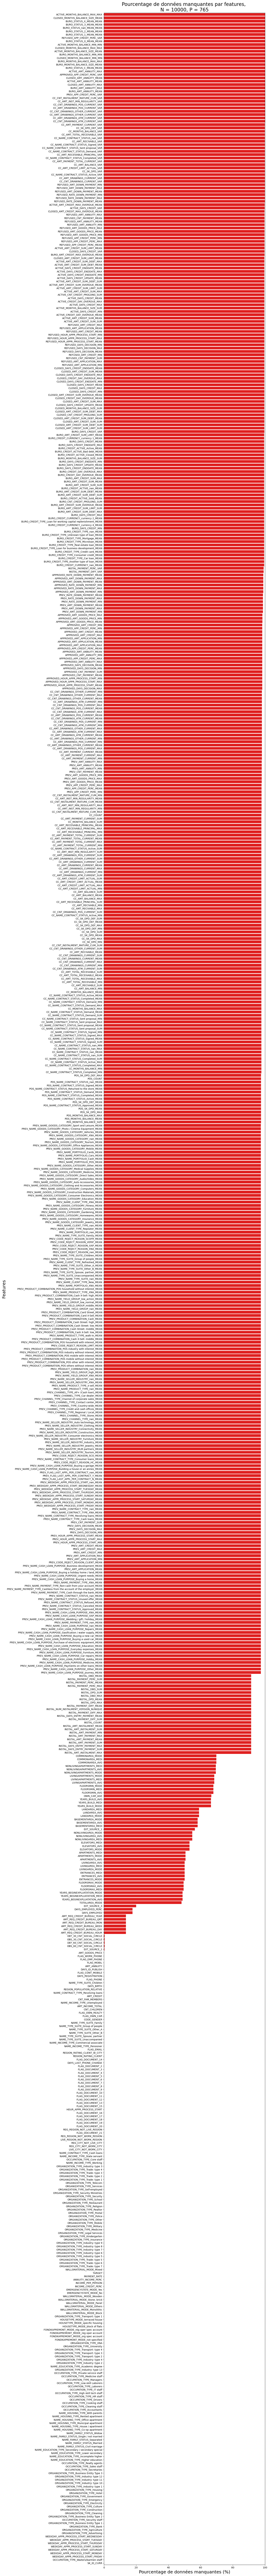

In [12]:
valeurs_manquantes_graph(data, "column", affichage = "Fig")

In [13]:
# On ne garde que les variables où on retrouve moins de 30 % de valeurs manquantes 

data = data.loc[:, data.apply(lambda x: (x.isnull().sum() / x.shape[0]) < 0.3)]

print(data.shape)

(10000, 198)


Nous avons drastiquement réduit le nombre de variables du jeu de données en utilisant un threshold de 0.3.

Nous pouvons maintenant éliminer les variables sans variance (qu'une valeur)

In [14]:
# On instancie un objet VarianceThreshold avec un threshold de 0 variance
sel = VarianceThreshold(threshold=0)

#On fit sur nos données
sel.fit(data)

VarianceThreshold(threshold=0)

In [15]:
zero_var = [x for x in data.columns if x not in data.columns[sel.get_support()]]

print("Il y a %d variables qui n'ont pas de variance" %len(zero_var))

Il y a 5 variables qui n'ont pas de variance


In [16]:
# On affiche le résultat
i = 0

while (i < 10) & (i < len(zero_var)) :
    print(data[zero_var[i]].value_counts()) #/ np.float(len(xtrain))
    
    i+=1

1    10000
Name: FLAG_MOBIL, dtype: int64
0    10000
Name: FLAG_DOCUMENT_2, dtype: int64
0    10000
Name: FLAG_DOCUMENT_7, dtype: int64
0    10000
Name: FLAG_DOCUMENT_10, dtype: int64
0    10000
Name: FLAG_DOCUMENT_12, dtype: int64


On enlève les variables sans variance

In [17]:
data = data.loc[:, ~data.columns.isin(zero_var)]

**Recherche de données dupliquées**

In [626]:
data[data.duplicated(keep="first")]

Empty DataFrame
Columns: [SK_ID_CURR, TARGET, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL, CNT_FAM_MEMBERS, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, HOUR_APPR_PROCESS_START, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, LIVE_REGION_NOT_WORK_REGION, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY, EXT_SOURCE_2, EXT_SOURCE_3, OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE, DAYS_LAST_PHONE_CHANGE, FLAG_DOCUMENT_3, FLAG_DOCUMENT_4, FLAG_DOCUMENT_5, FLAG_DOCUMENT_6, FLAG_DOCUMENT_8, FLAG_DOCUMENT_9, FLAG_DOCUMENT_11, FLAG_DOCUMENT_13, FLAG_DOCUMENT_14, FLAG_DOCUMENT_15, FLAG_DOCUMENT_16, FLAG_DOCUMENT_17, FLAG_DOCUMENT_18, FLAG_DOCUMENT_19, FLAG_DOCUMENT_20, FLAG_DOCUMENT_21, AMT_REQ_CREDIT_BUREAU_HOUR, AMT_REQ_CREDIT_BUREAU_DAY, AMT_REQ_CREDIT_BUREAU_WEEK, AMT_REQ_CREDIT_BUREAU_MON, AMT_REQ_CREDIT_BUREAU_QRT, AMT_REQ_CREDIT_BUREAU_YEAR, NAME_CONTRACT_TYPE_Cash loans, NAME_CONTRACT_TYPE_Revolving loans, NAME_TYPE_SUITE_Children, NAME_TYPE_SUITE_Family, NAME_TYPE_SUITE_Group of people, NAME_TYPE_SUITE_Other_A, NAME_TYPE_SUITE_Other_B, NAME_TYPE_SUITE_Spouse, partner, NAME_TYPE_SUITE_Unaccompanied, NAME_INCOME_TYPE_Commercial associate, NAME_INCOME_TYPE_Pensioner, NAME_INCOME_TYPE_State servant, NAME_INCOME_TYPE_Unemployed, NAME_INCOME_TYPE_Working, NAME_EDUCATION_TYPE_Academic degree, NAME_EDUCATION_TYPE_Higher education, NAME_EDUCATION_TYPE_Incomplete higher, NAME_EDUCATION_TYPE_Lower secondary, NAME_EDUCATION_TYPE_Secondary / secondary special, NAME_FAMILY_STATUS_Civil marriage, NAME_FAMILY_STATUS_Married, NAME_FAMILY_STATUS_Separated, NAME_FAMILY_STATUS_Single / not married, NAME_FAMILY_STATUS_Widow, NAME_HOUSING_TYPE_Co-op apartment, NAME_HOUSING_TYPE_House / apartment, NAME_HOUSING_TYPE_Municipal apartment, NAME_HOUSING_TYPE_Office apartment, NAME_HOUSING_TYPE_Rented apartment, NAME_HOUSING_TYPE_With parents, OCCUPATION_TYPE_Accountants, OCCUPATION_TYPE_Cleaning staff, OCCUPATION_TYPE_Cooking staff, OCCUPATION_TYPE_Core staff, OCCUPATION_TYPE_Drivers, OCCUPATION_TYPE_HR staff, OCCUPATION_TYPE_High skill tech staff, OCCUPATION_TYPE_IT staff, OCCUPATION_TYPE_Laborers, OCCUPATION_TYPE_Low-skill Laborers, OCCUPATION_TYPE_Managers, ...]
Index: []

[0 rows x 193 columns]

In [638]:
# On recherche si des clients similaires existes (pas le même numéro de client)
data[data.duplicated(subset=data.columns.drop(['SK_ID_CURR']), keep=False)]

Empty DataFrame
Columns: [SK_ID_CURR, TARGET, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL, CNT_FAM_MEMBERS, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, HOUR_APPR_PROCESS_START, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, LIVE_REGION_NOT_WORK_REGION, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY, EXT_SOURCE_2, EXT_SOURCE_3, OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE, DAYS_LAST_PHONE_CHANGE, FLAG_DOCUMENT_3, FLAG_DOCUMENT_4, FLAG_DOCUMENT_5, FLAG_DOCUMENT_6, FLAG_DOCUMENT_8, FLAG_DOCUMENT_9, FLAG_DOCUMENT_11, FLAG_DOCUMENT_13, FLAG_DOCUMENT_14, FLAG_DOCUMENT_15, FLAG_DOCUMENT_16, FLAG_DOCUMENT_17, FLAG_DOCUMENT_18, FLAG_DOCUMENT_19, FLAG_DOCUMENT_20, FLAG_DOCUMENT_21, AMT_REQ_CREDIT_BUREAU_HOUR, AMT_REQ_CREDIT_BUREAU_DAY, AMT_REQ_CREDIT_BUREAU_WEEK, AMT_REQ_CREDIT_BUREAU_MON, AMT_REQ_CREDIT_BUREAU_QRT, AMT_REQ_CREDIT_BUREAU_YEAR, NAME_CONTRACT_TYPE_Cash loans, NAME_CONTRACT_TYPE_Revolving loans, NAME_TYPE_SUITE_Children, NAME_TYPE_SUITE_Family, NAME_TYPE_SUITE_Group of people, NAME_TYPE_SUITE_Other_A, NAME_TYPE_SUITE_Other_B, NAME_TYPE_SUITE_Spouse, partner, NAME_TYPE_SUITE_Unaccompanied, NAME_INCOME_TYPE_Commercial associate, NAME_INCOME_TYPE_Pensioner, NAME_INCOME_TYPE_State servant, NAME_INCOME_TYPE_Unemployed, NAME_INCOME_TYPE_Working, NAME_EDUCATION_TYPE_Academic degree, NAME_EDUCATION_TYPE_Higher education, NAME_EDUCATION_TYPE_Incomplete higher, NAME_EDUCATION_TYPE_Lower secondary, NAME_EDUCATION_TYPE_Secondary / secondary special, NAME_FAMILY_STATUS_Civil marriage, NAME_FAMILY_STATUS_Married, NAME_FAMILY_STATUS_Separated, NAME_FAMILY_STATUS_Single / not married, NAME_FAMILY_STATUS_Widow, NAME_HOUSING_TYPE_Co-op apartment, NAME_HOUSING_TYPE_House / apartment, NAME_HOUSING_TYPE_Municipal apartment, NAME_HOUSING_TYPE_Office apartment, NAME_HOUSING_TYPE_Rented apartment, NAME_HOUSING_TYPE_With parents, OCCUPATION_TYPE_Accountants, OCCUPATION_TYPE_Cleaning staff, OCCUPATION_TYPE_Cooking staff, OCCUPATION_TYPE_Core staff, OCCUPATION_TYPE_Drivers, OCCUPATION_TYPE_HR staff, OCCUPATION_TYPE_High skill tech staff, OCCUPATION_TYPE_IT staff, OCCUPATION_TYPE_Laborers, OCCUPATION_TYPE_Low-skill Laborers, OCCUPATION_TYPE_Managers, ...]
Index: []

[0 rows x 193 columns]

Il n'y a pas de données dupliquées.

### <a name = "T2C4">d. Exploration des données</a>

In [672]:
bon_clients = data[data["TARGET"] == 0].shape[0]
mauvais_clients = data[data["TARGET"] == 1].shape[0]
rapport_bon_mauvais = mauvais_clients / (bon_clients + mauvais_clients)

print("Il y a %d bons clients et %d mauvais clients, il y a donc un rapport %.2f entre mauvais / total clients" 
      %(bon_clients, mauvais_clients, rapport_bon_mauvais))

Il y a 9225 bons clients et 775 mauvais clients, il y a donc un rapport 0.08 entre mauvais / total clients


Nous sommes en présence d'un jeu de données déséquilibré. Il sera important d'y penser lors de la modélisation.

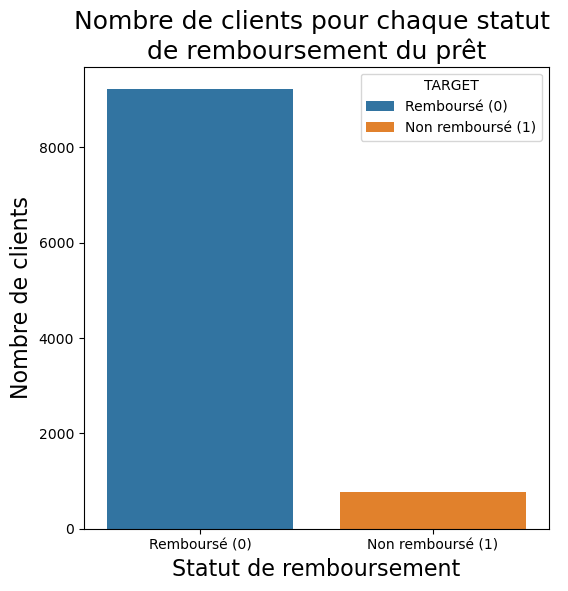

In [687]:
plt.figure(figsize=(6,6))
sns.countplot(data, x = "TARGET", hue = "TARGET", dodge=False)
plt.title("Nombre de clients pour chaque statut \nde remboursement du prêt", fontsize = 18)
plt.ylabel("Nombre de clients", fontsize = 16)
plt.xlabel("Statut de remboursement", fontsize = 16)
plt.legend(title="TARGET", labels=["Remboursé (0)", "Non remboursé (1)"])  # Add a legend
plt.xticks(ticks=[0, 1], labels=["Remboursé (0)", "Non remboursé (1)"])  # Set x-axis tick labels
plt.show()

On peut analyser s'il existe une structuration des données avec TSNE

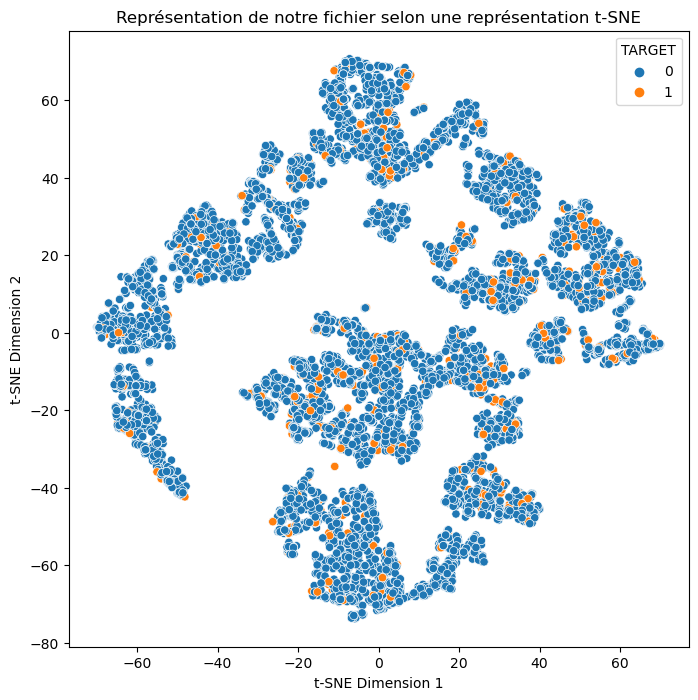

In [659]:
def plot_tsne(X_tsne):
    labels = data["TARGET"]

    plt.figure(figsize=(8, 8))

    # Réduction minimaliste de la représentation
    sns.scatterplot(x = X_tsne[:, 0], y = X_tsne[:, 1], hue=labels)

    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title(f'Représentation de notre fichier selon une représentation t-SNE')

    plt.show()


imputer = SimpleImputer(strategy='median')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

tsne = TSNE(n_components=2,
            random_state=42,
            init = "random",
            perplexity = 70,
            learning_rate = 200, # Choix dû à des tests préliminaires
            n_iter = 1000) # Choix dû à des tests préliminaires

# On applique sur nos données
X_tsne = tsne.fit_transform(data_imputed.drop(["TARGET", "SK_ID_CURR"], axis=1))
    
plot_tsne(X_tsne)


On observe aucune structuration nette des données.

On peut ensuite analyser la distribution de certaines variables par rapport à la Target.

On ne va en choisir que quelques unes qui peuvent nous intéresser, mais qui ne sont pas forcément les plus intéressantes pour les modèles. Cela nous permet d'avoir une vue d'ensemble des clients.

La variable DAYS_BIRTH nous donne accès à l'age du client.

In [662]:
data.DAYS_BIRTH.describe()

count    10000.000000
mean    -16025.273100
std       4340.528828
min     -25160.000000
25%     -19595.250000
50%     -15783.500000
75%     -12388.750000
max      -7705.000000
Name: DAYS_BIRTH, dtype: float64

Nous n'aimons pas comment cette variable est distribuée, on va la remplacer par une autre, avec les années.

In [664]:
# On met en positif, puis on divise par 365 pour avoir le nombre d'années
data["ANNEES_AGE"] = (abs(data.DAYS_BIRTH) / 365)

# On élimine l'ancienne variable
data.drop("DAYS_BIRTH", axis = 1, inplace = True)

In [665]:
data["ANNEES_AGE"].describe()

count    10000.000000
mean        43.904858
std         11.891860
min         21.109589
25%         33.941781
50%         43.242466
75%         53.685616
max         68.931507
Name: ANNEES_AGE, dtype: float64

In [666]:
def graphBoxplot(df, x, y, xlabel, figsize = (10,10), **kwargs):
    plt.figure(figsize = figsize)
    
    # On trie pour l'affichage du comptage
    sns.boxplot(data = df.sort_values(x), x = x, y = y, **kwargs)    

    # On compte le nombre de bâtiment par type de x
    # Pour ensuite afficher le compte
    label_count = [str(unique) + ", n = " + str(df[df[x] == unique].shape[0]) 
                   for unique in np.sort(df[x].unique())]
    
    plt.xticks(np.arange(len(df[x].unique())), label_count, rotation=45, ha='right')     
    
    plt.title(str(y) + " par rapport à\n" + str(xlabel) , fontsize = 20)
    plt.xlabel(xlabel.capitalize(), fontsize=18)
    plt.ylabel(y, fontsize=18)
    
    plt.show()

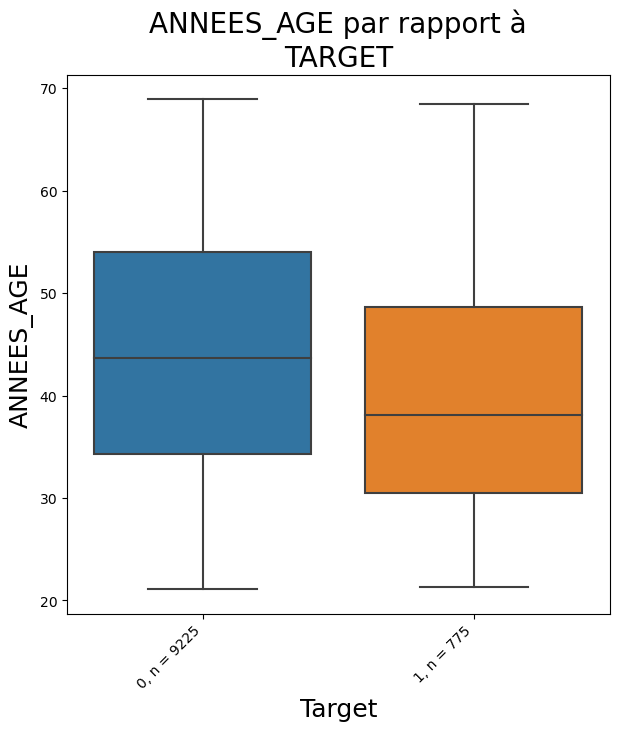

In [671]:
graphBoxplot(data, "TARGET", "ANNEES_AGE", "TARGET", (7,7))

Valeur de skewness : 0.11


<Axes: xlabel='ANNEES_AGE', ylabel='Count'>

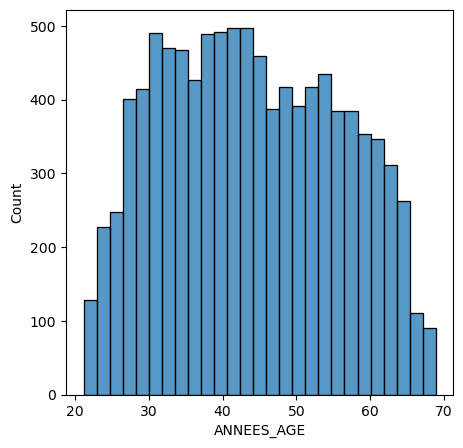

In [702]:
print("Valeur de skewness : %.2f" %data["ANNEES_AGE"].skew())
plt.figure(figsize = (5,5))
sns.histplot(data["ANNEES_AGE"])

On pourrait aller plus loin dans notre test de normalité, mais cela suffira étant donné le nombre de données.

In [736]:
def test_stat(df, var):
    bon_clients = df.loc[df["TARGET"] == 0, var]
    mauvais_clients = df.loc[df["TARGET"] == 1, var]

    print("Variable testée : ", var)
    # On réalise un t-test
    t_statistic, p_value = stats.ttest_ind(bon_clients, mauvais_clients)

    # On prend un alpa = 0.05
    alpha = 0.05  

    print("p_value : %.5f" %p_value)

    # On test s'il y a une différence significative ou non entre les 2 groupes
    if p_value < alpha:
        print("La moyenne des deux groupes est statistiquement différente.")
    else:
        print("La moyenne des deux groupes n'est pas statistiquement différente.")

In [726]:
test_stat(data, "ANNEES_AGE")

Variable testée :  ANNEES_AGE
p_value : 0.00000
La moyenne des deux groupes est statistiquement différente.


Donc l'age de l'emprunteur semble influencer sur la capacité à rembourser son prêt. Etre en moyenne plus jeune n'est pas un bon signe.

La variable DAYS_EMPLOYED_PERC nous donne accès au pourcentage de jour que le client avait un travail.

In [715]:
data.DAYS_EMPLOYED_PERC.describe()

count    8226.000000
mean        0.157450
std         0.134906
min         0.000917
25%         0.056476
50%         0.118779
75%         0.219061
max         0.695770
Name: DAYS_EMPLOYED_PERC, dtype: float64

In [716]:
# On va mettre en pourcentage
data.DAYS_EMPLOYED_PERC = data.DAYS_EMPLOYED_PERC*100

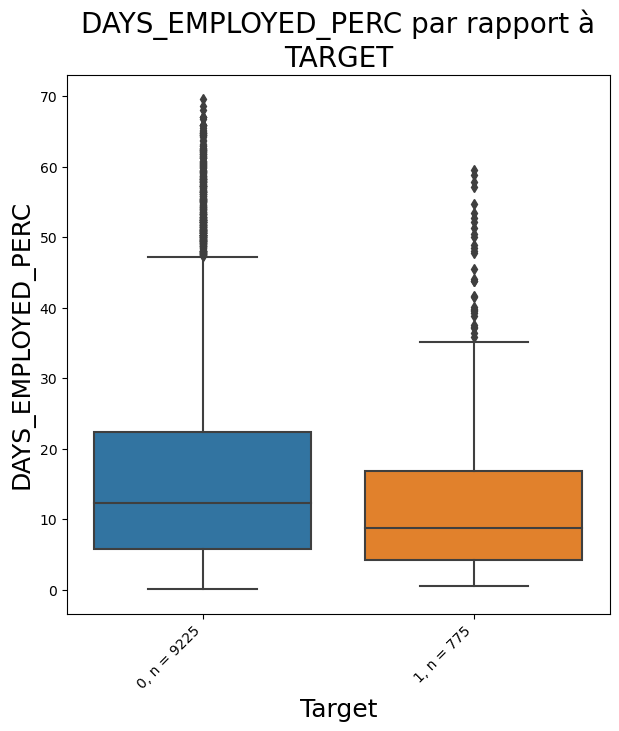

In [717]:
graphBoxplot(data, "TARGET", "DAYS_EMPLOYED_PERC", "TARGET", (7,7))

Valeur de skewness : 1.34


<Axes: xlabel='DAYS_EMPLOYED_PERC', ylabel='Count'>

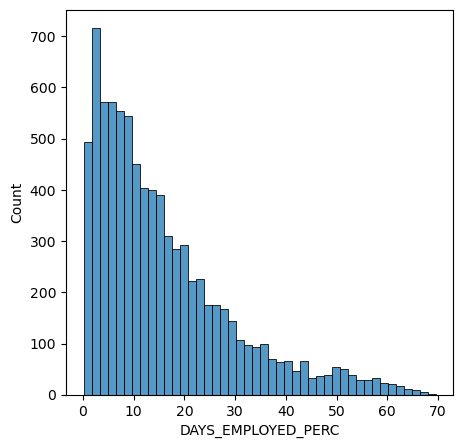

In [718]:
print("Valeur de skewness : %.2f" %data["DAYS_EMPLOYED_PERC"].skew())
plt.figure(figsize = (5,5))
sns.histplot(data["DAYS_EMPLOYED_PERC"])

On regarde si on peut améliorer ce score tout de même.

Valeur de skewness : -0.28


<Axes: xlabel='DAYS_EMPLOYED_PERC', ylabel='Count'>

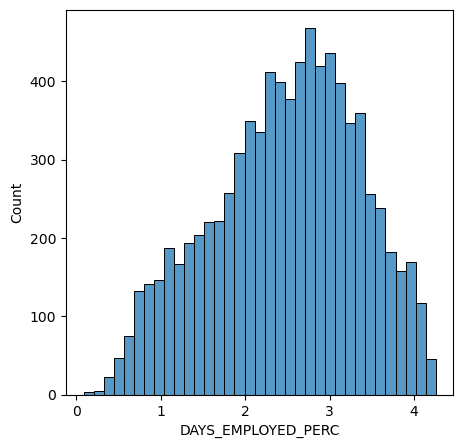

In [724]:
print("Valeur de skewness : %.2f" %np.log1p(data["DAYS_EMPLOYED_PERC"]).skew())
plt.figure(figsize = (5,5))
sns.histplot(np.log1p(data["DAYS_EMPLOYED_PERC"]))

In [738]:
# On ne sélectionne que les données où il n'y a pas de valeurs manquantes
mask = copy.deepcopy(data[data.DAYS_EMPLOYED_PERC.notnull()])

mask.DAYS_EMPLOYED_PERC = np.log1p(mask["DAYS_EMPLOYED_PERC"])

test_stat(mask, "DAYS_EMPLOYED_PERC")

Variable testée :  DAYS_EMPLOYED_PERC
p_value : 0.00000
La moyenne des deux groupes est statistiquement différente.


Donc le pourcentage passé de sa vie à travailler de l'emprunteur influence sur la capacité à rembourser son prêt. Etre en moyenne plus employé contribue à un meilleur taux de remboursement.

La variable CNT_CHILDREN nous donne accès au nombre d'enfants que le client possède.

In [746]:
data.CNT_CHILDREN.describe()

count    10000.000000
mean         0.416300
std          0.722251
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          7.000000
Name: CNT_CHILDREN, dtype: float64

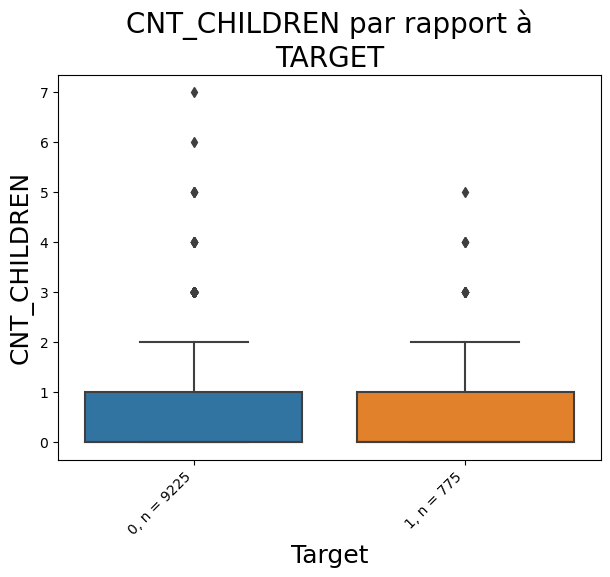

In [750]:
graphBoxplot(data, "TARGET", "CNT_CHILDREN", "TARGET", (7,5))

Graphiquement on observe pas de différence entre les deux groupes.

In [754]:
data.loc[data.TARGET == 0, "CNT_CHILDREN"].describe()

count    9225.000000
mean        0.408780
std         0.716057
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         7.000000
Name: CNT_CHILDREN, dtype: float64

In [755]:
data.loc[data.TARGET == 1, "CNT_CHILDREN"].describe()

count    775.000000
mean       0.505806
std        0.787273
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        5.000000
Name: CNT_CHILDREN, dtype: float64

On observe quand même des moyennes différentes

In [752]:
mask = copy.deepcopy(data[data.CNT_CHILDREN.notnull()])

mask.CNT_CHILDREN = np.log1p(mask["CNT_CHILDREN"])

test_stat(mask, "CNT_CHILDREN")

Variable testée :  CNT_CHILDREN
p_value : 0.00029
La moyenne des deux groupes est statistiquement différente.


Il semblerait donc qu'avoir au moins 1 enfant réduit sa capacité à rembourser son crédit.

La variable FLAG_OWN_CAR nous donne accès si le client possède une voiture ou non.

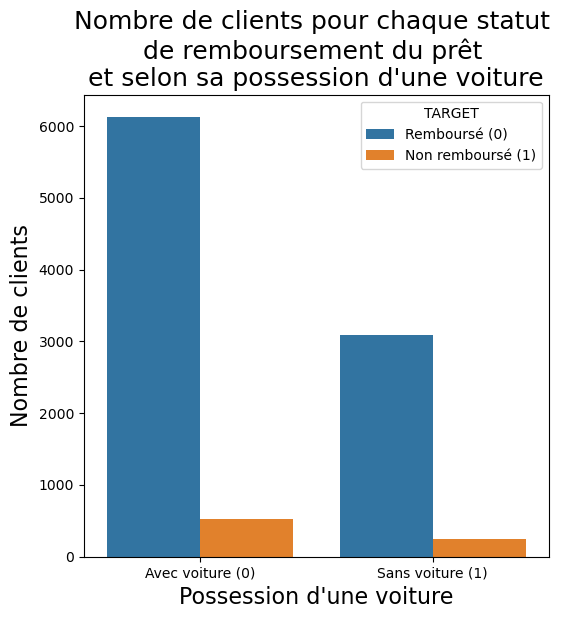

In [772]:
plt.figure(figsize=(6,6))
sns.countplot(data, x = "FLAG_OWN_CAR", hue = "TARGET")
plt.title("Nombre de clients pour chaque statut \nde remboursement du prêt \net selon sa possession d'une voiture", fontsize = 18)
plt.ylabel("Nombre de clients", fontsize = 16)
plt.xlabel("Possession d'une voiture", fontsize = 16)
plt.legend(title="TARGET", labels=["Remboursé (0)", "Non remboursé (1)"])  
plt.xticks(ticks=[0, 1], labels=["Avec voiture (0)", "Sans voiture (1)"])  
plt.show()

In [789]:
def chi_test_stat(df, var):
    
    print("Variable testée : ", var)
    
    # on crée une tableau de contingence
    table_contingence = pd.crosstab(data[var], df["TARGET"])
    
    # On réalise le test chi2
    chi2_stat, p_value, dof, expected = stats.chi2_contingency(table_contingence)

    # On prend un alpa = 0.05
    alpha = 0.05  

    print("p_value : %.5f" %p_value)

    # On test s'il y a une différence significative ou non entre les 2 groupes
    if p_value < alpha:
        print("Il y a une association significative entre %s et la variable TARGET." %var)
    else:
        print("Il n'y a pas d'association significative entre %s et la variable TARGET." %var)

In [800]:
chi_test_stat(data, "FLAG_OWN_CAR")

Variable testée :  FLAG_OWN_CAR
p_value : 0.22817
Il n'y a pas d'association significative entre FLAG_OWN_CAR et la variable TARGET.


Le fait de possèder une voiture ou non ne contribue pas à la capacité de rembourser un prêt. 

On peut regarder si le faite de possèder une maison ou non, avec la variable FLAG_OWN_REALTY, permet de prévoir si le client est en capacité de rembourser ou non son crédit.

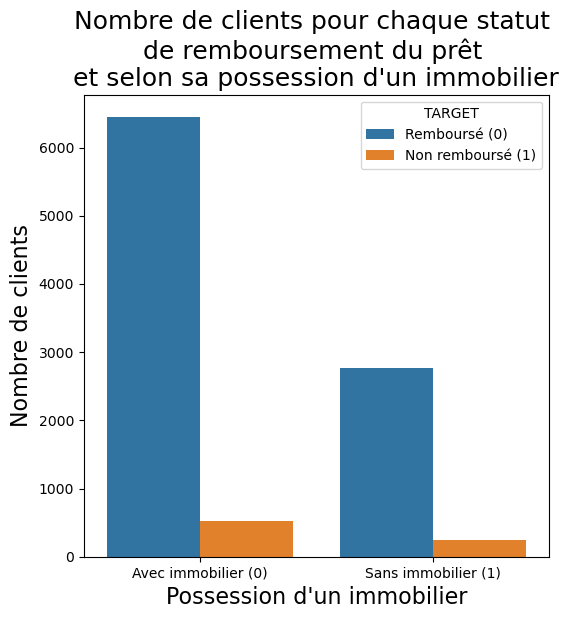

In [771]:
plt.figure(figsize=(6,6))
sns.countplot(data, x = "FLAG_OWN_REALTY", hue = "TARGET")
plt.title("Nombre de clients pour chaque statut \nde remboursement du prêt \net selon sa possession d'un immobilier", fontsize = 18)
plt.ylabel("Nombre de clients", fontsize = 16)
plt.xlabel("Possession d'un immobilier", fontsize = 16)
plt.legend(title="TARGET", labels=["Remboursé (0)", "Non remboursé (1)"])  # Add a legend
plt.xticks(ticks=[0, 1], labels=["Avec immobilier (0)", "Sans immobilier (1)"])  # Set x-axis tick labels
plt.show()

In [799]:
chi_test_stat(data, "FLAG_OWN_REALTY")

Variable testée :  FLAG_OWN_REALTY
p_value : 0.16476
Il n'y a pas d'association significative entre FLAG_OWN_REALTY et la variable TARGET.


Le fait de possèder de l'immobilier ou non ne contribue pas à la capacité de rembourser un prêt.

La variable CODE_GENDER nous donne accès au genre du client.

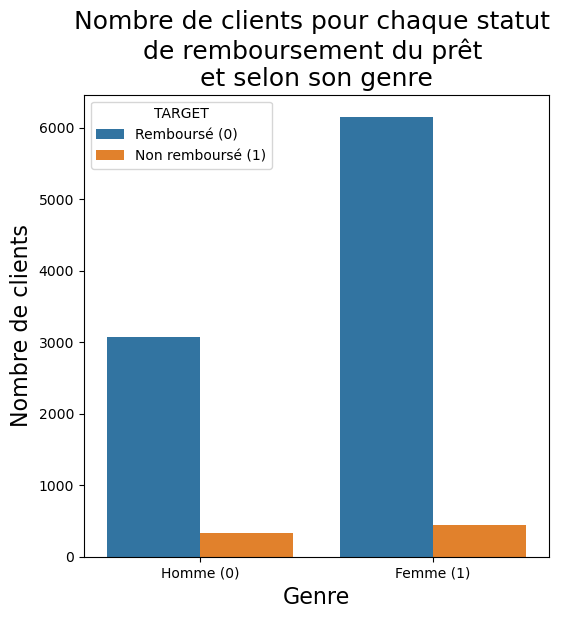

In [806]:
plt.figure(figsize=(6,6))
sns.countplot(data, x = "CODE_GENDER", hue = "TARGET")
plt.title("Nombre de clients pour chaque statut \nde remboursement du prêt \net selon son genre", fontsize = 18)
plt.ylabel("Nombre de clients", fontsize = 16)
plt.xlabel("Genre", fontsize = 16)
plt.legend(title="TARGET", labels=["Remboursé (0)", "Non remboursé (1)"])
plt.xticks(ticks=[0, 1], labels=["Homme (0)", "Femme (1)"]) 
plt.show()

In [798]:
chi_test_stat(data, "CODE_GENDER")

Variable testée :  CODE_GENDER
p_value : 0.00000
Il y a une association significative entre CODE_GENDER et la variable TARGET.


Le genre du client est associé significativement à sa capacité à rembourser

In [808]:
total_homme = data[data.CODE_GENDER == 0]
total_femme = data[data.CODE_GENDER == 1]
total = total_homme + total_femme

bon_client_homme_pourc = total_homme[total_homme.TARGET == 0].shape[0] / total_homme.shape[0] * 100
mauvais_client_homme_pourc = 100 - bon_client_homme_pourc

bon_client_femme_pourc = total_femme[total_femme.TARGET == 0].shape[0] / total_femme.shape[0] * 100
mauvais_client_femme_pourc = 100 - bon_client_femme_pourc

print("Pourcentage de clients hommes ayant remboursés un crédit %.0f %% contre les mauvais %.0f %%" 
      %(bon_client_homme_pourc, mauvais_client_homme_pourc))

print("Pourcentage de clientes femmes ayant remboursées un crédit %.0f %% contre les mauvaises %.0f %%" 
      %(bon_client_femme_pourc, mauvais_client_femme_pourc))

Pourcentage de clients hommes ayant remboursés un crédit 90 % contre les mauvais 10 %
Pourcentage de clientes femmes ayant remboursées un crédit 93 % contre les mauvaises 7 %


Les clients hommes sont  plus proportionnels représentés dans les catégories de client à ne pas rembourser leur prêt.

On peut regarder quelques unes des distributions financières des clients.
- AMT_INCOME_TOTAL (**Argent gagné par le client**)
- AMT_CREDIT (**Prêt accordé au client)
- INCOME_CREDIT_PERC (**Taux entre argent gagné par le client et le prêt accordé**) 
- AMT_ANNUITY (**Somme remboursée par année**)
- ANNUITY_INCOME_PERC (**Taux de remboursement par année sur l'argent gagné du client**)
- PAYMENT_RATE (**Taux de remboursement du prêt accordé**)

In [870]:
mask = data[["TARGET", 
             "AMT_INCOME_TOTAL", 
             "AMT_CREDIT", 
             "INCOME_CREDIT_PERC", 
             "AMT_ANNUITY", 
             "ANNUITY_INCOME_PERC",
             "PAYMENT_RATE"]]

In [867]:
mask.describe()

TARGET  AMT_INCOME_TOTAL    AMT_CREDIT  INCOME_CREDIT_PERC  \
count  10000.000000      1.000000e+04  1.000000e+04        10000.000000   
mean       0.077500      1.674975e+05  6.007531e+05            0.397403   
std        0.267397      9.428939e+04  4.032643e+05            0.338469   
min        0.000000      2.565000e+04  4.500000e+04            0.038363   
25%        0.000000      1.125000e+05  2.700000e+05            0.192385   
50%        0.000000      1.440000e+05  5.130000e+05            0.302533   
75%        0.000000      2.025000e+05  8.100000e+05            0.490000   
max        1.000000      1.935000e+06  2.961000e+06            7.178631   

         AMT_ANNUITY  ANNUITY_INCOME_PERC  PAYMENT_RATE  
count   10000.000000         10000.000000  10000.000000  
mean    27088.010550             0.181425      0.053436  
std     14384.946154             0.095689      0.022299  
min      2596.500000             0.005444      0.025264  
25%     16434.000000             0.115396      0.037059  
50%     24970.500000             0.162495      0.050000  
75%     34636.500000             0.227472      0.061427  
max    135936.000000             0.966900      0.124429

Les valeurs de "ANNUITY_INCOME_PERC" > 1 ne sont pas possibles, de par le faite qu'on ne va pas rembourser plus que son crédit. 

On peut imaginer une erreur sur l'income.

In [871]:
display(mask[mask["ANNUITY_INCOME_PERC"] > 1])

TARGET  AMT_INCOME_TOTAL  AMT_CREDIT  INCOME_CREDIT_PERC  AMT_ANNUITY  \
678       1           54000.0   1885500.0             0.02864      74191.5   

     ANNUITY_INCOME_PERC  PAYMENT_RATE  
678             1.373917      0.039348

In [873]:
# on corrige sur ces données, et les données générales
for df in [data, mask]:
    income_credit_error = df["ANNUITY_INCOME_PERC"] > 1

    df.loc[income_credit_error, "AMT_INCOME_TOTAL"] *= 10 
    df.loc[income_credit_error, 'INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df.loc[income_credit_error, 'ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']

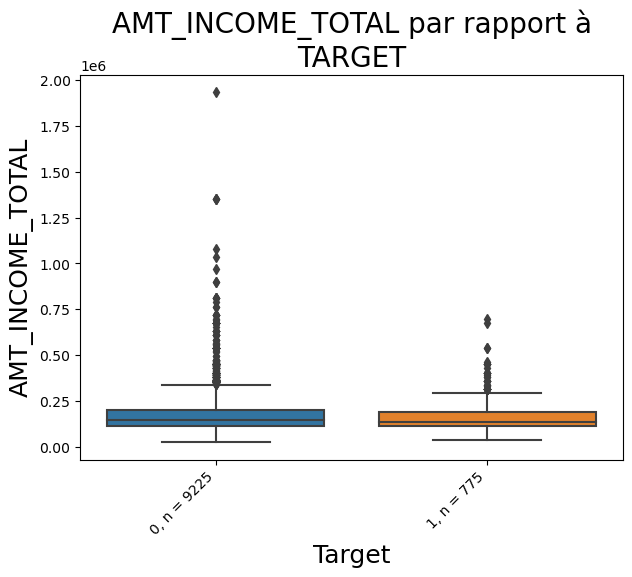

Variable testée :  AMT_INCOME_TOTAL
p_value : 0.18545
La moyenne des deux groupes n'est pas statistiquement différente.


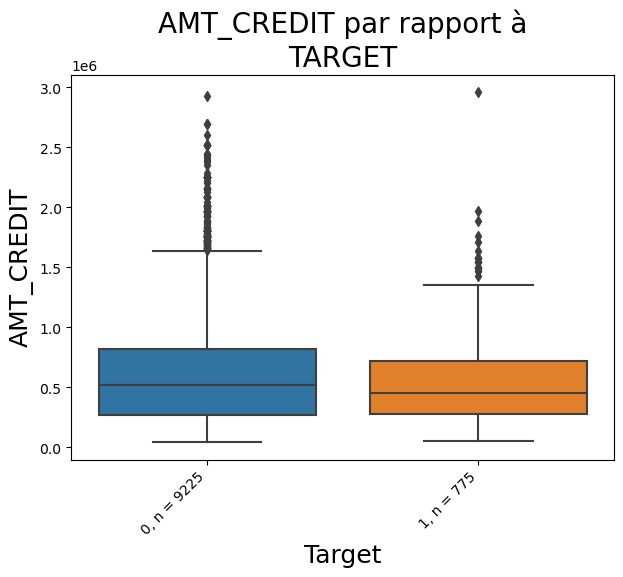

Variable testée :  AMT_CREDIT
p_value : 0.01669
La moyenne des deux groupes est statistiquement différente.


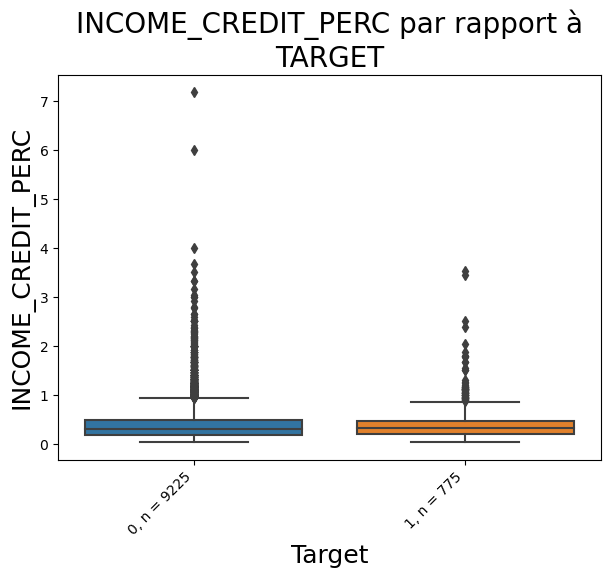

Variable testée :  INCOME_CREDIT_PERC
p_value : 0.43073
La moyenne des deux groupes n'est pas statistiquement différente.


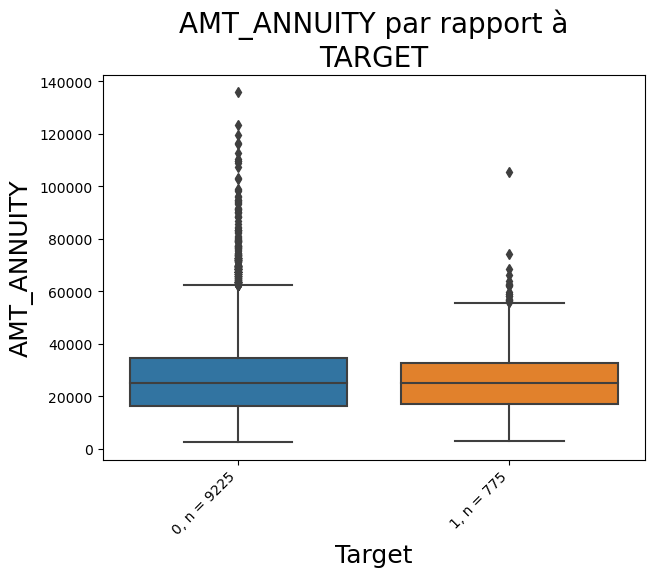

Variable testée :  AMT_ANNUITY
p_value : 0.92099
La moyenne des deux groupes n'est pas statistiquement différente.


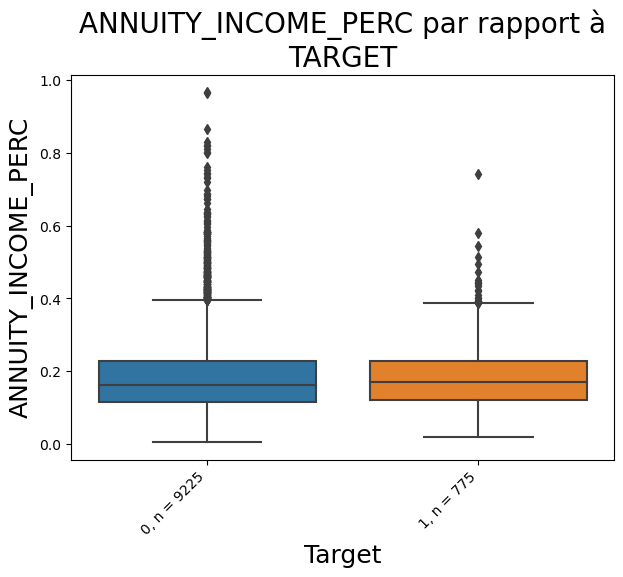

Variable testée :  ANNUITY_INCOME_PERC
p_value : 0.59236
La moyenne des deux groupes n'est pas statistiquement différente.


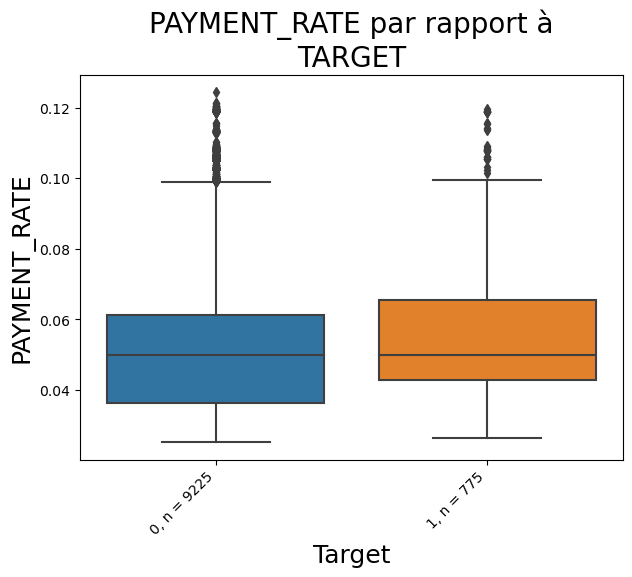

Variable testée :  PAYMENT_RATE
p_value : 0.00407
La moyenne des deux groupes est statistiquement différente.


In [876]:
for col in [c for c in mask.columns if c != "TARGET"]:
    graphBoxplot(mask, "TARGET", col, "TARGET", (7,5))
    
    # Pour réduire la skewness
    mask2 = copy.deepcopy(mask[mask[col].notnull()])
    mask2[col] = np.log1p(mask[col])
    
    test_stat(mask2, col)

Il est montré qu'un crédit plus bas est significativement associé à un défaut de paiement.

De plus, un taux de remboursement plus élevé est également associé à un défaut de paiement. 

On peut regarder quelques variables corrélées positivement et négativement à target

In [894]:
correlation_scores = data.drop(columns=['TARGET']).corrwith(data['TARGET'])
correlation_scores

SK_ID_CURR             0.002962
CODE_GENDER           -0.057311
FLAG_OWN_CAR          -0.012447
FLAG_OWN_REALTY        0.014299
CNT_CHILDREN           0.035922
                         ...   
INCOME_CREDIT_PERC     0.005594
INCOME_PER_PERSON     -0.021061
ANNUITY_INCOME_PERC    0.003416
PAYMENT_RATE           0.027771
ANNEES_AGE            -0.093312
Length: 192, dtype: float64

In [900]:
# On récupère les 5 corrélations positives et négatives
most_pos_corr = correlation_scores.sort_values(ascending = False)[:5]
display("Variables corrélées positivement à TARGET", most_pos_corr)

most_neg_corr = correlation_scores.sort_values()[:5]
display("Variables corrélées négativement à TARGET", most_neg_corr)

'Variables corrélées positivement à TARGET'

DAYS_EMPLOYED                  0.087096
REGION_RATING_CLIENT_W_CITY    0.071400
DAYS_ID_PUBLISH                0.070535
REGION_RATING_CLIENT           0.069991
DAYS_LAST_PHONE_CHANGE         0.067106
dtype: float64

'Variables corrélées négativement à TARGET'

EXT_SOURCE_3                           -0.198362
EXT_SOURCE_2                           -0.170762
ANNEES_AGE                             -0.093312
DAYS_EMPLOYED_PERC                     -0.077080
NAME_EDUCATION_TYPE_Higher education   -0.071796
dtype: float64

Pour les variables négativement corrélées (plus c'est haut, moins y'a de risque de défaut de paiement). On a déjà vu pour l'age et pourcentage au travail. On a 2 variables un peu inconnues EXT_SOURCE 2 et 3. Et on a une variable sur l'éducation supérieure.

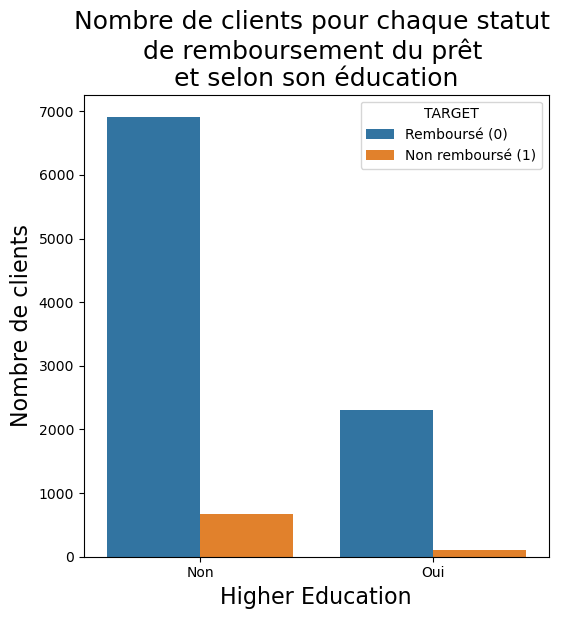

In [911]:
plt.figure(figsize=(6,6))
sns.countplot(data, x = "NAME_EDUCATION_TYPE_Higher education", hue = "TARGET")
plt.title("Nombre de clients pour chaque statut \nde remboursement du prêt \net selon son éducation", fontsize = 18)
plt.ylabel("Nombre de clients", fontsize = 16)
plt.xlabel("Higher Education", fontsize = 16)
plt.legend(title="TARGET", labels=["Remboursé (0)", "Non remboursé (1)"])
plt.xticks(ticks=[0, 1], labels=["Non", "Oui"]) 
plt.show()

On retrouve chez les clients qui n'ont pas remboursés peu qui ont une éducation élevée 

In [912]:
chi_test_stat(data, "NAME_EDUCATION_TYPE_Higher education")

Variable testée :  NAME_EDUCATION_TYPE_Higher education
p_value : 0.00000
Il y a une association significative entre NAME_EDUCATION_TYPE_Higher education et la variable TARGET.


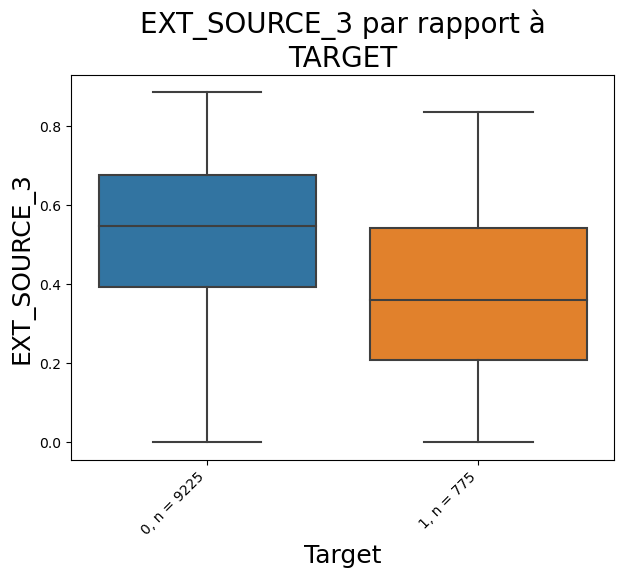

Variable testée :  EXT_SOURCE_3
p_value : 0.00000
La moyenne des deux groupes est statistiquement différente.


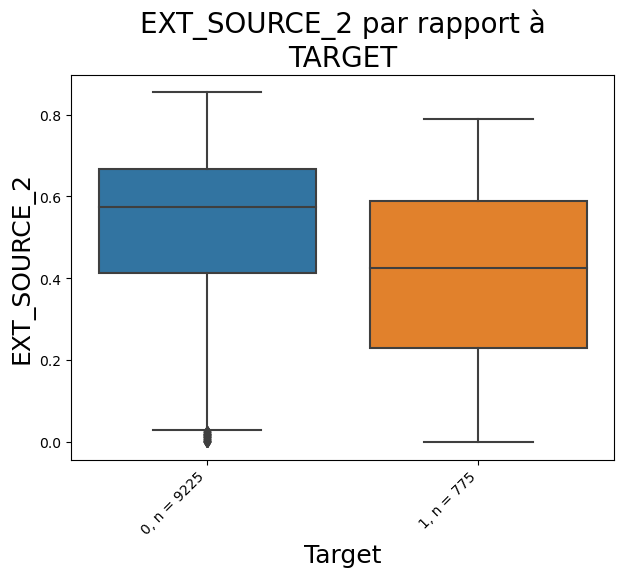

Variable testée :  EXT_SOURCE_2
p_value : 0.00000
La moyenne des deux groupes est statistiquement différente.


In [915]:
for col in most_neg_corr.index[:2]:
    graphBoxplot(data, "TARGET", col, "TARGET", (7,5))
    
    # Pour réduire la skewness
    mask = copy.deepcopy(data[data[col].notnull()])
    mask[col] = np.log1p(mask[col])
    
    test_stat(mask, col)

On ne sait pas trop ce que ça représente, mais plus cette valeur est basse plus elle est associée à un défaut de paiement.

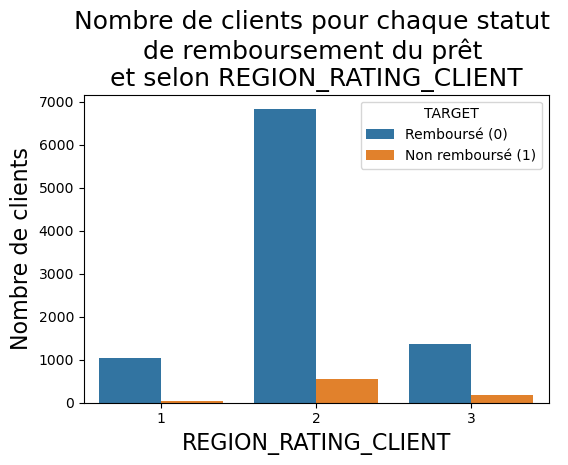

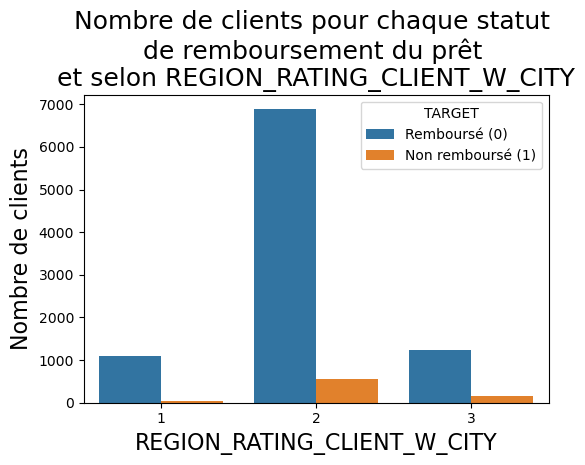

In [926]:
for col in ["REGION_RATING_CLIENT", "REGION_RATING_CLIENT_W_CITY"]: 
    plt.figure(figsize=(6,4))
    sns.countplot(data, x = col, hue = "TARGET")
    plt.title(f"Nombre de clients pour chaque statut \nde remboursement du prêt \net selon {col}", fontsize = 18)
    plt.ylabel("Nombre de clients", fontsize = 16)
    plt.xlabel(col, fontsize = 16)
    plt.legend(title="TARGET", labels=["Remboursé (0)", "Non remboursé (1)"])
    plt.show()

Variables similaires, on peut n'en garder qu'un des deux.

In [928]:
data.drop("REGION_RATING_CLIENT_W_CITY", axis = 1, inplace = True)

In [929]:
chi_test_stat(data, "REGION_RATING_CLIENT")

Variable testée :  REGION_RATING_CLIENT
p_value : 0.00000
Il y a une association significative entre REGION_RATING_CLIENT et la variable TARGET.


In [932]:
# On élimine DAYS_EMPLOYED variable car on a une autre variable (DAYS_EMPLOYED_PERC) plus informative
data.drop("DAYS_EMPLOYED", axis = 1, inplace = True)

In [934]:
data.DAYS_LAST_PHONE_CHANGE.describe()

count    10000.000000
mean      -960.207000
std        826.777768
min      -3882.000000
25%      -1558.250000
50%       -752.000000
75%       -261.000000
max          0.000000
Name: DAYS_LAST_PHONE_CHANGE, dtype: float64

On va convertir en année, puis en valeurs positives, c'est plus informatif.

In [942]:
# On met en positif, puis on divise par 365 pour avoir le nombre d'années
data["ANNEES_LAST_PHONE_CHANGE"] = round((abs(data.DAYS_LAST_PHONE_CHANGE) / 365), 2)
data.drop("DAYS_LAST_PHONE_CHANGE", axis = 1, inplace = True)

In [943]:
data.ANNEES_LAST_PHONE_CHANGE.describe()

count    10000.000000
mean         2.630782
std          2.265173
min          0.000000
25%          0.720000
50%          2.060000
75%          4.270000
max         10.640000
Name: ANNEES_LAST_PHONE_CHANGE, dtype: float64

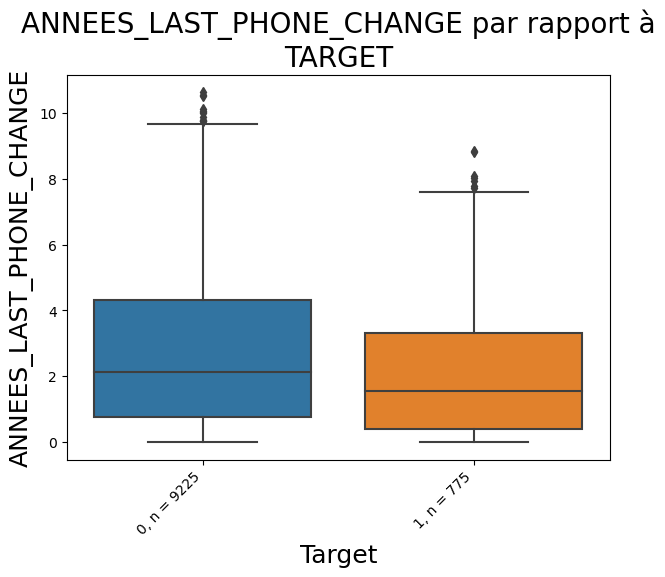

Variable testée :  ANNEES_LAST_PHONE_CHANGE
p_value : 0.00000
La moyenne des deux groupes est statistiquement différente.


In [941]:
graphBoxplot(data, "TARGET", "ANNEES_LAST_PHONE_CHANGE", "TARGET", (7,5))

# Pour réduire la skewness
mask = copy.deepcopy(data[data["ANNEES_LAST_PHONE_CHANGE"].notnull()])
mask[col] = np.log1p(mask["ANNEES_LAST_PHONE_CHANGE"])

test_stat(mask, "ANNEES_LAST_PHONE_CHANGE")

Un changement récent de téléphone est synonyme d'un échec dans le remboursement de son prêt.

On peut assimiler cela à des dépenses trop courantes et importantes qui ne sont pas en adéquations avec un remboursement d'un prêt. 

***
# <a name="T3">Modélisation</a>

In [18]:
data.value_counts("TARGET")

TARGET
0    9225
1     775
dtype: int64

In [957]:
def debug_file(df, debug = False):
    
    # On utilise que 3 variables pour tester la modèlisation
    if debug == True:
        X = df[["ANNEES_AGE", "DAYS_EMPLOYED_PERC", "CODE_GENDER"]]
        k_selection = [3]
        dataset_name = "Test avec peu de variables"

    # On utilise l'ensemble des variables
    else : 
        X = df.drop("TARGET", axis = 1)
        k_selection = [40, 60]
        dataset_name = "Test avec l'ensemble des variables"
        
    Y = df["TARGET"]

    # On sépare en 3, train/val/test 
    # Le val set servira principalement pour le tuning du modèle Deep learning 
    # Le test set servira pour comparer les différents modèles entre eux
    
    # Split : 80 / 10 / 10
    xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size = 0.2, stratify = df["TARGET"], random_state = 42)
    xtest, xval, ytest, yval = train_test_split(xtest, ytest, test_size = 0.5, stratify = ytest, random_state = 42)
    return xtrain, xtest, xval, ytrain, ytest, yval, dataset_name, k_selection

In [963]:
xtrain, xtest, xval, ytrain, ytest, yval, dataset_name, k_selection = debug_file(data.drop("SK_ID_CURR", axis = 1), False)

In [964]:
print("Taille et dimension des données d'entraînement :", xtrain.shape)
print("Taille et dimension des données de test :", xtest.shape)
print("Taille et dimension des données de validation :", xval.shape)

Taille et dimension des données d'entraînement : (8000, 189)
Taille et dimension des données de test : (1000, 189)
Taille et dimension des données de validation : (1000, 189)


In [962]:
print("Répartition de la variable TARGET")
print(ytrain.value_counts())
print(ytest.value_counts())
print(yval.value_counts())

Répartition de la variable TARGET
0    7380
1     620
Name: TARGET, dtype: int64
0    922
1     78
Name: TARGET, dtype: int64
0    923
1     77
Name: TARGET, dtype: int64


On obtient la répartition attendue

### <a name = "T3C1">a. Pipeline</a>

Nous avons observé qu'il y avait une sous-représentation des individus n'ayant pas sur rembourser leur crédit contre ceux qui ont pu le rembourser (1/10). Il faut traiter ce problème, sinon les algorithmes auront dû mal à prédire.

Pour cela, nous allons tester les algorithmes de la librairie imbalanced-learn

In [596]:
# ancienne version avant ajout dans pipeline
def resample(x_train, y_train, choice = 0):
    ## 
    # Fonction qui resample les échantillons par sous, sur ou un mélange de ré échantillonnage
    # Par défaut, pas de resampling
    ##

    # On utilise différentes méthodes pour traiter les échantillons 
    if choice == 1:
        # On sous-échantillonne le groupe majoritaire
        ss_echant = NearMiss()
        x_resampled, y_resampled = ss_echant.fit_resample(xtrain_median, ytrain)
    elif choice == 2:
        # On sur-échantillonne le groupe minoritaire
        sur_echant = SMOTE()
        x_resampled, y_resampled = sur_echant.fit_resample(xtrain_median, ytrain)
    elif choice == 3:
        # Combinaison des 2 méthodes
        comb_echant = SMOTEENN()
        x_resampled, y_resampled = comb_echant.fit_resample(xtrain_median, ytrain)
    else:
        # No resampling
        x_resampled, y_resampled = x_train, y_train
    
    if choice != 0:
        print("Ancienne distribution :", Counter(y_train))
        print("Nouvelle distribution :", Counter(y_resampled))
    
    return x_resampled, y_resampled

In [597]:
def plot_feature_importance(importance, names, model_name):
    ## 
    #    Fonction affichant les 20 plus importantes features des modèles de type DecisionTree
    ##
    
    # On créé 2 listes  contenant les coefficients et le nom des features
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # On créé un dataframe à partir d'un dictionnaire
    df = {"feature_names" : feature_names, "feature_importance" : feature_importance}
    fi_df = pd.DataFrame(df)

    # On classe notre dataframe par feature importance (décroissance)
    fi_df.sort_values("feature_importance", ascending = False, inplace = True)

    taille_max = 0.4 * len(names) if len(names) < 20 else 0.4 * 20
    
    plt.figure(figsize=(10, taille_max))
    
    # On affiche que les 20 premières features
    sns.barplot(x = fi_df["feature_importance"][:20], y = fi_df["feature_names"][:20])

    plt.title(model_name)
    
    plt.xlabel("FEATURE IMPORTANCE (coefficient)")
    plt.ylabel("FEATURES")
    
    plt.show()
    
    
def plot_coefficients_importance(feature_importance, names, model_name):
    ## 
    #    Fonction affichant les 20 plus importantes features des modèles de type Regression
    ##
    
    # On créé 1 liste  contenant le nom des features
    feature_names = np.array(names)
    
    # On créé un dataframe à partir d'un dictionnaire
    df = {"feature_names" : feature_names, "feature_importance" : feature_importance}
    fi_df = pd.DataFrame(df)

    # On classe notre dataframe par feature importance (décroissance)
    fi_df.sort_values("feature_importance", ascending = False, inplace = True)

    taille_max = 0.4 * len(names) if len(names) < 20 else 0.4 * 20
    
    plt.figure(figsize=(10, taille_max))
    
    # On affiche que les 20 premières features
    sns.barplot(x = fi_df["feature_importance"][:20], y = fi_df["feature_names"][:20])

    plt.title(model_name)
    plt.xlabel("FEATURE IMPORTANCE (coefficient)")
    plt.ylabel("FEATURES")
    
    plt.show()   

Matrice de confusion :

**Positif/Negatif : Type de classe (label) ["Non", "Oui"] True/False: Correctement ou incorrectement classifié par le modèle.**


- Vrais négatifs (En haut à gauche) : Nombre de classifications correctes de la classe "Non" (Bon client).


- Faux positifs (En haut à droite) : Nombre de classifications incorrectes de la classe "Non" (Bon client).


- Faux négatifs (En bas à gauche) : Nombre de classifications incorrectes de la classe "Oui" (Mauvaise client).


- Vrais positifs (En bas à droite) : Nombre de classifications correctes de la classe "Oui" (Mauvaise client).

In [598]:
# Fonction affichant la matrice de confusion
def matrice_confusion(real_labels, predicted_labels):

    conf_mat = confusion_matrix(real_labels, predicted_labels, labels = [0, 1])

    df_cm = pd.DataFrame(conf_mat)
    
    plt.figure(figsize = (6,4))
    
    # On garde la valeur précédente pour la restaurer ensuite
    original_font_weight = plt.rcParams['font.weight']
    plt.rcParams['font.weight'] = 'bold'
    
    sns.heatmap(df_cm, annot=True, fmt='d', cmap="Blues")
    
    classes = ["Bon client", "Mauvais client"]
    
    tick_positions = np.arange(0.5, len(classes))
    plt.xticks(tick_positions, classes)
    plt.yticks(tick_positions, classes)
    
    plt.ylabel('Vrais labels', fontsize=20)
    
    plt.xlabel('Labels prédits', fontsize=20)
     
    # On ajoute du texte à la figure
    texte_add = ["Vrais négatifs", "Faux positifs", "Faux négatifs", "Vrais positifs"]
    n = 0
    
    # Pour alléger le code
    conditions_affichage = {'ha': 'center', 'va': 'center', 'color': 'black', 'weight': 'bold'}
    
    for i in range(len(df_cm)):
        for j in range(len(df_cm)):
            # On mesure le pourcentage sur le total de chaque label
            #pourcentage = round(df_cm.iloc[i, j] / len(real_labels) * 100, 1) 
            pourcentage = round(df_cm.iloc[i, j] / (df_cm.iloc[i, 0] + df_cm.iloc[i, 1]) * 100, 1)
                
            # On change la couleur du texte selon le background
            if df_cm.iloc[i, j] > df_cm.values.max() / 2:
                conditions_affichage['color'] = 'white'
            else:
                conditions_affichage['color'] = 'black'
            
            # On ajoute du texte
            plt.text(j + 0.5, i + 0.625, "(" + str(pourcentage) + " %)", **conditions_affichage)
            plt.text(j + 0.5, i + 0.75, texte_add[n], **conditions_affichage)
            n += 1
    
    plt.rcParams['font.weight'] = original_font_weight

    plt.show()

# Fonction affichant plusieurs métriques comparant les résultats de prédictions vs réels et matrice de confusion
def results_prediction(real_labels, predicted_labels):

    print(classification_report(real_labels, predicted_labels))

    # on appel la fonction matrice_confusion
    matrice_confusion(real_labels, predicted_labels)

In [599]:
def calcul_nombre_hyperparametres(param_grid):
    ##
    #    Fonction retournant le nombre total d'hyperparamètres testés
    ##
    
    # On initialise
    total = 1
    
    # On parcours le dictionnaire
    for values in param_grid.values():
        total *= len(values)
    
    # On retourne le nombre total
    return total

In [600]:
def extract_confusion_matrix_metrics(confusion_m):
    ##
    # Fonction extraction les valeurs de la matrice de confusion
    # Retourne sous la forme d'un dictionnaire
    ##
    vn = confusion_m[0, 0]  # vrais négatifs
    vp = confusion_m[1, 1]  # vrais positifs
    fp = confusion_m[1, 0]  # faux positifs
    fn = confusion_m[0, 1]  # faux negatifs
    
    valeurs_matrice = {
        "VN": vn,
        "VP": vp,
        "FP": fp,
        "FN": fn
    }
    
    return valeurs_matrice


In [601]:
# Fonction retournant un score entre -100*pénalisation et 100
# Plus on est proche de 100, plus notre prédiction est performante
# Nous voulons minimiser les faux négatifs, donc nous les pénalisons

def my_custom_score_func(y_true_labels, y_pred_labels, penalite = 10):
    
    confusion_m = confusion_matrix(y_true_labels, y_pred_labels)
    
    valeurs_matrice_dict = extract_confusion_matrix_metrics(confusion_m)
    
    total = sum(v for v in valeurs_matrice_dict.values())

    upper = (valeurs_matrice_dict['VN'] + valeurs_matrice_dict['VP']) / total * 100

    downer = (valeurs_matrice_dict['FP'] + valeurs_matrice_dict['FN'] * penalite) / total * 100
    
    return upper - downer

In [602]:
def classification_scores(y_true_labels, y_pred_labels,):
    ##
    #    On calcul les valeurs moyennes de précision, recall et score F1
    ##
    precision_mean = round(precision_score(y_true_labels, y_pred_labels, average="macro"), 2)
    recall_mean = round(recall_score(y_true_labels, y_pred_labels, average="macro"), 2)
    f1_mean = round(f1_score(y_true_labels, y_pred_labels, average="macro"), 2)
    
    return precision_mean, recall_mean, f1_mean

In [603]:
def best_preprocessor(grid_model):
    
    ##
    #    Fonction permettant de récupèrer les meilleurs préprocesseurs d'un grid search
    #    On retourne un nouveau pipeline
    #    Objectif : Transformer les samples avec le pipeline pour certains traitements
    ##
    
    # On récupère les meilleurs pré processeurs à partir du grid_search
    best_imputer = grid_model.best_estimator_.named_steps['imputer']
    best_scaler = grid_model.best_estimator_.named_steps['scaler']
    best_features = grid_model.best_estimator_.named_steps['feature_selection']

    # On récupère l'indexe des features selectionnées
    selected_indexes = best_features.get_support(indices=True)
    
    # On crée un nouveau pipeline avec les meilleurs pré processeurs
    new_pipe = Pipeline([
        ('imputer', best_imputer),
        ('feature_elimination', VarianceThreshold(threshold=0.0)),
        ('feature_selection', SelectKBest(score_func=f_classif, k=len(selected_indexes))),
        ('scaler', best_scaler)
    ])
    
    return new_pipe

def sample_post_process(pipe, x_data, y_data):
    
    ##
    #    Fonction retournant x_data après transformation avec un pipeline 
    ##
    
    x_data_preprocessed = pipe.fit_transform(x_data, y_data)
    
    return x_data_preprocessed

In [604]:
def top_shape_features(shap_values, x_train_ech, feature_names):
    ##
    #    Fonction permettant de récupèrer les 20 features les plus importantes
    ##
    
    # On calcul la somme absolue des valeurs Shap de chaque feature
    shap_values_sum = np.abs(shap_values).mean(axis=0)

    # On trie les sommes des valeurs shap du plus haut au plus petit
    sorted_features_index = np.argsort(shap_values_sum)[::-1]

    max_len = 20 if len(feature_names) > 20 else len(feature_names)
    
    # On sélectionne les N features avec valeurs les plus hautes
    top_features_index = sorted_features_index[:max_len]  
    
    # On récupère les noms des features
    top_feature_names = [feature_names[i] for i in top_features_index]

    # On filtre pour n'avoir que les N features sélectionnées
    shap_values_top = shap_values[:, top_features_index]
    x_train_ech_top = x_train_ech[:, top_features_index]
    
    return x_train_ech_top, shap_values_top, top_feature_names

def coefficients_importance_by_shape(model, x_train, y_train, feature_names, model_type):
    ##
    #    Fonction permettant un affichage indépendant avec SHAP de l'importance des variables dans les modèles
    #    De façon local et global
    ##

    np.random.seed(42)
    random.seed(42)  
        
    # On sélectionnne un sous échantillonnage pour limiter les temps de calcul
    ech_indices = np.random.choice(x_train.shape[0], size = 500, replace=False)
    x_train_ech = x_train[ech_indices]
    
    if model_type == 0: 
        explainer = shap.LinearExplainer(model, x_train_ech)

    elif model_type == 1:
        explainer = shap.TreeExplainer(model, x_train_ech)

    elif model_type == 2:
        explainer = shap.KernelExplainer(model.predict_proba, x_train_ech)
        
    # check_additivity=False pour les TreeExplainer
    shap_values = explainer.shap_values(x_train_ech) if model_type != 1 else explainer.shap_values(x_train_ech, check_additivity=False)
    expected_values = explainer.expected_value

    if len(shap_values) == 2:
        shap_values = shap_values[1] 
        expected_values = expected_values[0]
        
    print("Utilisation de SHAP pour une explication indépendante des modèles")
    print("En quoi les variables contribue à un défaut de paiement :")
    
    # On récupère les meilleures features
    x_train_ech_top, shap_values_top, top_feature_names = top_shape_features(shap_values, x_train_ech, feature_names)
    
    shap.summary_plot(shap_values_top, 
                      x_train_ech_top,
                      feature_names=[name[:20] for name in top_feature_names], 
                      max_display=20, show=False, plot_size=(10, 6))
    
    # On récupère les informations des objets figures
    fig, ax = plt.gcf(), plt.gca()

    ax.tick_params(labelsize=14)
    ax.set_xlabel("Valeurs de SHAP (impacts sur les sorties du modèle)", fontsize=16)
    ax.set_title("Importance des Features - Prédiction sur l'obtention d'un crédit bancaire", fontsize=20)
    
    #On met une limite, pour avoir un meilleur affichage
    #ax.set_xlim(-2, 2)
    
    # On récupère la barre de couleur
    cb_ax = fig.axes[1] 

    # On modifie les paramètres de la barre de couleur
    cb_ax.tick_params(labelsize=15)
    cb_ax.set_ylabel("Feature value", fontsize=20)
    
    plt.show()
    
    # On recherche les indices de chaque catégories
    ech_indices_cat0 = np.where((y_train.iloc[ech_indices] == 0))[0]
    ech_indices_cat1 = np.where((y_train.iloc[ech_indices] == 1))[0]

    # On choisit aléatoirement 3 de chaque catégories
    random_indices_cat0 = random.sample(list(ech_indices_cat0), 3)
    random_indices_cat1 = random.sample(list(ech_indices_cat1), 3)
    
    for i in range(2):
        category_indices = random_indices_cat0 if i == 0 else random_indices_cat1
        
        for j in range(3):
            shap.force_plot(expected_values, shap_values_top[category_indices[j]], top_feature_names, matplotlib=True)
            plt.show()
                  
    #shap.summary_plot(explainer.shap_values(x_train_ech), x_train_ech, plot_type="bar")


In [605]:
def calcul_scores(best_estimator, x_train, y_train, x_test, y_test, beta):
    ##
    #    Fonction permettant de mesurer un certains nombre de métriques
    #    Retourne les résultats sous la forme d'un dictionnaire
    ##
    
    
    # On prédit les probabilités 
    y_pred_prob_train = best_estimator.predict_proba(x_train)[:, 1]
    y_pred_prob_test = best_estimator.predict_proba(x_test)[:, 1]
    
    # On prédit les labels
    y_pred_train = best_estimator.predict(x_train)
    y_pred_test = best_estimator.predict(x_test)
    
    # On calcul le score de performance
    score_performance_train = round(my_custom_score_func(y_train, y_pred_train), 2)
    score_performance_test = round(my_custom_score_func(y_test, y_pred_test), 2)
    
    # On calcul le score roc auc
    roc_auc_train = round(roc_auc_score(y_train, y_pred_prob_train), 2)
    roc_auc_test = round(roc_auc_score(y_test, y_pred_prob_test), 2)

    # On calcul le pourcentage d'erreur
    errors_train = round( 100 * (1 - best_estimator.score(x_train, y_train)), 2)
    errors_test = round( 100 * (1 - best_estimator.score(x_test, y_test)), 2)
    
    # On calcul le f beta score
    f_beta_train = round(fbeta_score(y_train, y_pred_train, beta=beta), 2)
    f_beta_test = round(fbeta_score(y_test, y_pred_test, beta=beta), 2)

    # On calcul les différents scores de la matrice de confusion
    precision_mean, recall_mean, f1_mean = classification_scores(ytest, y_pred_test)

    scores = {
        "score_performance_train": score_performance_train,
        "score_performance_test": score_performance_test,
        "roc_auc_train": roc_auc_train,
        "roc_auc_test": roc_auc_test,
        "errors_train": errors_train,
        "errors_test": errors_test,
        "f_beta_train": f_beta_train,
        "f_beta_test": f_beta_test,
        "precision_mean": precision_mean,
        "recall_mean": recall_mean,
        "f1_mean": f1_mean
    }

    return scores


In [606]:
def affichage_score(best_params, dict_scores, verb = 1):
    ##
    #    Fonction d'affichage des scores des métriques
    ##
    
    print("\n\n")
    print("_" * 100)
    print("Meilleurs paramètres :", best_params)
    print("Temps de recherche des meilleurs paramètres :", dict_scores["training_time"])
    print("Temps d'exécution :", dict_scores["elapsed_time"])
    print("_" * 20)
    print("Résultats sur échantillons d'entraînement :")
    print("Score performance : %.2f %%" %dict_scores["score_performance_train"])
    print("Erreur : %.2f %%" %dict_scores["errors_train"])
    print("ROC_AUC :", dict_scores["roc_auc_train"])
    print("Fbeta-Score : %.2f " %dict_scores["f_beta_train"])
    print("_" * 20)
    print("Résultats sur échantillons de test :")
    print("Score performance : %.2f %%" %dict_scores["score_performance_test"])
    print("Erreur : %.2f %%" %dict_scores["errors_test"])
    print("ROC_AUC :", dict_scores["roc_auc_test"])
    print("Precision moyenne : %.2f " %dict_scores["precision_mean"])
    print("Recall moyen : %.2f " %dict_scores["recall_mean"])
    print("F1-Score moyen : %.2f " %dict_scores["f1_mean"])
    print("Fbeta-Score : %.2f " %dict_scores["f_beta_test"])
    print("_" * 100)
    print("\n\n")

In [607]:
def search_model_params(model_name, model, params, x_train, y_train, x_test, y_test, model_type = None, verb = 1):
    ##
    #    Fonction recherchant les meilleurs paramètres du modèle à l'aide d'un gridsearch
    #    On retourne un certain nombre de métriques de scores 
    ##

    # model : nom du modèle testé (format string)
    # model_type : type de modèle testé (format string)
    # cls : modèle instancier à tester
    # params : paramètres du modèle à tester avec gridsearch
    # train/test : variables utilisées
    # verb : verbosité, affichage des résultats
    # On retourne les scores obtenus avec le modèle et ses meilleurs paramètres
    
    
    # Création du pipeline
    # On réalise une imputation (mean ou median)
    # On élimine les features sans variance après imputation
    # On réalise une sélection des features avec ANOVA
    # Prend en compte un scaler et un sampler avant d'appliquer le modèle
    # On utilise un sampler dû aux données sur représentées
    # On instancie le modèle
    
    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('feature_elimination', VarianceThreshold(threshold=0.0)),
        ('feature_selection', SelectKBest(score_func=f_classif)),
        ('scaler', None),
        ('sampler', None),
        ('model', model)
    ])
    
    # On crée un dictionnaire qui contiendra les différents scores
    scores = {}
    
    # On utilise notre scorer, on veut maximiser le score
    my_scorer = make_scorer(my_custom_score_func, greater_is_better=True)
    precision_scorer = make_scorer(precision_score, zero_division=1, greater_is_better=True)
    recall_scorer = make_scorer(recall_score, zero_division=1, greater_is_better=True)
    f1_scorer = make_scorer(f1_score, zero_division=1, greater_is_better=True)
    beta = 2
    f_beta_scorer = make_scorer(fbeta_score, zero_division=1, beta=beta, greater_is_better=True)
    
    # On veut suivre plusieurs scores
    scorers = {
    "custom_score" : my_scorer,
    "roc_auc" : "roc_auc",
    "precision_scorer" : precision_scorer,
    "recall_scorer" : recall_scorer,
    "f1_scorer" : f1_scorer,
    "f_beta" : f_beta_scorer,
    }
            
    time0 = time.time()
    
    # On instancie un StratifiedKFold pour garder la répartition dans le gridsearch
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # On réalise un RandomizedSearchCV pour trouver les meilleurs hyperparamètres pour les modèle de type "arbre de décision"
    if model_type == "DecisionTree":
        # On test 75 % des paramètres
        n_iter = calcul_nombre_hyperparametres(params) * 0.75
        
        print("Nous testons %d hyperparamètres" %n_iter) 

        grid = RandomizedSearchCV(pipe, params, cv = stratified_kfold, scoring = scorers, refit = "f_beta",#"custom_score", 
                                  verbose = 1, n_iter = n_iter, n_jobs=-1)
        
    # On réalise un GridSearchCV pour trouver les meilleurs hyperparamètres pour les modèles de type non "arbre de décision"
    else :
        print("Nous testons %d hyperparamètres" %calcul_nombre_hyperparametres(param_grid_search)) 
        
        grid = GridSearchCV(pipe, params, cv = stratified_kfold, scoring = scorers, refit = "f_beta", 
                            verbose = 1, n_jobs=-1)


    # On fit sur les données d'entrainement
    grid.fit(x_train, y_train)

    time1 = time.time()

    # On mesure le temps d'entrainement
    scores["training_time"] = round(time1 - time0, 1)

    # On récupère les meilleurs paramètres 
    best_param_pipe = grid.best_estimator_
        
    # On réalise une cross évaluation
    cross_scores = cross_val_score(best_param_pipe, x_train, y_train, cv=stratified_kfold, scoring=my_scorer)
    print("Cross-validation score : %0.2f %% avec un écart-type de %0.2f %% \n" 
              % (cross_scores.mean(), cross_scores.std()))
    
    # On mesure les différentes métriques et on ajoute au dictionnaire
    scores.update(calcul_scores(best_param_pipe, x_train, y_train, x_test, y_test, beta))

    # On mesure le temps d'application du meilleur modèle
    scores["elapsed_time"] = round(time.time() - time1, 1)
    
    if verb == 1:
        # On affiche les différents résultats des métriques
        affichage_score(grid.best_params_, scores)
        
        # On affiche la matrice de confusion
        results_prediction(ytest, best_param_pipe.predict(x_test))
        
        # On transform x_train selon le pipeline # Note : peut etre x_test à l'avenir
        x_train_preprocessed = sample_post_process(best_preprocessor(grid), x_train, y_train)

        # On récupère le nom des colonnes sélectionnées
        selected_cols = x_train.columns[grid.best_estimator_['feature_selection'].get_support()]
        
        # On affiche les features les plus importantes pour ce type de modèle
        if model_type == "DecisionTree":
            # On récupère le niveau d'importance des features des modèles de type arbre de décision 
            features_importances = best_param_pipe.named_steps['model'].feature_importances_
            
            plot_feature_importance(features_importances, selected_cols, model_name)
            
            coefficients_importance_by_shape(best_param_pipe.named_steps["model"], x_train_preprocessed, y_train, selected_cols, model_type = 1)
            
         # On affiche les features les plus importantes pour ce type de modèle
        elif model_type == "Regression":
            # On récupère le niveau d'importance des features des modèles de type régression
            features_importances = best_param_pipe.named_steps['model'].coef_[0]
            
            plot_coefficients_importance(features_importances, selected_cols, model_name)
            
            coefficients_importance_by_shape(best_param_pipe.named_steps["model"], x_train_preprocessed, y_train, selected_cols, model_type = 0)
            
        elif model_type == "kernel":
            
            coefficients_importance_by_shape(best_param_pipe.named_steps["model"], x_train_preprocessed, y_train, selected_cols, model_type = 2)


    # On retourne les différentes métriques et le meilleur modèle
    return scores, best_param_pipe


In [608]:
def log_mlflow(param_grid, df, dataset_name, dict_scores, trained_model):
    ##
    #    Fonction cataloguant les résultats des différentes métriques obtenus   
    #    Mais également les données utilisées
    ##
    
    ## Amélioration future : Ajout d'un dictionnaire répertoriant les métriques à cataloguer
    
    # On catalogue les hyperparamètres utilisés
    mlflow.log_params(param_grid_search)    
    
    # On catalogue le dataset utilisé
    dataset = mlflow.data.from_pandas(df, source="concatenate_files.csv")

    mlflow.log_input(dataset, context=dataset_name)
    
    # On catalogue les métriques (on parcours le dictionnaire)
    for key, value in dict_scores.items():
        mlflow.log_metric(str(key), value)
    
    # On catalogue le modèle
    log_model(trained_model, "Modèle entrainé")

In [609]:
# Liste permettant de conserver les résultats des performances des différents modèles
resultats_models = []

### <a name = "T3C2">b. DummyClassifier</a>

Nous testons 16 hyperparamètres
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Cross-validation score : -914.67 % avec un écart-type de 0.38 % 




____________________________________________________________________________________________________
Meilleurs paramètres : {'feature_selection__k': 40, 'imputer': SimpleImputer(strategy='median'), 'sampler': SMOTEENN(), 'scaler': None}
Temps de recherche des meilleurs paramètres : 15.3
Temps d'exécution : 1.8
____________________
Résultats sur échantillons d'entraînement :
Score performance : -914.67 %
Erreur : 92.24 %
ROC_AUC : 0.5
Fbeta-Score : 0.30 
____________________
Résultats sur échantillons de test :
Score performance : -914.93 %
Erreur : 92.27 %
ROC_AUC : 0.5
Precision moyenne : 0.04 
Recall moyen : 0.50 
F1-Score moyen : 0.07 
Fbeta-Score : 0.30 
____________________________________________________________________________________________________



              precision    recall  f1-score   support

           0

C:\Users\33664\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\33664\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\33664\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\33664\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

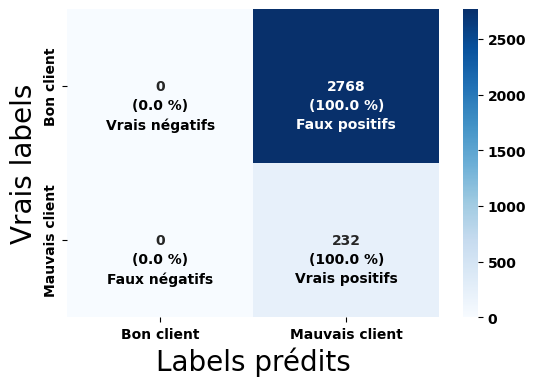

C:\Users\33664\anaconda3\Lib\site-packages\mlflow\data\dataset_source_registry.py:142: UserWarning:

The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.

C:\Users\33664\anaconda3\Lib\site-packages\mlflow\data\pandas_dataset.py:116: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-w

In [610]:
# On recherche les meilleurs hyperparamètres
param_grid_search = {
                     "imputer" : [SimpleImputer(strategy='median')],# SimpleImputer(strategy='mean')],
                     "feature_selection__k" : k_selection, #(3 pendant le debug)
                     "scaler" : [None, StandardScaler()],
                     "sampler" : [None, NearMiss(), SMOTE(), SMOTEENN()]
}

# On instancie le modèle
knn = DummyClassifier(random_state = 42)

# On ajoute en plus du nom du classifier
name = "DummyClassifier"

# On commence l'enregistrement mlflow 
with mlflow.start_run(run_name=name) as run:
    
    # On récupère les résultats après application de la fonction search_model_params
    results, model = search_model_params(name, knn, param_grid_search, xtrain, ytrain, xtest, ytest)
    
    # On catalogue le dataset utilisé, les paramètres grids, les métriques produites et le modèle  
    log_mlflow(param_grid_search, data, dataset_name, results, model)
    
# On ajoute à la liste de résultats des modèles
resultats_models.append([name] + list(results.values()))

### <a name = "T3C3">c. KNeighborsClassifier</a>

Nous testons 96 hyperparamètres
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Cross-validation score : -711.53 % avec un écart-type de 8.25 % 




____________________________________________________________________________________________________
Meilleurs paramètres : {'feature_selection__k': 3, 'imputer': SimpleImputer(strategy='median'), 'model__n_neighbors': 50, 'model__weights': 'uniform', 'sampler': NearMiss(), 'scaler': StandardScaler()}
Temps de recherche des meilleurs paramètres : 3.7
Temps d'exécution : 1.3
____________________
Résultats sur échantillons d'entraînement :
Score performance : -722.91 %
Erreur : 75.63 %
ROC_AUC : 0.54
Fbeta-Score : 0.30 
____________________
Résultats sur échantillons de test :
Score performance : -725.33 %
Erreur : 75.47 %
ROC_AUC : 0.58
Precision moyenne : 0.53 
Recall moyen : 0.56 
F1-Score moyen : 0.24 
Fbeta-Score : 0.32 
____________________________________________________________________________________________________




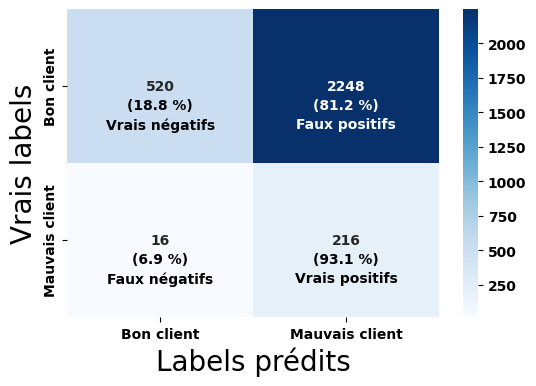

The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable beh

In [38]:
# On recherche les meilleurs hyperparamètres
param_grid_search = {
                     "imputer" : [SimpleImputer(strategy='median')],
                     "feature_selection__k" : k_selection, #(3 pendant le debug)
                     "scaler" : [None, StandardScaler()],
                     "sampler" : [None, NearMiss(), SMOTE(), SMOTEENN()],
                    "model__n_neighbors" : [2, 5, 8, 10, 20, 50], 
                   "model__weights" : ["uniform", "distance"]}

# On instancie le modèle
knn = KNeighborsClassifier()

# On ajoute en plus du nom du classifier
name = "KNeighborsClassifier"

# On commence l'enregistrement mlflow 
with mlflow.start_run(run_name=name) as run:
    
    # On récupère les résultats après application de la fonction search_model_params
    results, model = search_model_params(name, knn, param_grid_search, xtrain, ytrain, xtest, ytest)#, "kernel")
    
    # On catalogue le dataset utilisé, les paramètres grids, les métriques produites et le modèle retenu  
    log_mlflow(param_grid_search, data, dataset_name, results, model)

# On ajoute à la liste de résultats des modèles
resultats_models.append([name] + list(results.values()))

### <a name = "T3C4">d. RandomForestClassifier</a>

Nous testons 36 hyperparamètres
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Cross-validation score : -788.89 % avec un écart-type de 12.93 % 




____________________________________________________________________________________________________
Meilleurs paramètres : {'scaler': StandardScaler(), 'sampler': NearMiss(), 'model__n_estimators': 1000, 'model__max_depth': 5, 'imputer': SimpleImputer(strategy='median'), 'feature_selection__k': 3}
Temps de recherche des meilleurs paramètres : 53.0
Temps d'exécution : 10.0
____________________
Résultats sur échantillons d'entraînement :
Score performance : -787.49 %
Erreur : 81.30 %
ROC_AUC : 0.54
Fbeta-Score : 0.30 
____________________
Résultats sur échantillons de test :
Score performance : -790.93 %
Erreur : 81.27 %
ROC_AUC : 0.57
Precision moyenne : 0.53 
Recall moyen : 0.54 
F1-Score moyen : 0.19 
Fbeta-Score : 0.31 
____________________________________________________________________________________________________




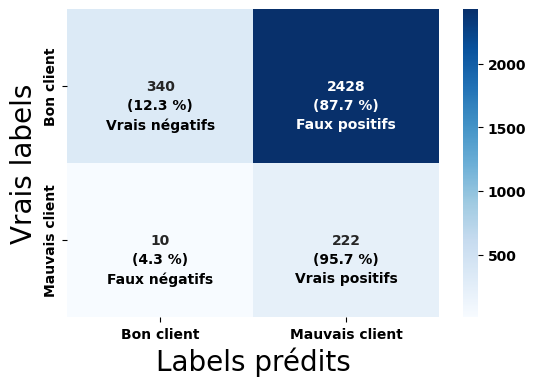

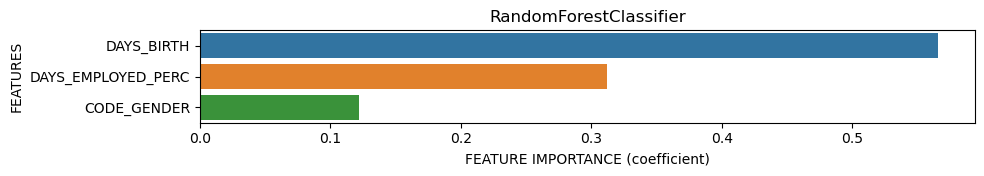

Utilisation de SHAP pour une explication indépendante des modèles
En quoi les variables contribue à un défaut de paiement :


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


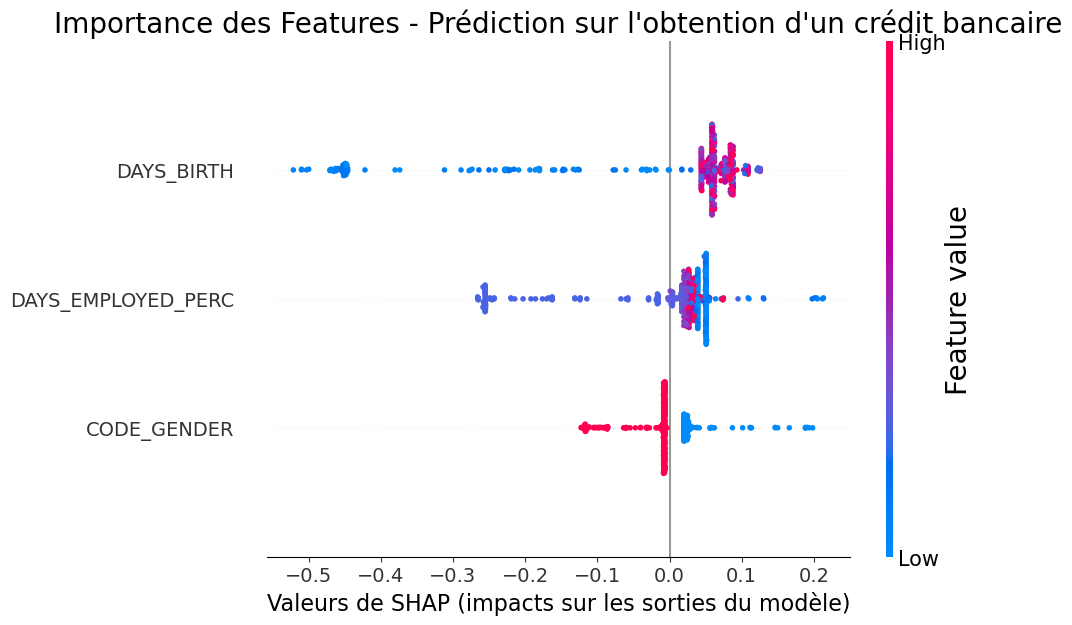

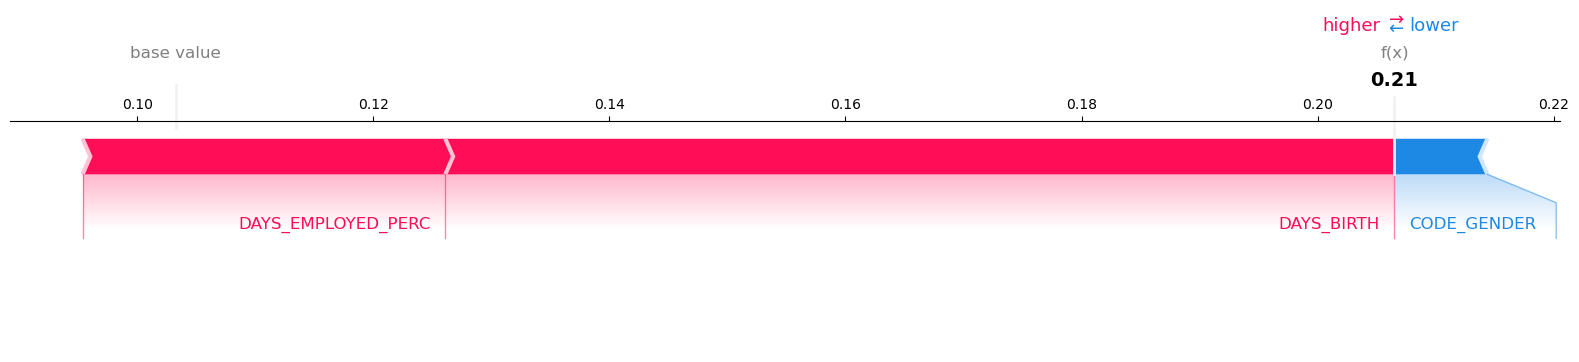

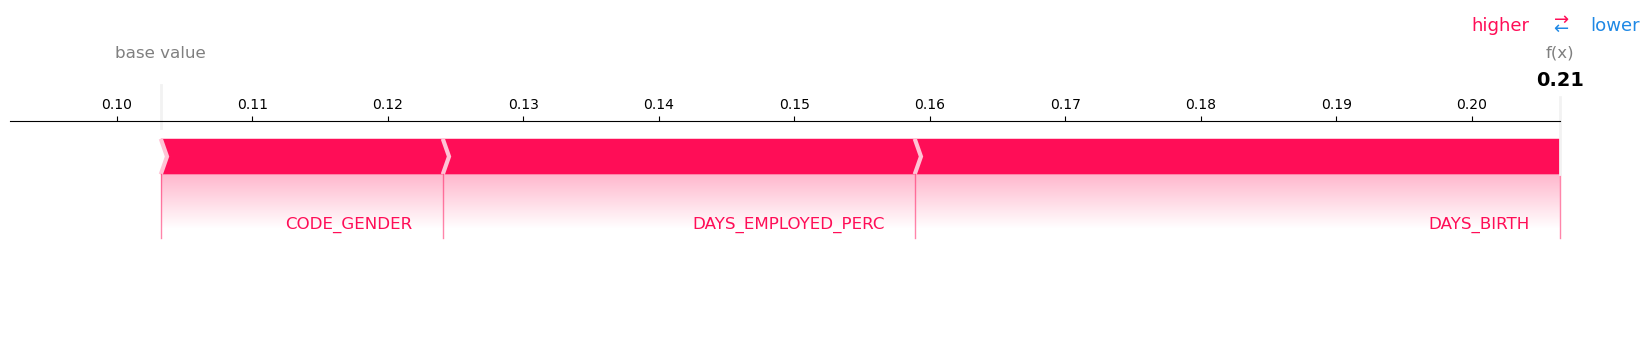

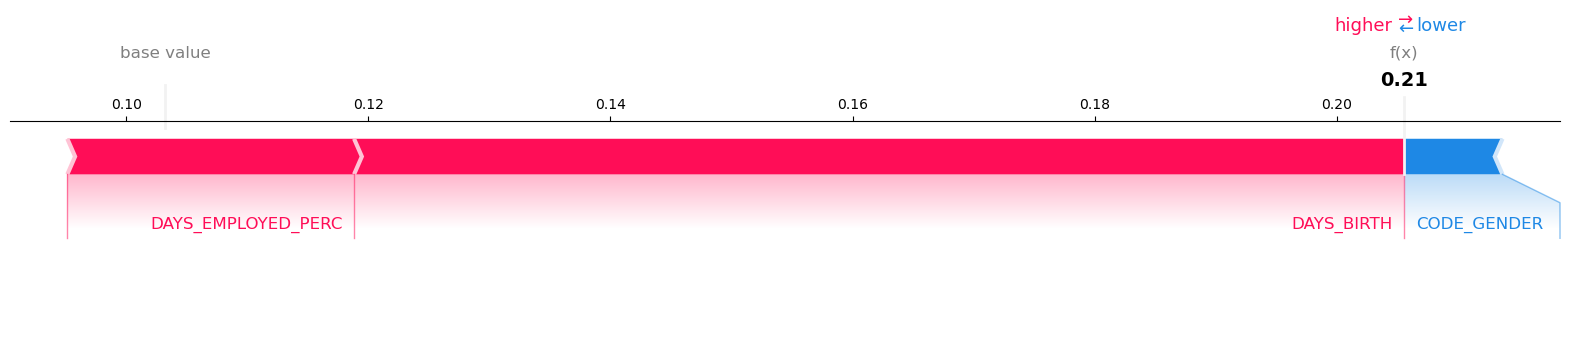

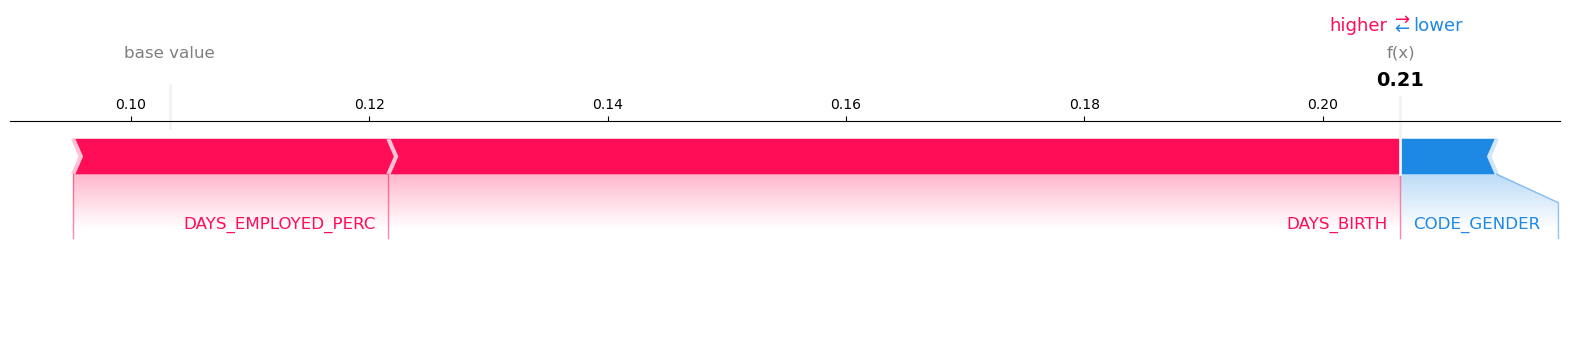

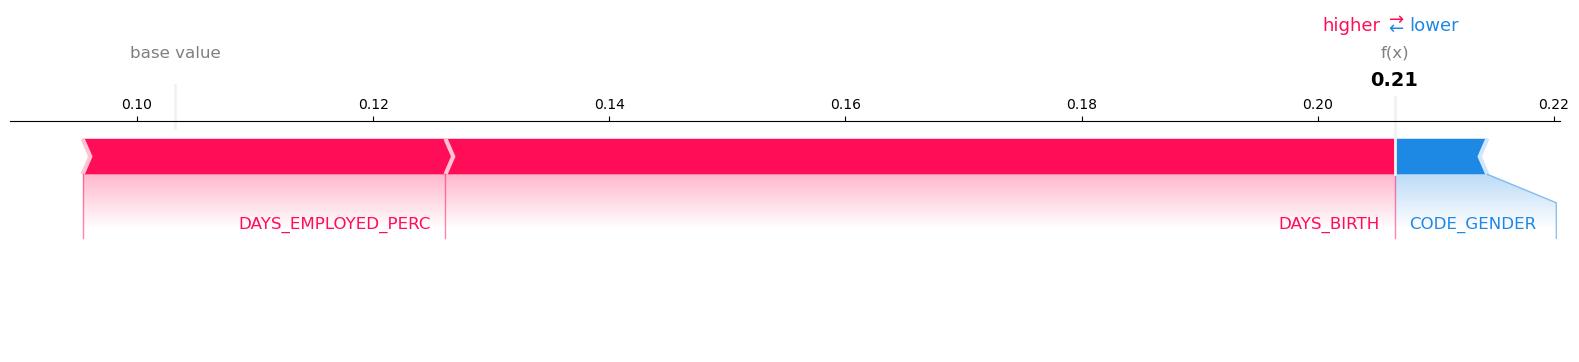

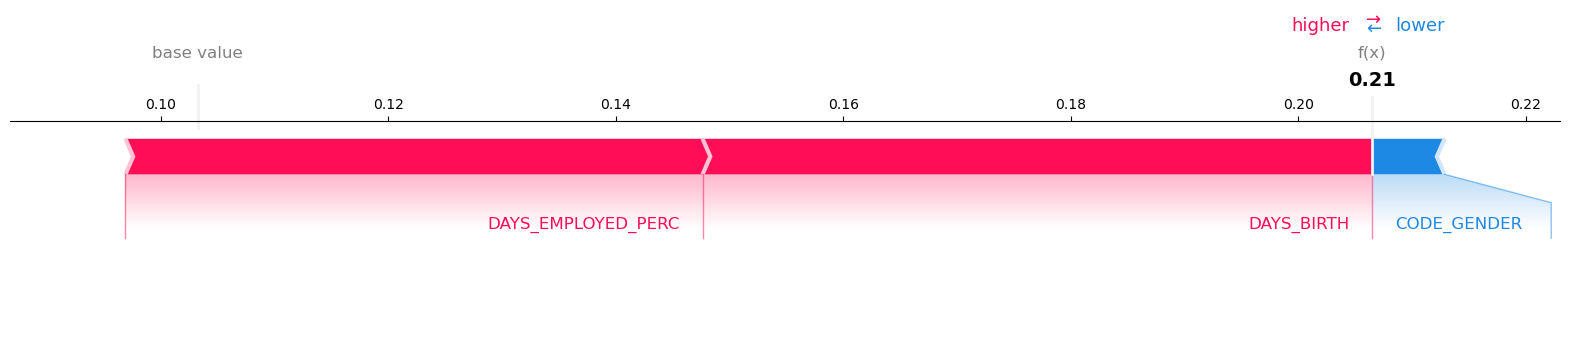

The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable beh

In [39]:
# On recherche les meilleurs hyperparamètres
param_grid_search = {
                     "imputer" : [SimpleImputer(strategy='median')],
                     "scaler" : [None, StandardScaler()],
                     "feature_selection__k" : k_selection, #(3 pendant le debug)
                     "sampler" : [None, NearMiss(), SMOTE(), SMOTEENN()],
                     "model__n_estimators" : [100, 1000], 
                     "model__max_depth" : [5, 7, 9]}

# On instancie le modèle
rfc = RandomForestClassifier(n_jobs = -1, random_state = 42)

# On ajoute en plus du nom du classifier
name = "RandomForestClassifier"

# On commence l'enregistrement mlflow 
with mlflow.start_run(run_name=name) as run:
    
    # On récupère les résultats après application de la fonction search_model_params
    results, model = search_model_params(name, rfc, param_grid_search, xtrain, ytrain, xtest, ytest, "DecisionTree")
    
    # On catalogue le dataset utilisé, les paramètres grids, les métriques produites et le modèle retenu      
    log_mlflow(param_grid_search, data, dataset_name, results, model)

# On ajoute à la liste de résultats des modèles
resultats_models.append([name] + list(results.values()))

### <a name = "T3C5">e. LogisticRegression</a>

Nous testons 64 hyperparamètres
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Cross-validation score : -194.30 % avec un écart-type de 9.86 % 




____________________________________________________________________________________________________
Meilleurs paramètres : {'feature_selection__k': 60, 'imputer': SimpleImputer(strategy='median'), 'model__C': 0.1, 'model__class_weight': None, 'model__max_iter': 1000, 'sampler': SMOTE(), 'scaler': StandardScaler()}
Temps de recherche des meilleurs paramètres : 44.8
Temps d'exécution : 6.4
____________________
Résultats sur échantillons d'entraînement :
Score performance : -190.37 %
Erreur : 28.44 %
ROC_AUC : 0.77
Fbeta-Score : 0.42 
____________________
Résultats sur échantillons de test :
Score performance : -210.77 %
Erreur : 30.13 %
ROC_AUC : 0.76
Precision moyenne : 0.56 
Recall moyen : 0.70 
F1-Score moyen : 0.54 
Fbeta-Score : 0.42 
________________________________________________________________________________________

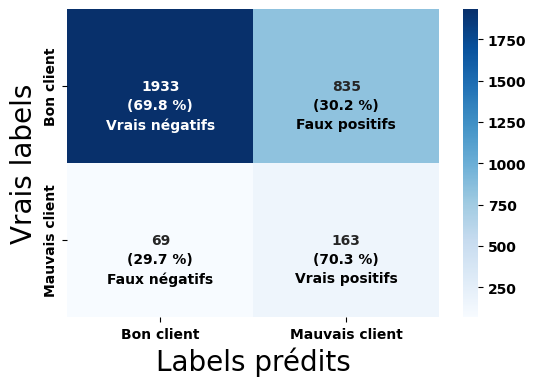

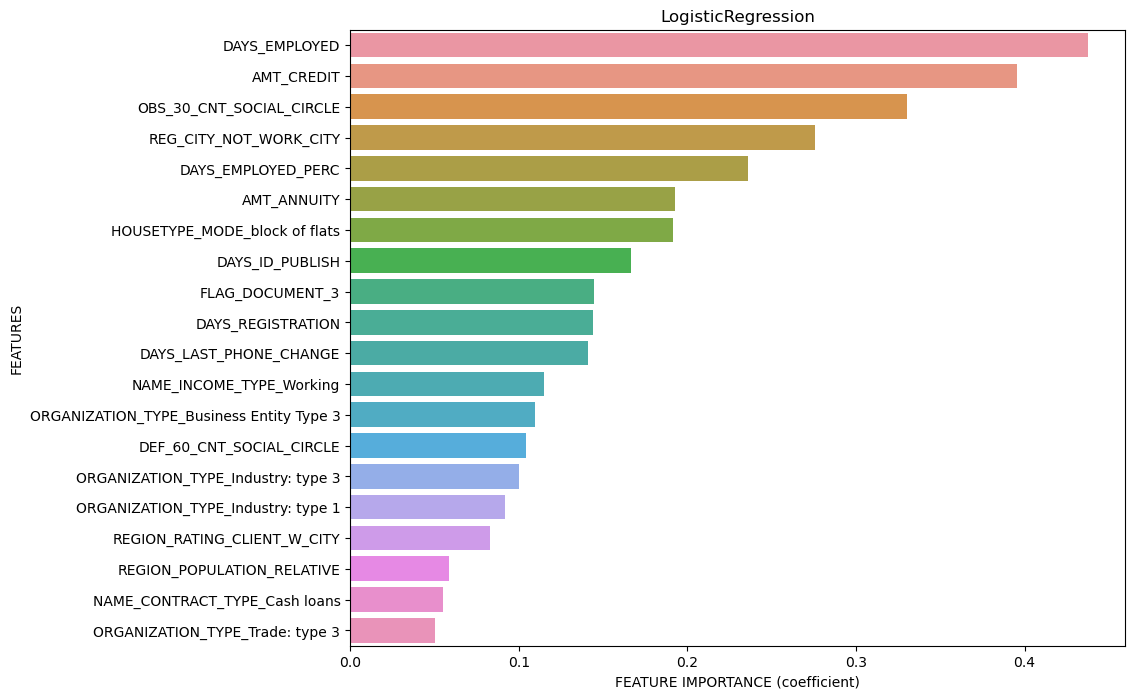

Utilisation de SHAP pour une explication indépendante des modèles
En quoi les variables contribue à un défaut de paiement :


C:\Users\33664\anaconda3\Lib\site-packages\shap\plots\_beeswarm.py:699: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



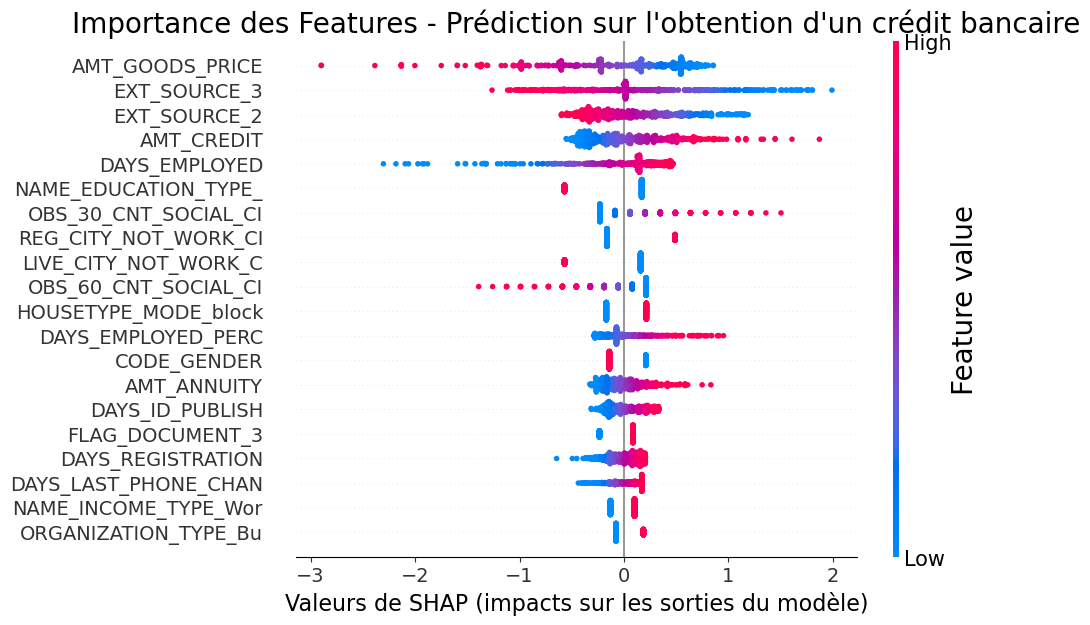

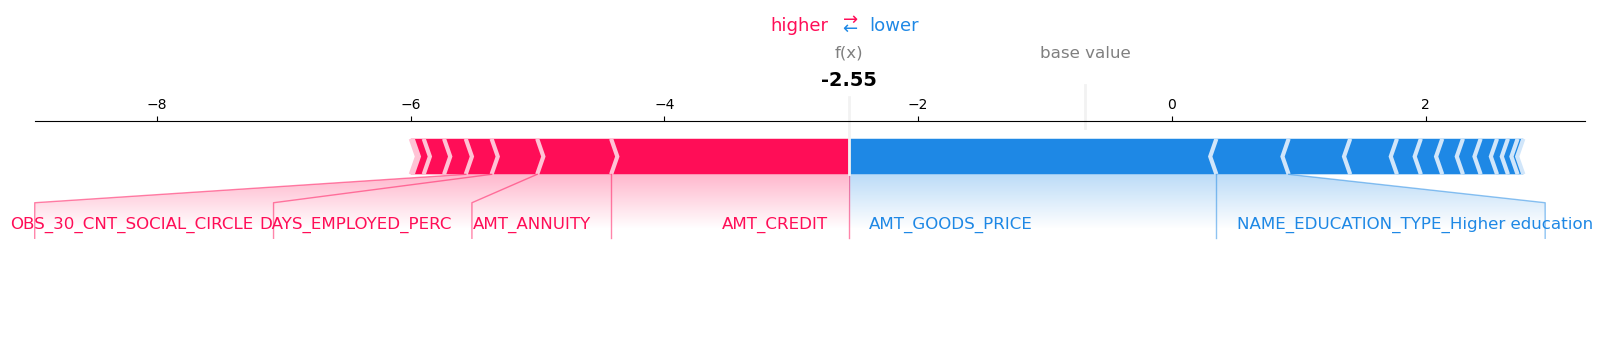

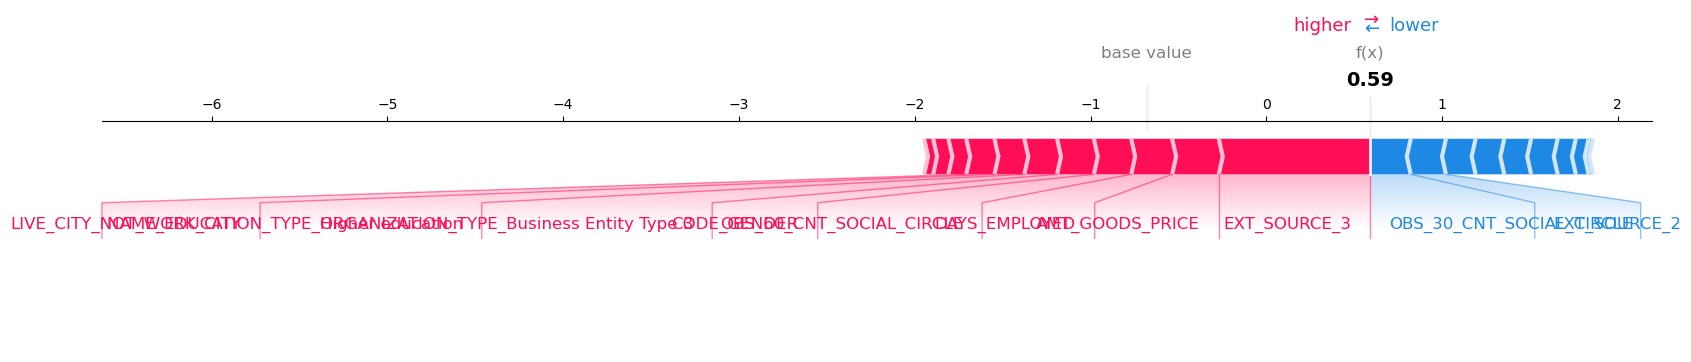

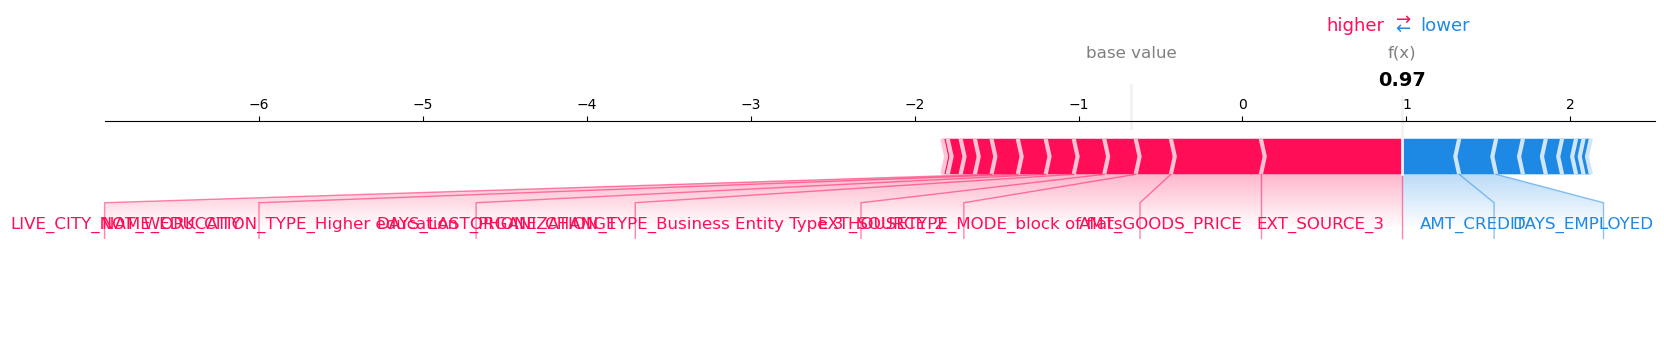

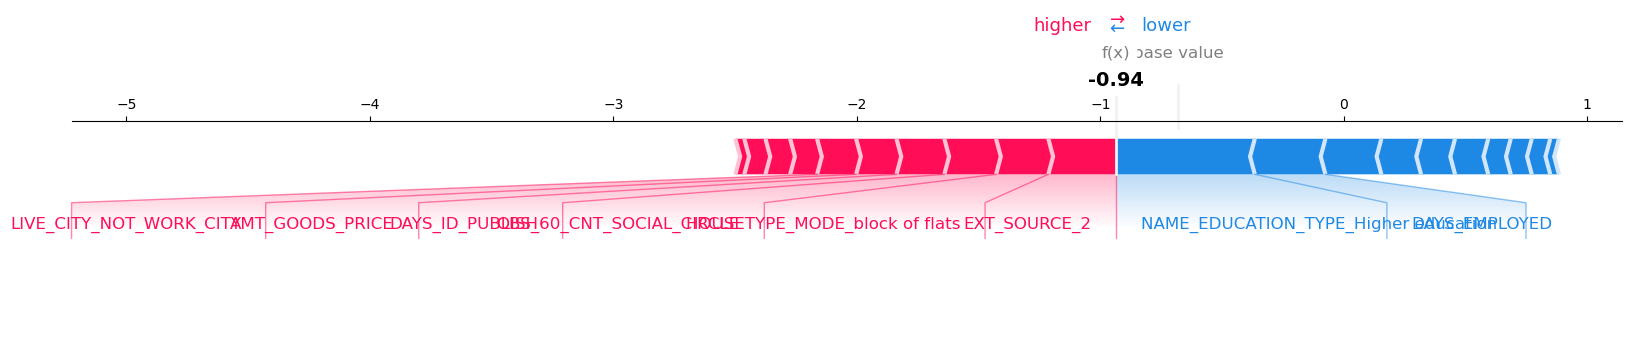

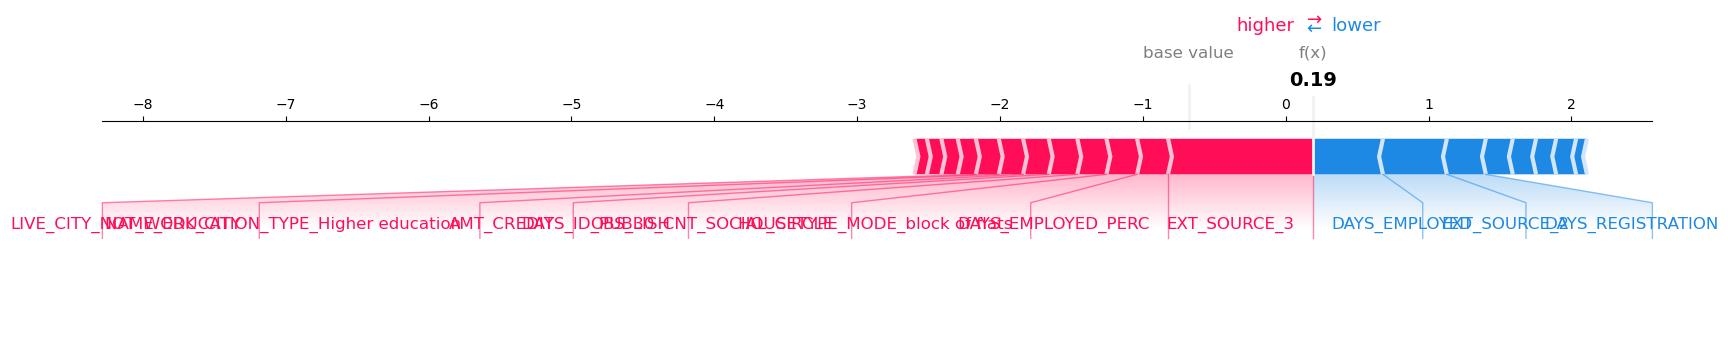

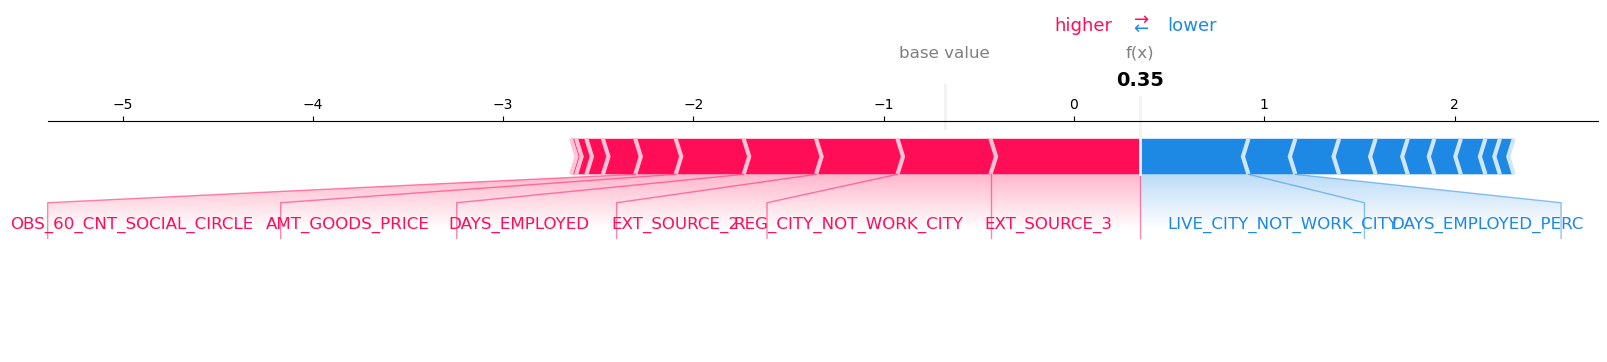

C:\Users\33664\anaconda3\Lib\site-packages\mlflow\data\dataset_source_registry.py:142: UserWarning:

The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.

C:\Users\33664\anaconda3\Lib\site-packages\mlflow\data\pandas_dataset.py:116: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-w

In [611]:
# On recherche les meilleurs hyperparamètres
param_grid_search = {
                     "imputer" : [SimpleImputer(strategy='median')],
                     "feature_selection__k" : k_selection, #(3 pendant le debug)
                     "scaler" : [None, StandardScaler()],
                     "sampler" : [None, NearMiss(), SMOTE(), SMOTEENN()],
                     "model__class_weight" : [None, {0:.1, 1:.9}], 
                     "model__C" : [0.1, 1],
                     "model__max_iter" : [100, 1000]}

# On instancie le modèle
modele_LR = LogisticRegression(n_jobs = -1, random_state = 42)

# On ajoute en plus du nom du classifier
name = "LogisticRegression"

# On commence l'enregistrement mlflow 
with mlflow.start_run(run_name=name) as run:
    
    # On récupère les résultats après application de la fonction search_model_params
    results, model = search_model_params(name, modele_LR, param_grid_search, xtrain, ytrain, xtest, ytest, "Regression")
    
   # On catalogue le dataset utilisé, les paramètres grids, les métriques produites et le modèle retenu    
    log_mlflow(param_grid_search, data, dataset_name, results, model)

# On ajoute à la liste de résultats des modèles
resultats_models.append([name] + list(results.values()))

### <a name = "T3C6">f. SGDClassifier</a>

Nous testons 128 hyperparamètres
Fitting 5 folds for each of 128 candidates, totalling 640 fits
Cross-validation score : -207.23 % avec un écart-type de 19.02 % 




____________________________________________________________________________________________________
Meilleurs paramètres : {'feature_selection__k': 40, 'imputer': SimpleImputer(strategy='median'), 'model__alpha': 0.001, 'model__max_iter': 1000, 'model__penalty': 'l1', 'sampler': SMOTE(), 'scaler': StandardScaler()}
Temps de recherche des meilleurs paramètres : 62.3
Temps d'exécution : 1.2
____________________
Résultats sur échantillons d'entraînement :
Score performance : -215.79 %
Erreur : 30.67 %
ROC_AUC : 0.75
Fbeta-Score : 0.41 
____________________
Résultats sur échantillons de test :
Score performance : -230.37 %
Erreur : 31.83 %
ROC_AUC : 0.75
Precision moyenne : 0.56 
Recall moyen : 0.70 
F1-Score moyen : 0.53 
Fbeta-Score : 0.42 
____________________________________________________________________________________

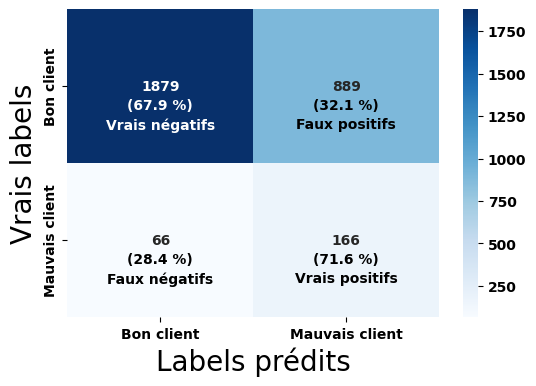

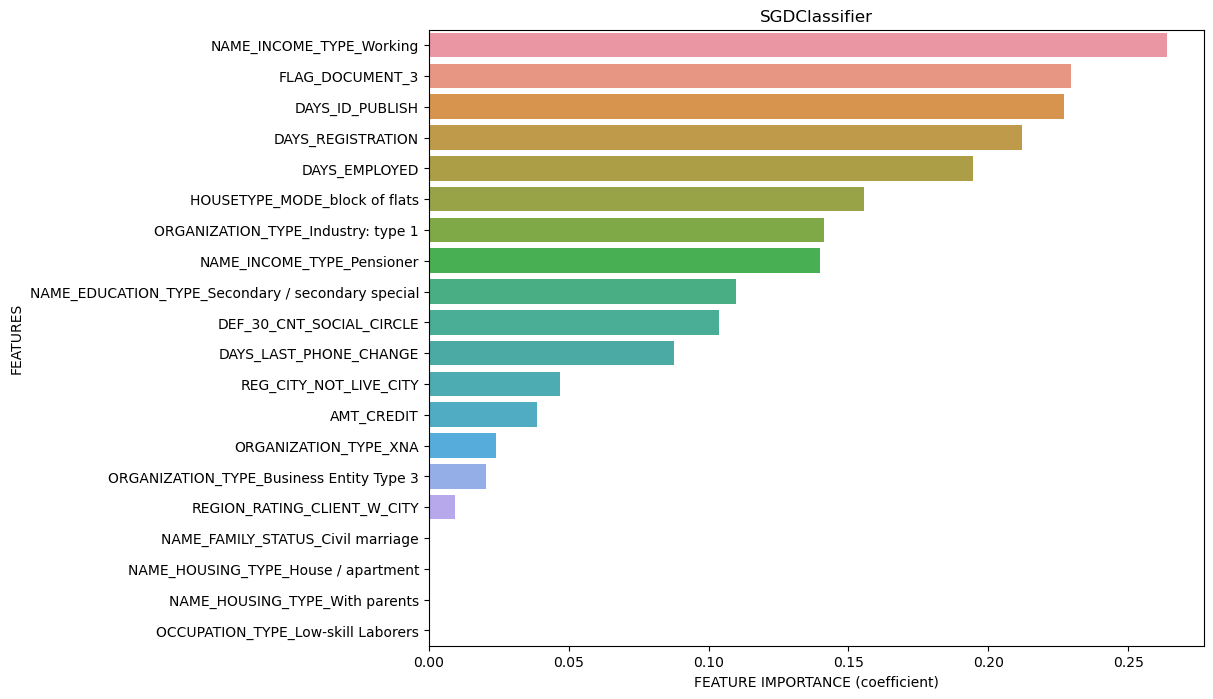

Utilisation de SHAP pour une explication indépendante des modèles
En quoi les variables contribue à un défaut de paiement :


C:\Users\33664\anaconda3\Lib\site-packages\shap\plots\_beeswarm.py:699: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



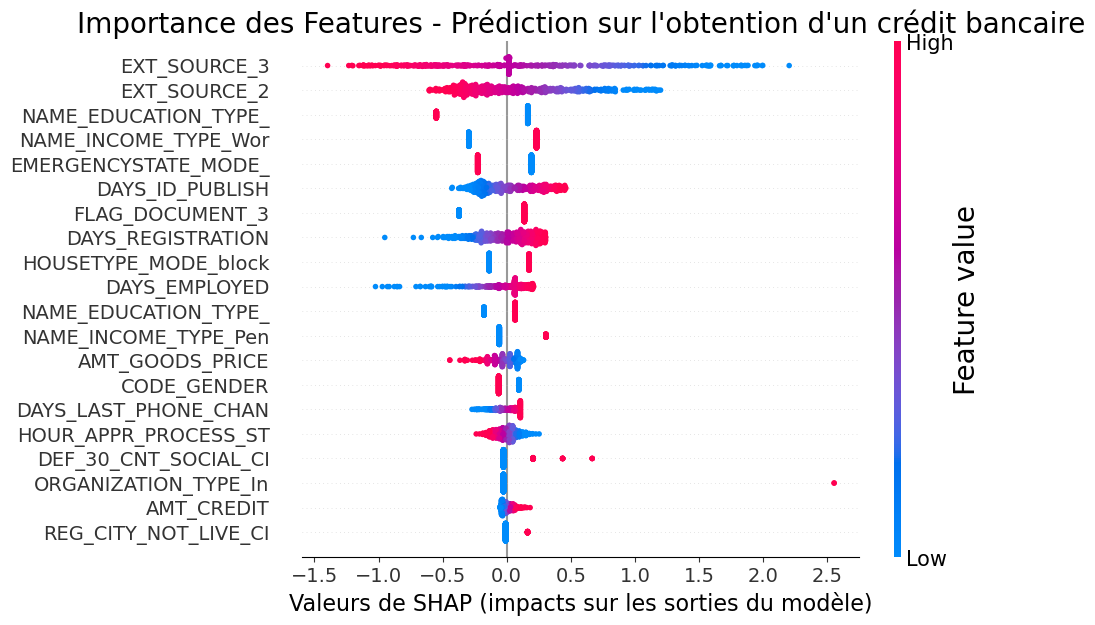

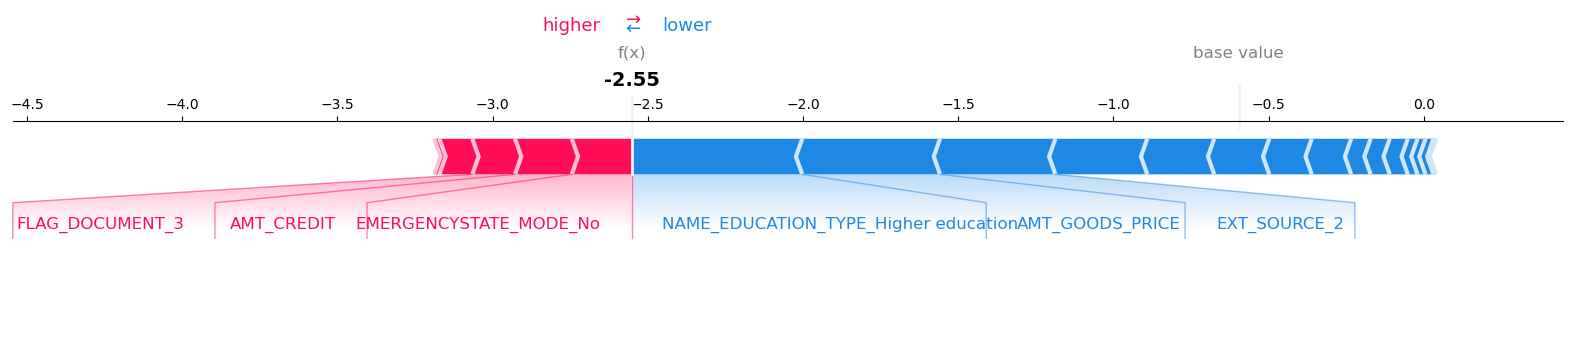

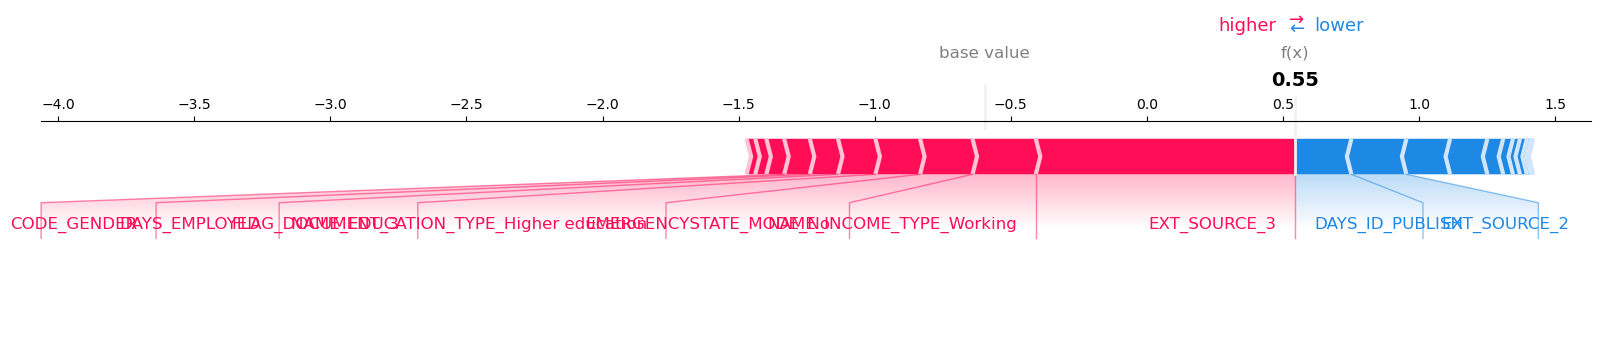

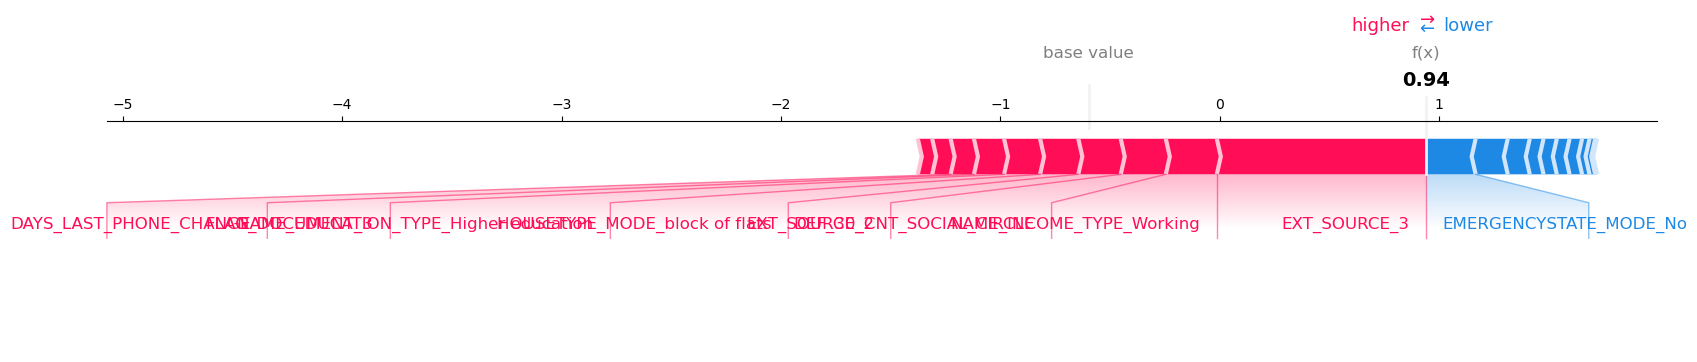

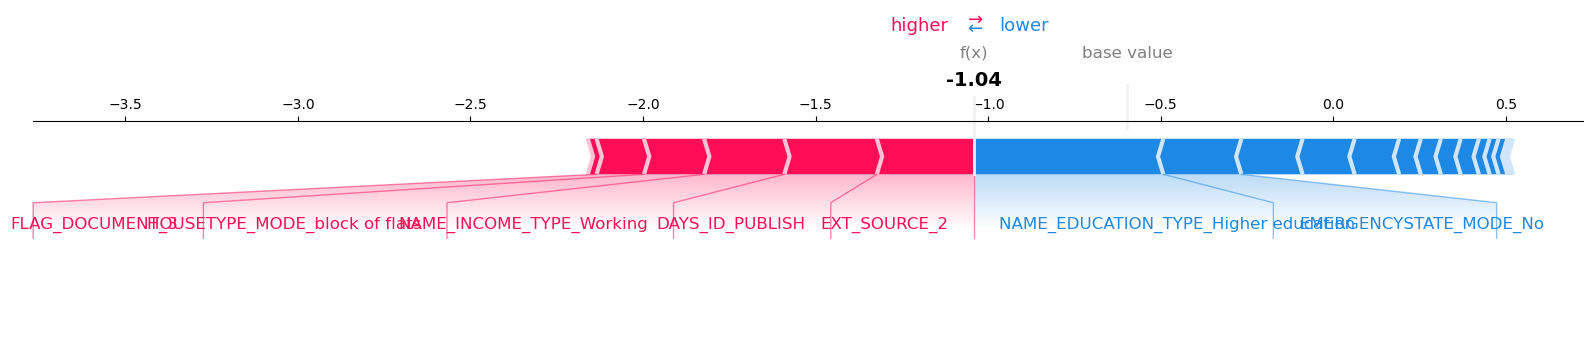

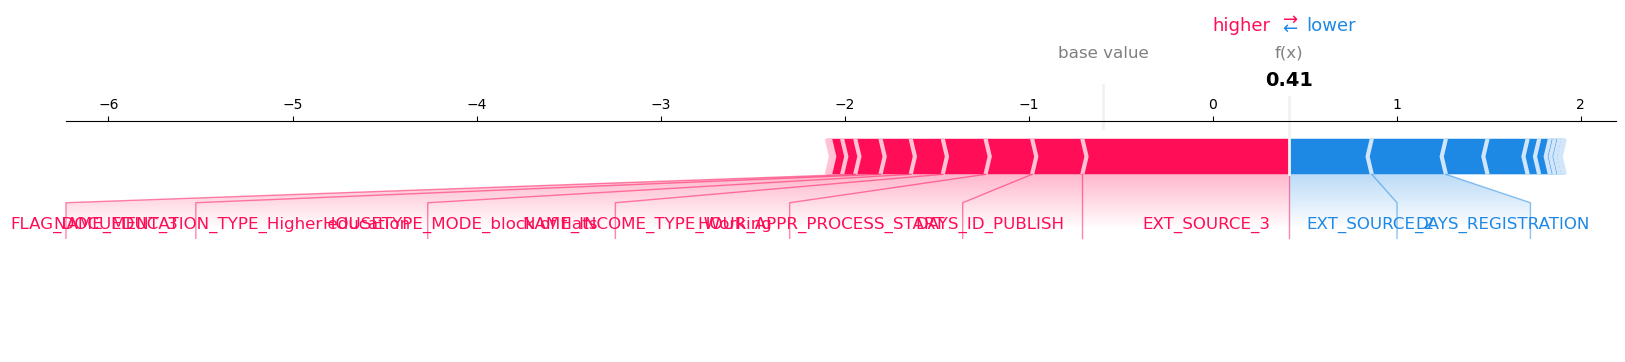

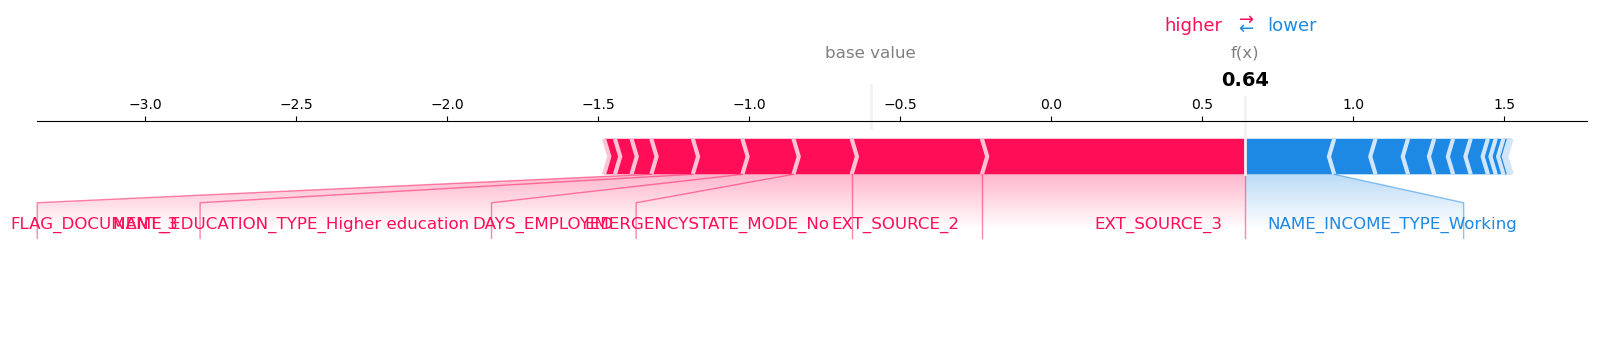

C:\Users\33664\anaconda3\Lib\site-packages\mlflow\data\dataset_source_registry.py:142: UserWarning:

The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.

C:\Users\33664\anaconda3\Lib\site-packages\mlflow\data\pandas_dataset.py:116: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-w

In [612]:
# On recherche les meilleurs hyperparamètres
param_grid_search = {
                     "imputer" : [SimpleImputer(strategy="median")],# SimpleImputer(strategy="mean")],
                     "feature_selection__k" : k_selection, #(3 pendant le debug, 10 ou 20 sinon)
                     "scaler" : [None, StandardScaler()],#, RobustScaler()],
                     "sampler" : [None, NearMiss(), SMOTE(), SMOTEENN()],
                     "model__alpha": [0.0001, 0.001],
                     "model__penalty": ["l1", "l2"],
                     "model__max_iter": [200, 1000], 
                     }

# On instancie le modèle
modele_SVC = SGDClassifier(loss="log_loss", early_stopping = True, n_jobs = -1, random_state = 42)

# On ajoute en plus du nom du classifier
name = "SGDClassifier"

# On commence l"enregistrement mlflow 
with mlflow.start_run(run_name=name) as run:
    
    # On récupère les résultats après application de la fonction search_model_params
    results, model = search_model_params(name, modele_SVC, param_grid_search, xtrain, ytrain, xtest, ytest, "Regression")
    
   # On catalogue le dataset utilisé, les paramètres grids, les métriques produites et le modèle retenu      
    log_mlflow(param_grid_search, data, dataset_name, results, model)

# On ajoute à la liste de résultats des modèles
resultats_models.append([name] + list(results.values()))

### <a name = "T3C7">g. GradientBoostingClassifier</a>

Nous testons 96 hyperparamètres
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Cross-validation score : -811.84 % avec un écart-type de 1.96 % 




____________________________________________________________________________________________________
Meilleurs paramètres : {'scaler': StandardScaler(), 'sampler': NearMiss(), 'model__n_estimators': 200, 'model__min_samples_split': 5, 'model__max_depth': 3, 'model__learning_rate': 0.1, 'imputer': SimpleImputer(strategy='median'), 'feature_selection__k': 3}
Temps de recherche des meilleurs paramètres : 66.2
Temps d'exécution : 1.3
____________________
Résultats sur échantillons d'entraînement :
Score performance : -820.00 %
Erreur : 83.93 %
ROC_AUC : 0.58
Fbeta-Score : 0.30 
____________________
Résultats sur échantillons de test :
Score performance : -830.70 %
Erreur : 84.80 %
ROC_AUC : 0.63
Precision moyenne : 0.53 
Recall moyen : 0.53 
F1-Score moyen : 0.15 
Fbeta-Score : 0.30 
______________________________________________

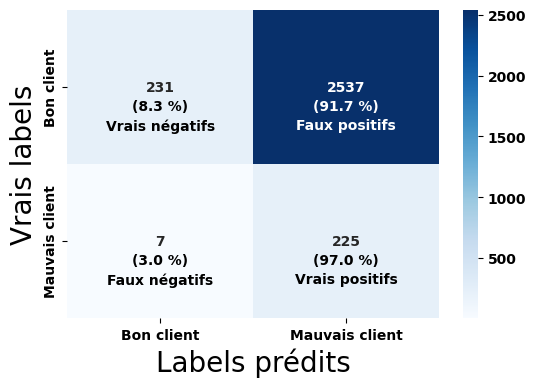

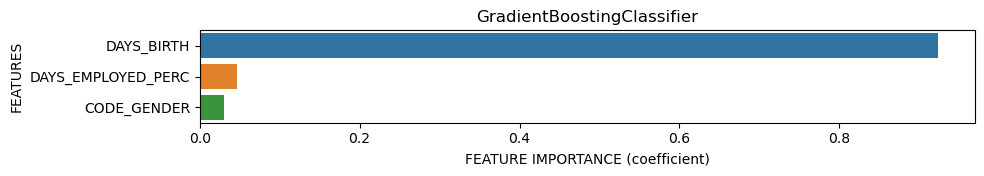

Utilisation de SHAP pour une explication indépendante des modèles
En quoi les variables contribue à un défaut de paiement :


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


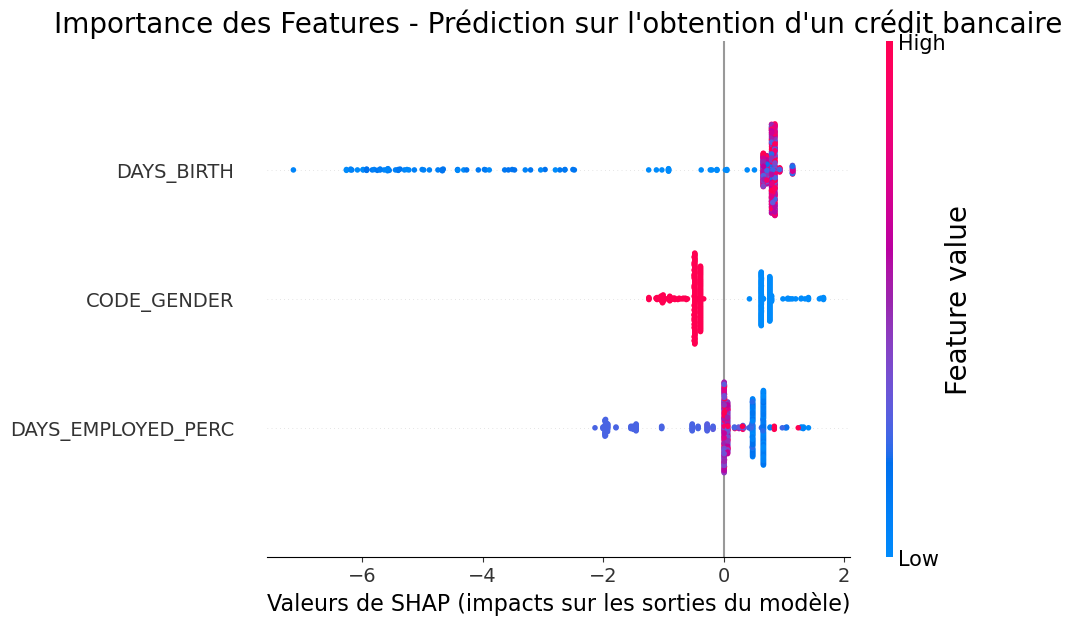

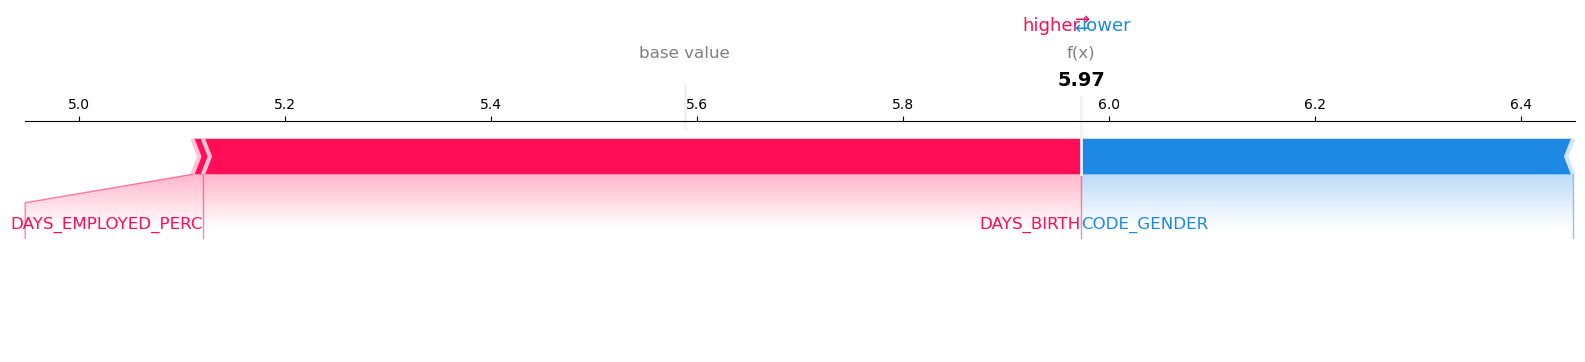

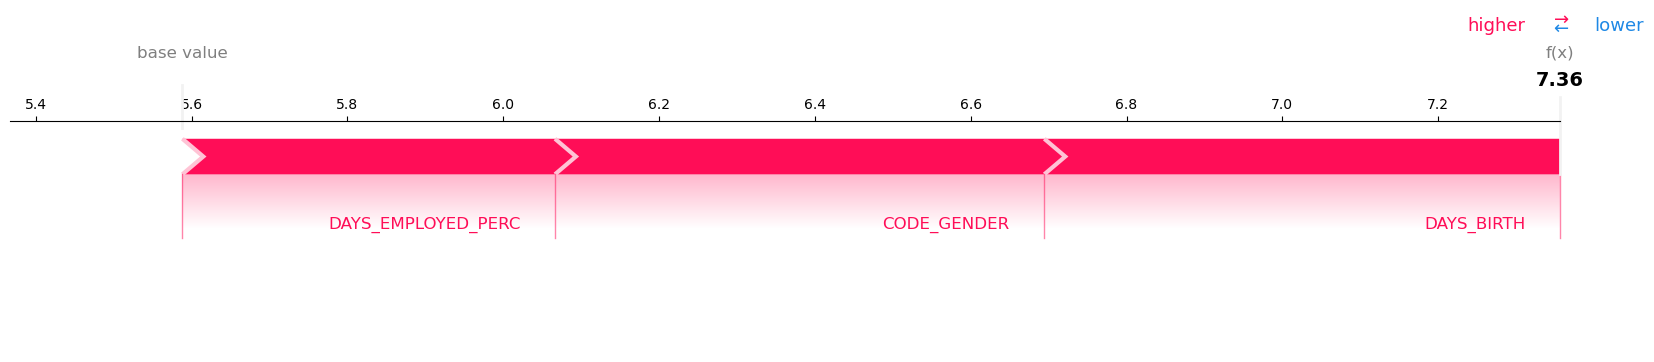

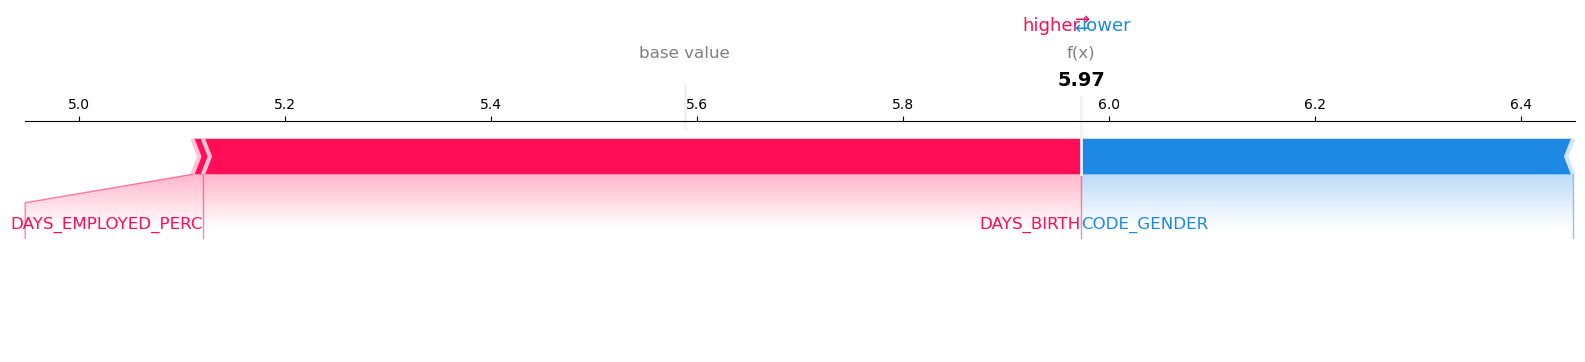

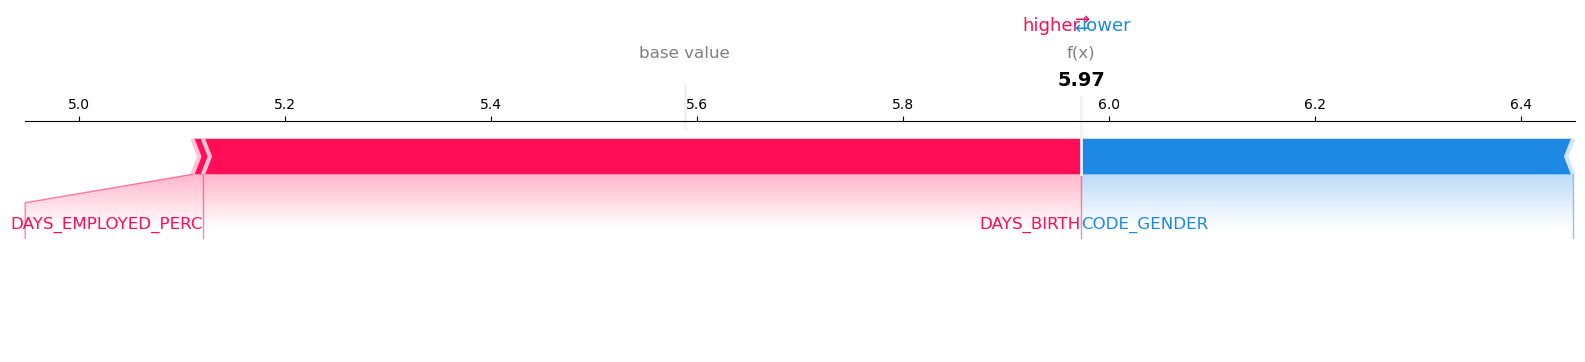

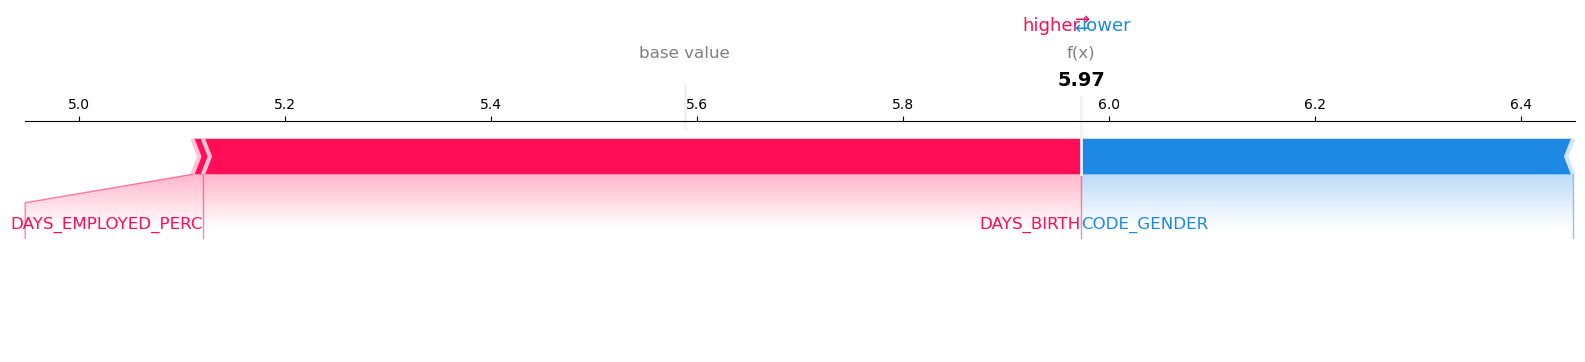

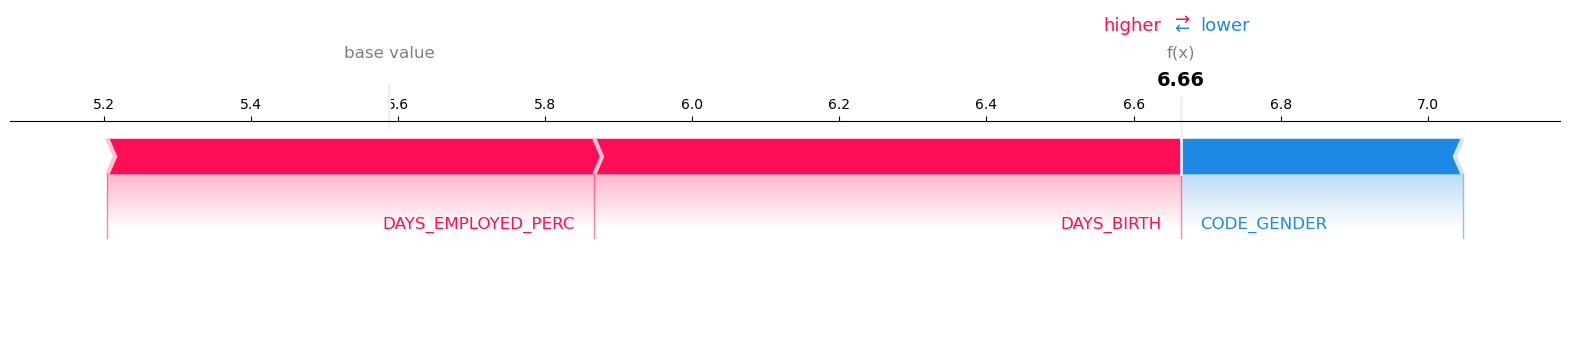

The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable beh

In [42]:
# On recherche les meilleurs hyperparamètres
param_grid_search = {
                     "imputer" : [SimpleImputer(strategy='median')],
                     "feature_selection__k" : k_selection, #(3 pendant le debug)
                     "scaler" : [None, StandardScaler()],,
                    "sampler" : [None, NearMiss(), SMOTE(), SMOTEENN()],
                    'model__n_estimators': [100, 200],
                    'model__max_depth': [3, 7],
                    'model__min_samples_split': [2, 5],
                    'model__learning_rate' : [0.1, 1]}

# On instancie le modèle
modele_GB = GradientBoostingClassifier(random_state = 42)

# On ajoute en plus du nom du classifier
name = "GradientBoostingClassifier"

# On commence l'enregistrement mlflow 
with mlflow.start_run(run_name=name) as run:

    # On récupère les résultats après application de la fonction search_model_params
    results, model = search_model_params(name, modele_GB, param_grid_search, xtrain, ytrain, xtest, ytest, "DecisionTree")
    
    # On catalogue le dataset utilisé, les paramètres grids, les métriques produites et le modèle retenu   
    log_mlflow(param_grid_search, data, dataset_name, results, model)

# On ajoute à la liste de résultats des modèles
resultats_models.append([name] + list(results.values()))

### <a name = "T3C8">h. XGBClassifier</a>

Nous testons 96 hyperparamètres
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Cross-validation score : -348.34 % avec un écart-type de 7.64 % 




____________________________________________________________________________________________________
Meilleurs paramètres : {'scaler': StandardScaler(), 'sampler': SMOTEENN(), 'model__n_estimators': 100, 'model__max_depth': 3, 'model__eta': 0.01, 'imputer': SimpleImputer(strategy='median'), 'feature_selection__k': 40}
Temps de recherche des meilleurs paramètres : 160.0
Temps d'exécution : 3.2
____________________
Résultats sur échantillons d'entraînement :
Score performance : -331.33 %
Erreur : 40.87 %
ROC_AUC : 0.72
Fbeta-Score : 0.38 
____________________
Résultats sur échantillons de test :
Score performance : -344.50 %
Erreur : 42.10 %
ROC_AUC : 0.7
Precision moyenne : 0.54 
Recall moyen : 0.65 
F1-Score moyen : 0.46 
Fbeta-Score : 0.37 
_____________________________________________________________________________________

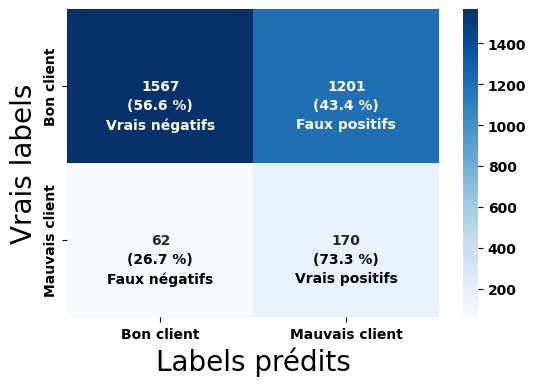

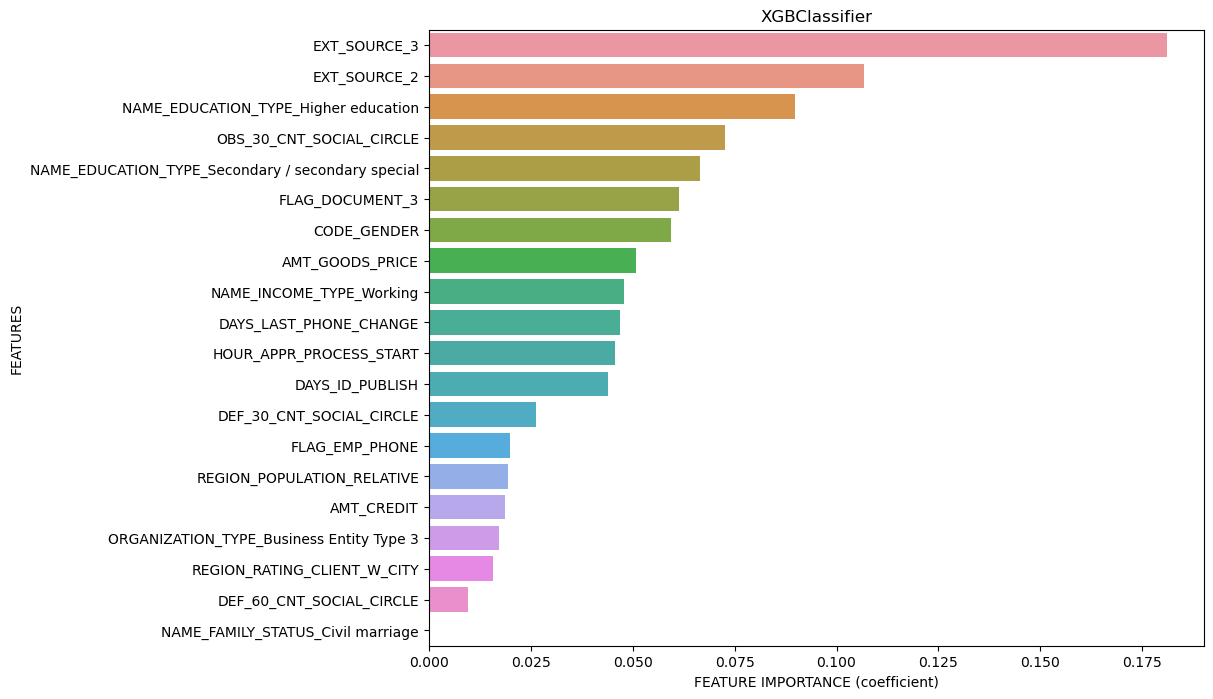

Utilisation de SHAP pour une explication indépendante des modèles
En quoi les variables contribue à un défaut de paiement :


C:\Users\33664\anaconda3\Lib\site-packages\shap\plots\_beeswarm.py:699: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



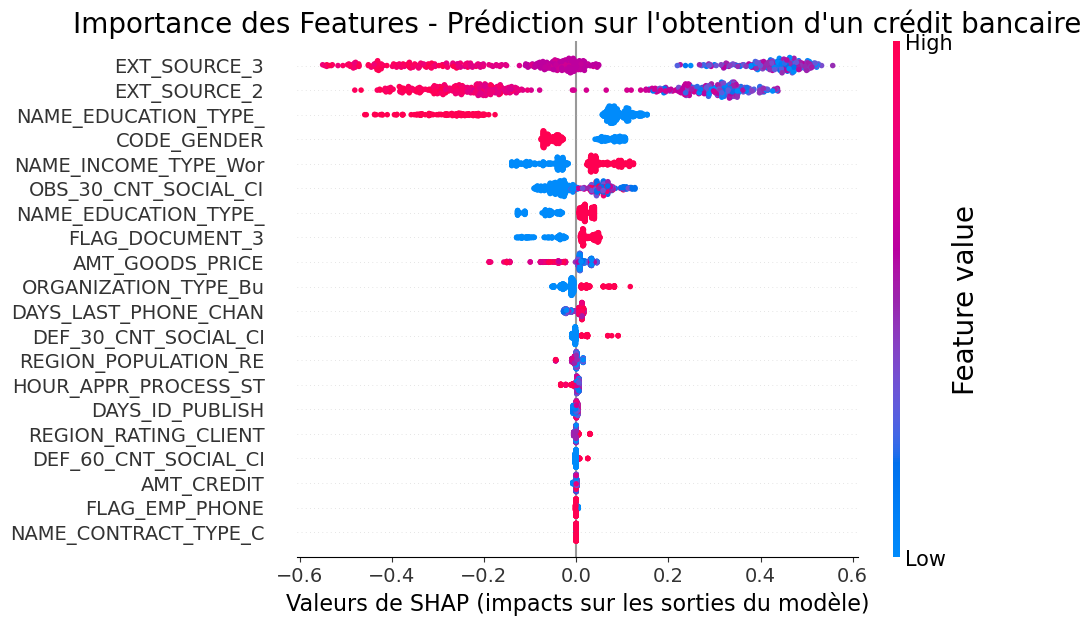

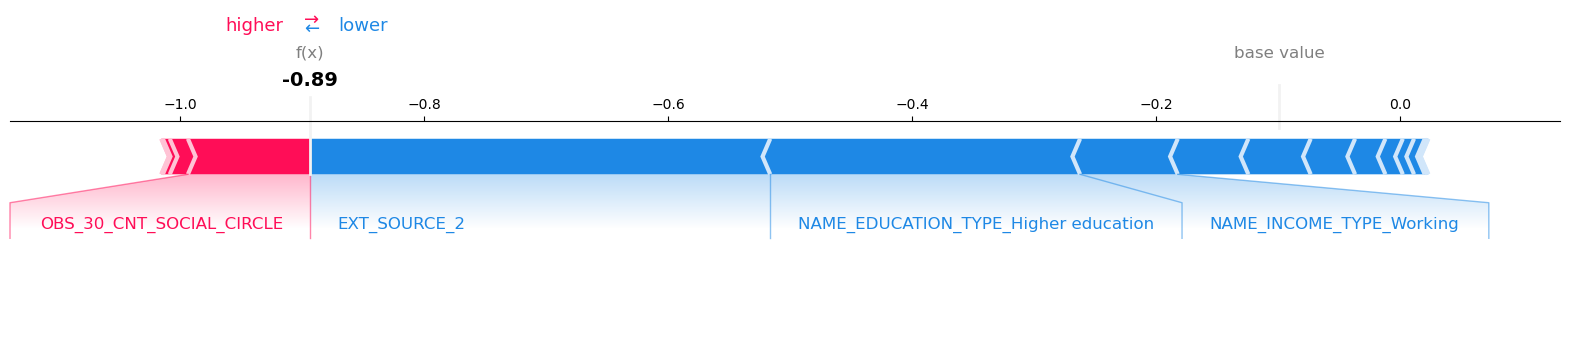

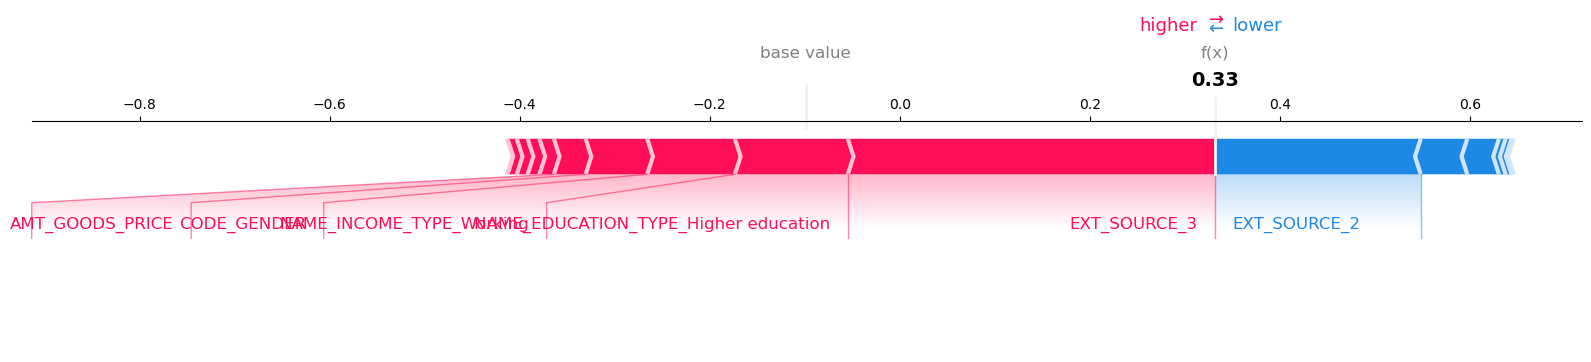

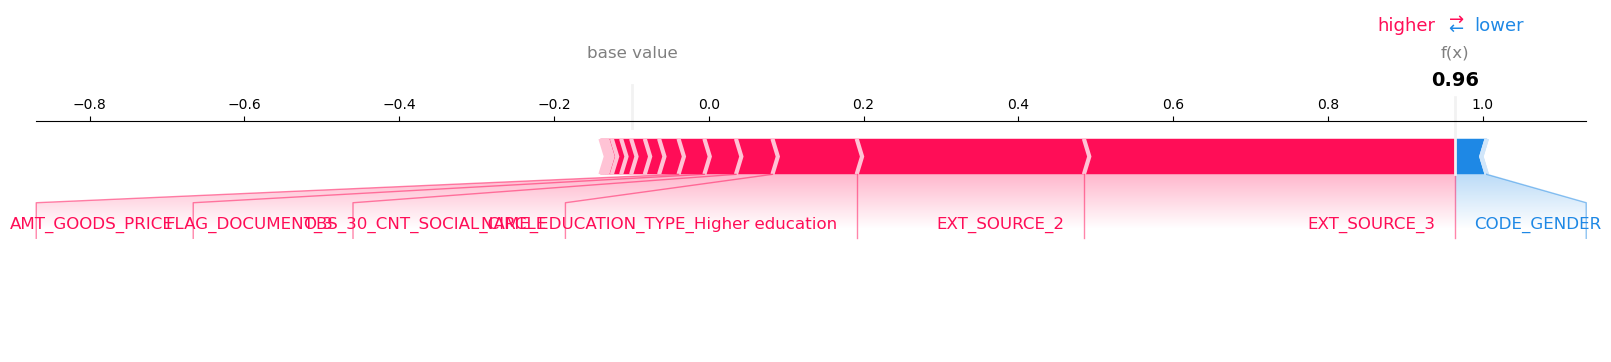

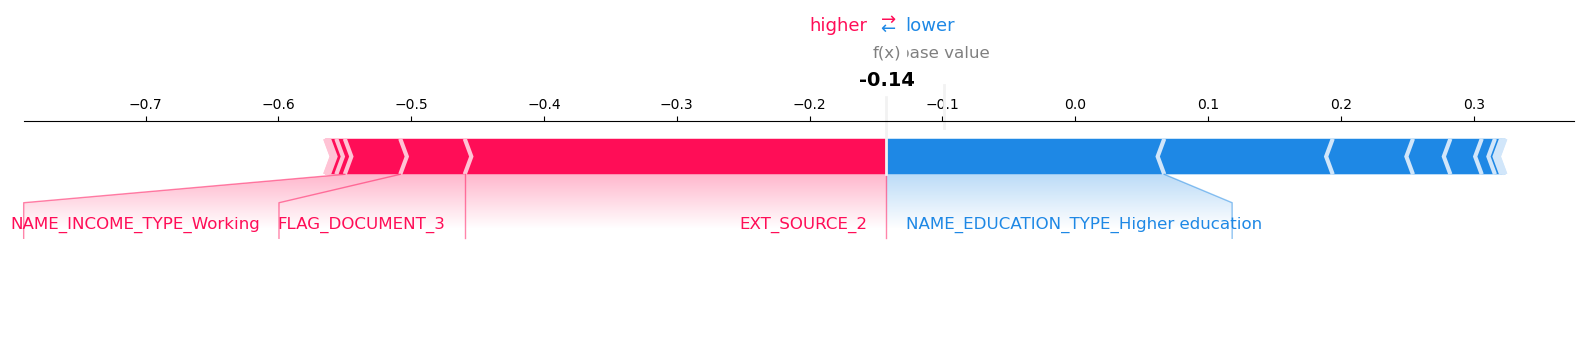

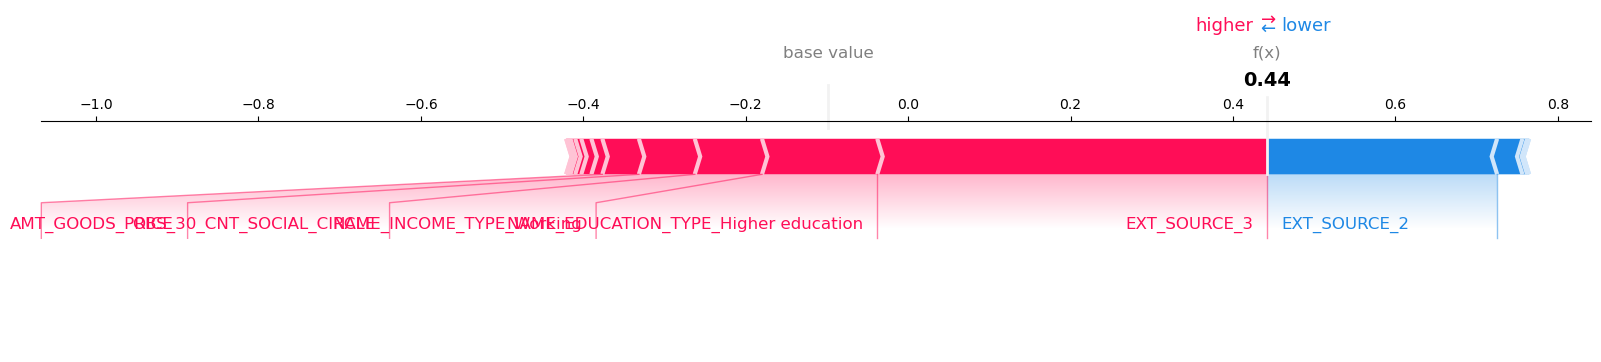

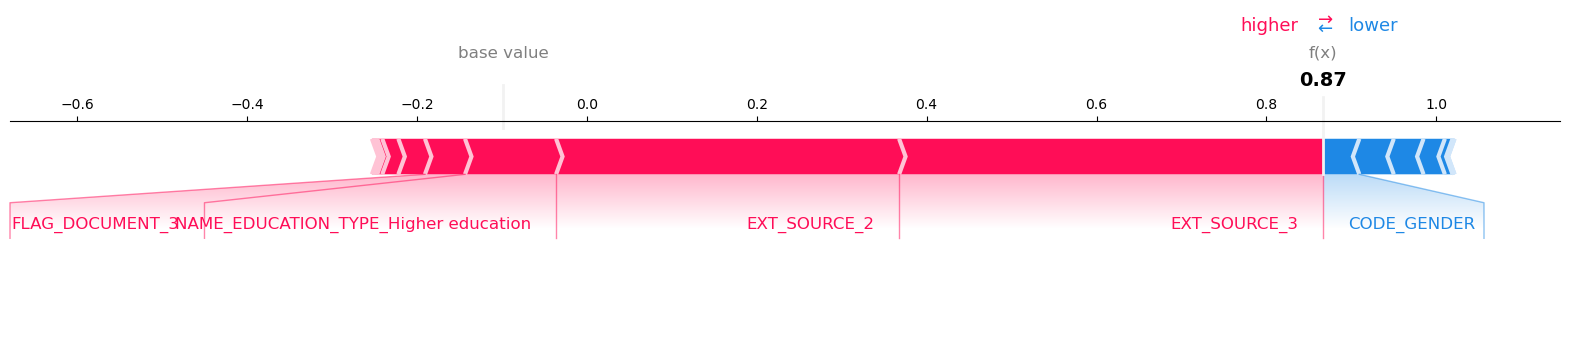

C:\Users\33664\anaconda3\Lib\site-packages\mlflow\data\dataset_source_registry.py:142: UserWarning:

The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.

C:\Users\33664\anaconda3\Lib\site-packages\mlflow\data\pandas_dataset.py:116: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-w

In [613]:
# On recherche les meilleurs hyperparamètres
param_grid_search = {
                     "imputer" : [SimpleImputer(strategy='median')],
                     "feature_selection__k" : k_selection, #(3 pendant le debug)
                     "scaler" : [None, StandardScaler()],
                     "sampler" : [None, NearMiss(), SMOTE(), SMOTEENN()],
                    'model__n_estimators': [100, 200],
                    'model__max_depth': [3, 7],
                    'model__eta' : [0.01, 0.1]}

# On instancie le modèle
modele_XGB = XGBClassifier(random_state = 42)

# On ajoute en plus du nom du classifier
name = "XGBClassifier"

# On commence l'enregistrement mlflow 
with mlflow.start_run(run_name=name) as run:

    # On récupère les résultats après application de la fonction search_model_params
    results, model = search_model_params(name, modele_XGB, param_grid_search, xtrain, ytrain, xtest, ytest, "DecisionTree")
    
    # On catalogue le dataset utilisé, les paramètres grids, les métriques produites et le modèle retenu  
    log_mlflow(param_grid_search, data, dataset_name, results, model)

# On ajoute à la liste de résultats des modèles
resultats_models.append([name] + list(results.values()))

### <a name = "T3C9">g. LightGBM</a>

Nous testons 216 hyperparamètres
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Cross-validation score : -765.36 % avec un écart-type de 9.79 % 




____________________________________________________________________________________________________
Meilleurs paramètres : {'scaler': StandardScaler(), 'sampler': NearMiss(), 'model__num_leaves': 100, 'model__n_estimators': 200, 'model__max_depth': -1, 'model__learning_rate': 0.01, 'model__boosting_type': 'gbdt', 'imputer': SimpleImputer(strategy='median'), 'feature_selection__k': 3}
Temps de recherche des meilleurs paramètres : 47.0
Temps d'exécution : 0.6
____________________
Résultats sur échantillons d'entraînement :
Score performance : -769.39 %
Erreur : 79.64 %
ROC_AUC : 0.56
Fbeta-Score : 0.30 
____________________
Résultats sur échantillons de test :
Score performance : -764.53 %
Erreur : 78.87 %
ROC_AUC : 0.6
Precision moyenne : 0.53 
Recall moyen : 0.55 
F1-Score moyen : 0.21 
Fbeta-Score : 0.32 
_______________

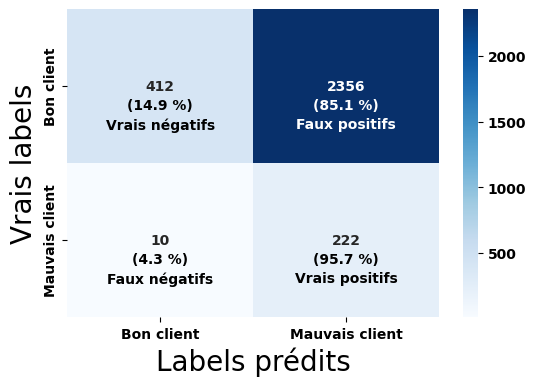

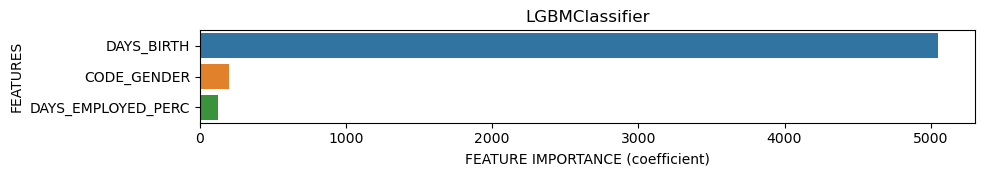

Utilisation de SHAP pour une explication indépendante des modèles
En quoi les variables contribue à un défaut de paiement :


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


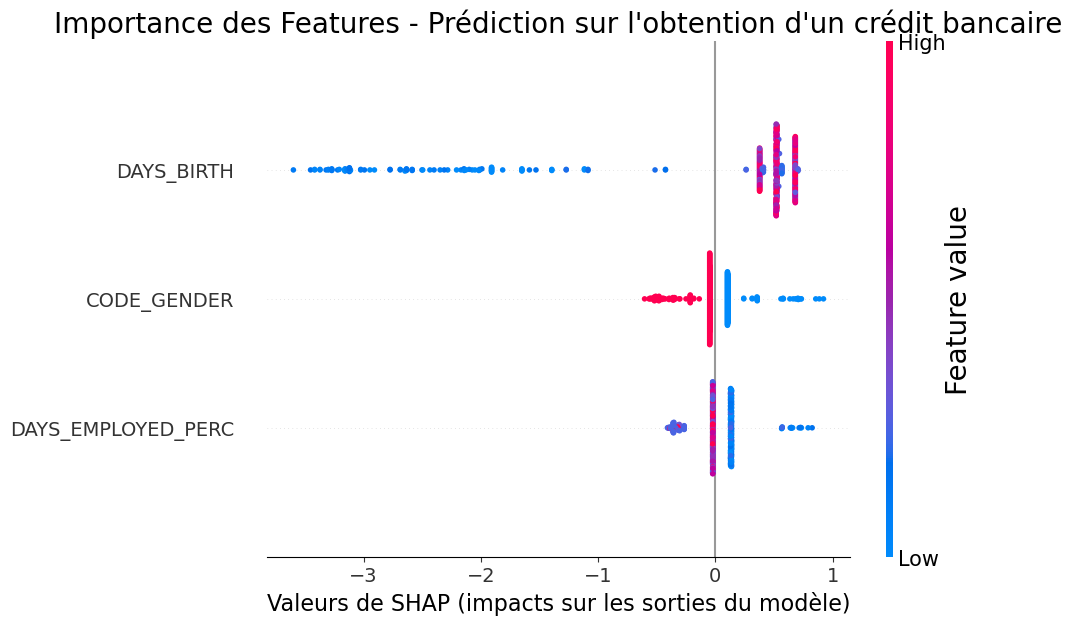

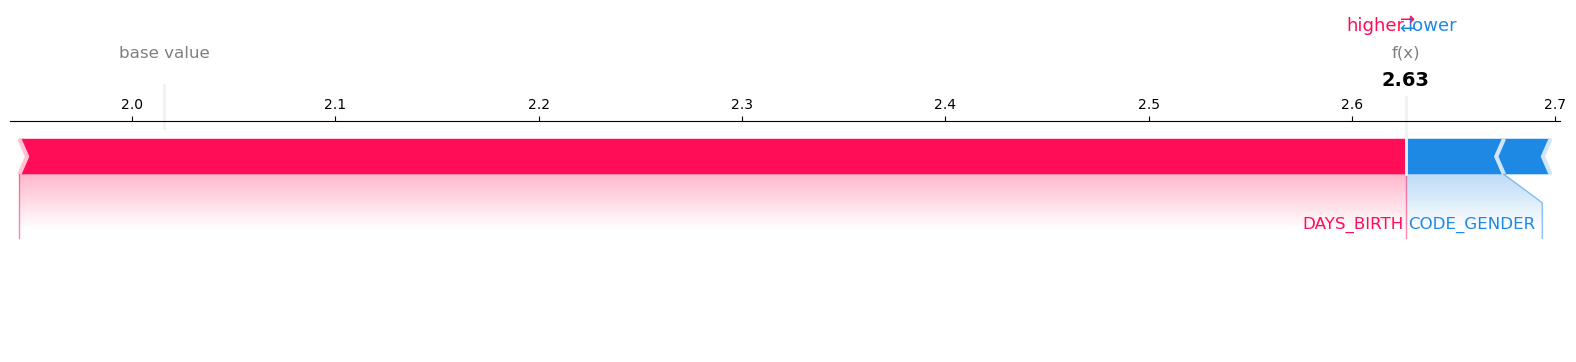

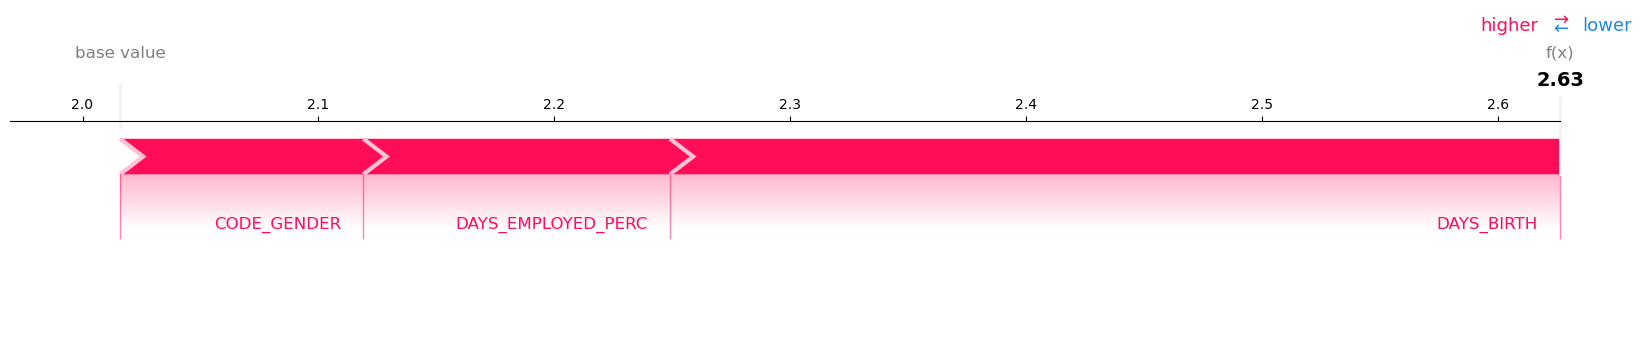

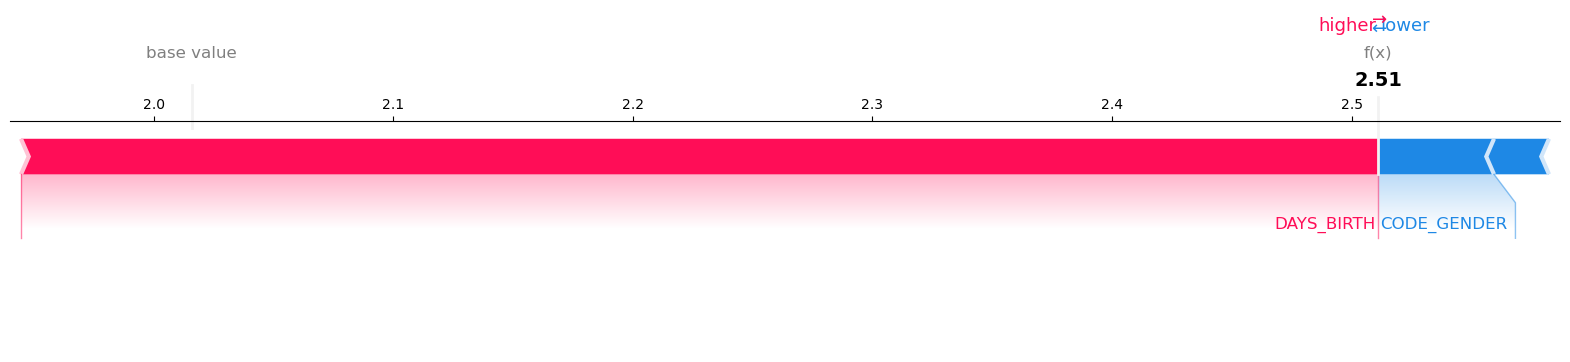

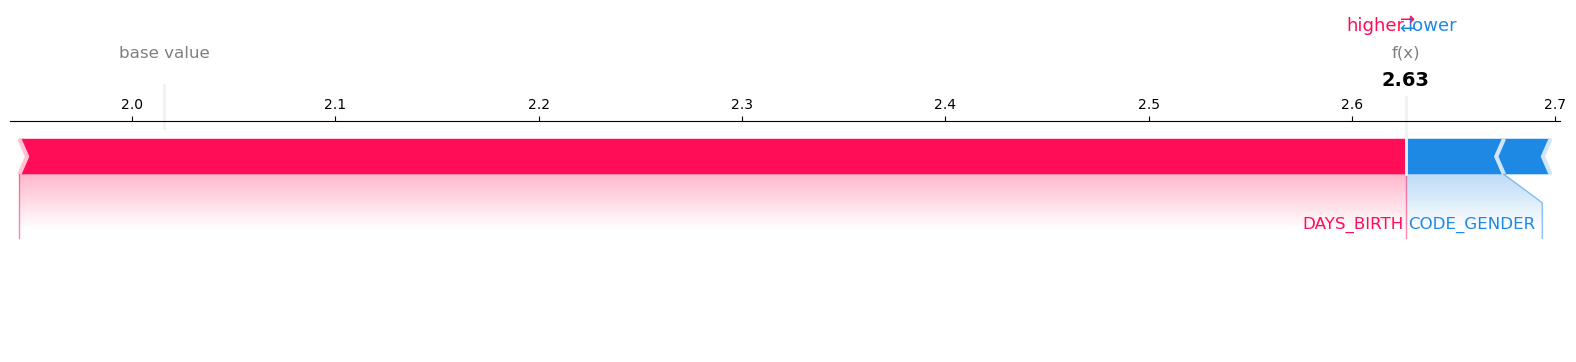

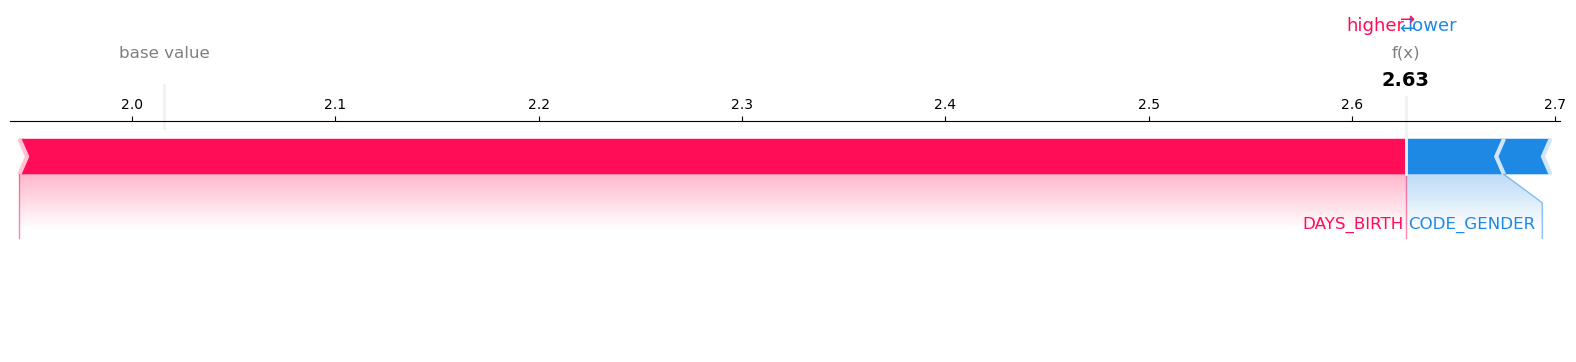

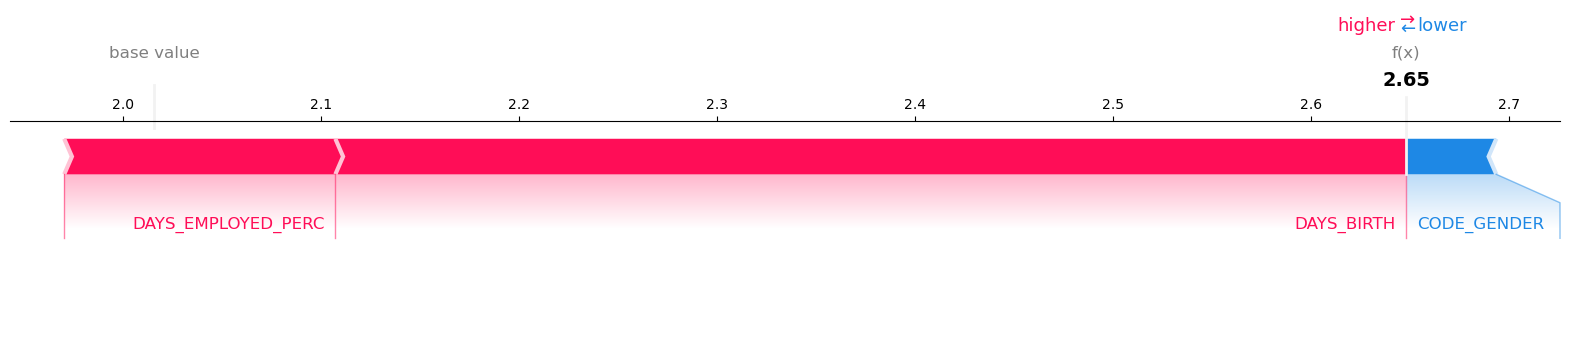

The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable beh

In [44]:
# On recherche les meilleurs hyperparamètres
param_grid_search = {
                     "imputer" : [SimpleImputer(strategy="median")],
                     "feature_selection__k" : k_selection, 
                     "scaler" : [None, StandardScaler()],
                     "sampler" : [None, NearMiss(), SMOTE(), SMOTEENN()],
                    "model__boosting_type": ["gbdt"],
                    "model__num_leaves": [31, 50, 100],
                    "model__learning_rate": [0.01, 0.1],
                    "model__n_estimators": [100, 200],
                    "model__max_depth" : [-1, 3, 8]
                    }

# On instancie le modèle
modele_lgbm = LGBMClassifier(verbose=-100,
                             objective = "binary",
                             random_state = 42)

# On ajoute en plus du nom du classifier
name = "LGBMClassifier"

# On commence l"enregistrement mlflow 
with mlflow.start_run(run_name=name) as run:

    # On récupère les résultats après application de la fonction search_model_params
    results, model = search_model_params(name, modele_lgbm, param_grid_search, xtrain, ytrain, xtest, ytest, "DecisionTree")
    
    # On catalogue le dataset utilisé, les paramètres grids, les métriques produites et le modèle retenu  
    log_mlflow(param_grid_search, data, dataset_name, results, model)

# On ajoute à la liste de résultats des modèles
resultats_models.append([name] + list(results.values()))


In [ ]:
### <a name = "T3C10">h. LightGBM</a>

In [47]:
pd.DataFrame(resultats_models, 
             columns = ["modèles"] + list(results.keys()))

modèles  training_time  score_performance_train  \
0             DummyClassifier            4.5                  -914.67   
1        KNeighborsClassifier            3.7                  -722.91   
2      RandomForestClassifier           53.0                  -787.49   
3          LogisticRegression            1.2                  -346.97   
4               SGDClassifier            1.8                  -209.84   
5  GradientBoostingClassifier           66.2                  -820.00   
6               XGBClassifier           10.6                  -772.14   
7              LGBMClassifier           47.0                  -769.39   

   score_performance_test  roc_auc_train  roc_auc_test  errors_train  \
0                 -914.93           0.50          0.50         92.24   
1                 -725.33           0.54          0.58         75.63   
2                 -790.93           0.54          0.57         81.30   
3                 -340.57           0.61          0.67         43.23   
4                 -213.60           0.61          0.67         31.56   
5                 -830.70           0.58          0.63         83.93   
6                 -772.60           0.53          0.57         79.93   
7                 -764.53           0.56          0.60         79.64   

   errors_test  f_beta_train  f_beta_test  precision_mean  recall_mean  \
0        92.27          0.30         0.30            0.04         0.50   
1        75.47          0.30         0.32            0.53         0.56   
2        81.27          0.30         0.31            0.53         0.54   
3        41.93          0.30         0.36            0.54         0.64   
4        31.40          0.29         0.33            0.54         0.62   
5        84.80          0.30         0.30            0.53         0.53   
6        79.60          0.30         0.31            0.53         0.55   
7        78.87          0.30         0.32            0.53         0.55   

   f1_mean  elapsed_time  
0     0.07           0.2  
1     0.24           1.3  
2     0.19          10.0  
3     0.46           0.2  
4     0.51           0.2  
5     0.15           1.3  
6     0.20           0.6  
7     0.21           0.6

In [23]:
# Import packages
from dash import Dash, html, dash_table, dcc, callback, Output, Input
import pandas as pd
import plotly.express as px

# Incorporate data
df = copy.deepcopy(data[:100])

# Initialize the app - incorporate css
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = Dash(__name__, external_stylesheets=external_stylesheets)


# App layout
app.layout = html.Div([
    html.Div(className='row', children='My First App with Data, Graph, and Controls',
             style={'textAlign': 'center', 'color': 'black', 'fontSize': 30}),
    
    # Variables à afficher
    html.Div(className='row', children=[
        dcc.RadioItems(options=['DAYS_EMPLOYED_PERC', 'AMT_INCOME_TOTAL'],
                       value='AMT_INCOME_TOTAL',
                       inline=True,
                       style={'textAlign': 'left', 'color': 'black', 'fontSize': 15},
                       id='variables_affichage_buttons')
    ]),
    
    # Options d'affichage
    html.Div(className='row', children=[
        html.Label("Taille des axes et valeurs :"),
        dcc.Slider(
        id='font-size-slider',
        min=18,
        max=42,
        step=6,
        value=18,
        marks={i: str(i) for i in range(18, 43, 6)}),
        
        # Options for the color palette dropdown
        html.Label("Select Color Palette:"),
        dcc.RadioItems(
            id='color-palette-dropdown',
            options=[
                {'label': 'Default', 'value': 'plotly'},
                {'label': 'Colorblind-Friendly', 'value': 'colorblind'}
                # Add more palette options as needed
            ],
            value='plotly'
        ),
    ]),
    
    # Graph à afficher
    html.Div(className='row', children=[
        dcc.Graph(figure={}, id='histo-chart-final')
    ]),
    
    # Tableau à afficher
    html.Div(className='row', children=[
        dash_table.DataTable(data=df.to_dict('records'), page_size=10, style_table={'overflowX': 'auto'})
    ])
])

# Add controls to build the interaction
@callback(
    Output(component_id='histo-chart-final', component_property='figure'),
    Input(component_id='variables_affichage_buttons', component_property='value'),
    Input(component_id='font-size-slider', component_property='value'),
    Input(component_id='color-palette-dropdown', component_property='value')
)
def update_graph(col_chosen, font_size, color_palette):
    
    x_var = "CODE_GENDER"
    fig = px.histogram(df, 
                       x=x_var, 
                       y=col_chosen, 
                       histfunc='avg')
    
    if color_palette == 'colorblind':
        # On utilise une palette pour les personnes avec une déficience de couleur (source : https://www.color-hex.com/color-palette/28639)
        color_blind_hex = ['#d6f9cc', '#97989c', '#33926e', '#1c4226', '#1f3628']
        fig.update_traces(marker_color=color_blind_hex)
        
    else:
        # Use the default Plotly color palette
        fig.update_traces(marker_color=px.colors.qualitative.Plotly)
    
    fig.update_layout(
        xaxis_title=x_var,
        yaxis_title=col_chosen,
        font=dict(
            family='Arial',
            size=font_size,
            color='black'),
        
        #xaxis_title_font=dict(size=font_size, family='Arial', color='black'),
        #yaxis_title_font=dict(size=font_size, family='Arial', color='black')
    )
    
    return fig

# Run the app
if __name__ == '__main__':
    app.run(debug=True)

In [535]:
imputer = SimpleImputer(strategy='median')

# On fit l'imputer et on transforme avec les valeurs imputées
xtrain1 = imputer.fit_transform(xtrain1)
xtest1 = imputer.transform(xtest1)
xval1 = imputer.transform(xval1)



In [533]:
# Pour l'utilisation des scores fbeta et f1 score
ytrain1 = ytrain.astype('float32')
yval1 = yval.astype('float32')
ytest1 = ytest.astype('float32')

In [89]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2


In [192]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        true_positives = tf.reduce_sum(y_true * y_pred)
        false_positives = tf.reduce_sum((1 - y_true) * y_pred)
        false_negatives = tf.reduce_sum(y_true * (1 - y_pred))
        self.true_positives.assign_add(true_positives)
        self.false_positives.assign_add(false_positives)
        self.false_negatives.assign_add(false_negatives)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return f1

In [194]:
class FBetaScore(tf.keras.metrics.Metric):
    def __init__(self, name='fbeta_score', beta=1.0, threshold=0.5, **kwargs):
        super(FBetaScore, self).__init__(name=name, **kwargs)
        self.beta = beta
        self.threshold = threshold
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        true_positives = tf.reduce_sum(y_true * y_pred)
        false_positives = tf.reduce_sum((1 - y_true) * y_pred)
        false_negatives = tf.reduce_sum(y_true * (1 - y_pred))
        self.true_positives.assign_add(true_positives)
        self.false_positives.assign_add(false_positives)
        self.false_negatives.assign_add(false_negatives)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        beta_squared = self.beta ** 2
        fbeta = (1 + beta_squared) * (precision * recall) / (beta_squared * precision + recall + tf.keras.backend.epsilon())
        return fbeta


Epoch 1: fbeta_score improved from -inf to 0.00424, saving model to .\model_best_weights.h5


C:\Users\33664\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.




Epoch 2: fbeta_score did not improve from 0.00424

Epoch 3: fbeta_score did not improve from 0.00424

Epoch 4: fbeta_score did not improve from 0.00424

Epoch 5: fbeta_score did not improve from 0.00424

Epoch 6: fbeta_score improved from 0.00424 to 0.00426, saving model to .\model_best_weights.h5

Epoch 7: fbeta_score did not improve from 0.00426

Epoch 8: fbeta_score improved from 0.00426 to 0.00850, saving model to .\model_best_weights.h5

Epoch 9: fbeta_score did not improve from 0.00850

Epoch 10: fbeta_score improved from 0.00850 to 0.01064, saving model to .\model_best_weights.h5

Epoch 11: fbeta_score improved from 0.01064 to 0.01275, saving model to .\model_best_weights.h5

Epoch 12: fbeta_score did not improve from 0.01275

Epoch 13: fbeta_score did not improve from 0.01275

Epoch 14: fbeta_score did not improve from 0.01275

Epoch 15: fbeta_score did not improve from 0.01275

Epoch 16: fbeta_score did not improve from 0.01275
Epoch 16: early stopping
219/219 [==============

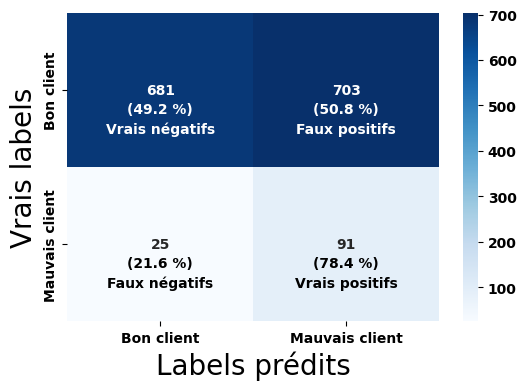


Epoch 1: fbeta_score improved from -inf to 0.00212, saving model to .\model_best_weights.h5


C:\Users\33664\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.




Epoch 2: fbeta_score did not improve from 0.00212

Epoch 3: fbeta_score improved from 0.00212 to 0.00213, saving model to .\model_best_weights.h5

Epoch 4: fbeta_score did not improve from 0.00213

Epoch 5: fbeta_score did not improve from 0.00213

Epoch 6: fbeta_score did not improve from 0.00213

Epoch 7: fbeta_score did not improve from 0.00213

Epoch 8: fbeta_score did not improve from 0.00213
Epoch 8: early stopping
219/219 [==============================] - 0s 1ms/step
adam None 20
47/47 [==============================] - 0s 1ms/step


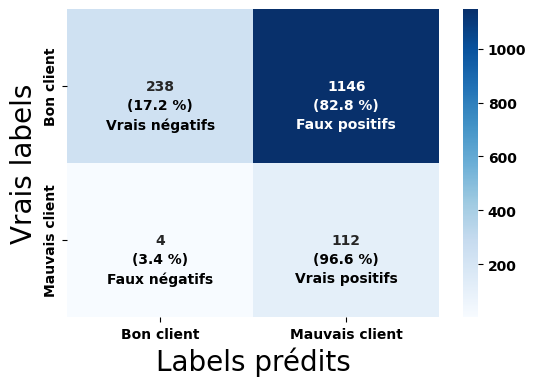


Epoch 1: fbeta_score improved from -inf to 0.01430, saving model to .\model_best_weights.h5


C:\Users\33664\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.




Epoch 2: fbeta_score did not improve from 0.01430

Epoch 3: fbeta_score did not improve from 0.01430

Epoch 4: fbeta_score did not improve from 0.01430

Epoch 5: fbeta_score did not improve from 0.01430

Epoch 6: fbeta_score did not improve from 0.01430
Epoch 6: early stopping
219/219 [==============================] - 0s 1ms/step
adam None 50
47/47 [==============================] - 0s 1ms/step


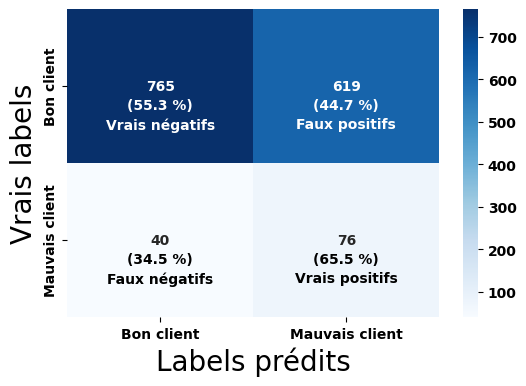


Epoch 1: fbeta_score improved from -inf to 0.00213, saving model to .\model_best_weights.h5


C:\Users\33664\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.




Epoch 2: fbeta_score did not improve from 0.00213

Epoch 3: fbeta_score improved from 0.00213 to 0.00213, saving model to .\model_best_weights.h5

Epoch 4: fbeta_score improved from 0.00213 to 0.00851, saving model to .\model_best_weights.h5

Epoch 5: fbeta_score improved from 0.00851 to 0.02334, saving model to .\model_best_weights.h5

Epoch 6: fbeta_score improved from 0.02334 to 0.03382, saving model to .\model_best_weights.h5

Epoch 7: fbeta_score did not improve from 0.03382

Epoch 8: fbeta_score improved from 0.03382 to 0.05254, saving model to .\model_best_weights.h5

Epoch 9: fbeta_score did not improve from 0.05254

Epoch 10: fbeta_score did not improve from 0.05254

Epoch 11: fbeta_score improved from 0.05254 to 0.05881, saving model to .\model_best_weights.h5

Epoch 12: fbeta_score did not improve from 0.05881

Epoch 13: fbeta_score did not improve from 0.05881

Epoch 14: fbeta_score did not improve from 0.05881

Epoch 15: fbeta_score did not improve from 0.05881

Epoch 16:

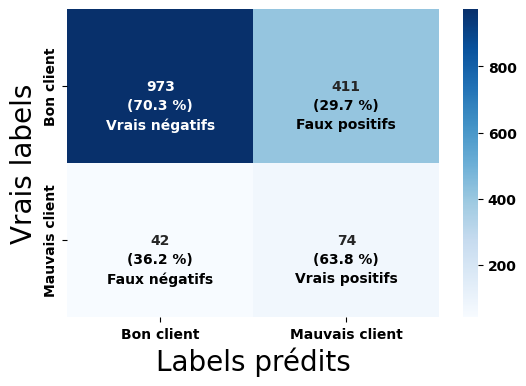


Epoch 1: fbeta_score improved from -inf to 0.00849, saving model to .\model_best_weights.h5


C:\Users\33664\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.




Epoch 2: fbeta_score did not improve from 0.00849

Epoch 3: fbeta_score did not improve from 0.00849

Epoch 4: fbeta_score did not improve from 0.00849

Epoch 5: fbeta_score improved from 0.00849 to 0.01914, saving model to .\model_best_weights.h5

Epoch 6: fbeta_score did not improve from 0.01914

Epoch 7: fbeta_score improved from 0.01914 to 0.03594, saving model to .\model_best_weights.h5

Epoch 8: fbeta_score did not improve from 0.03594

Epoch 9: fbeta_score did not improve from 0.03594

Epoch 10: fbeta_score improved from 0.03594 to 0.04010, saving model to .\model_best_weights.h5

Epoch 11: fbeta_score did not improve from 0.04010

Epoch 12: fbeta_score did not improve from 0.04010

Epoch 13: fbeta_score did not improve from 0.04010

Epoch 14: fbeta_score did not improve from 0.04010

Epoch 15: fbeta_score did not improve from 0.04010
Epoch 15: early stopping
219/219 [==============================] - 0s 1ms/step
adam <keras.src.regularizers.L2 object at 0x0000016D771F7210> 20


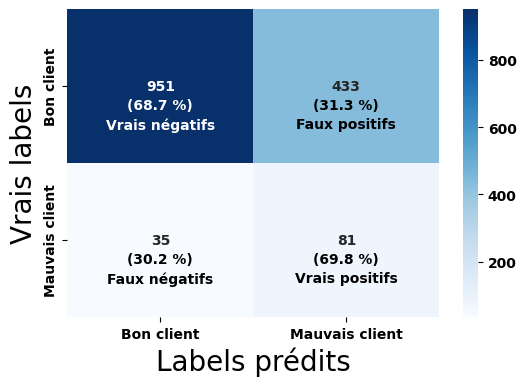


Epoch 1: fbeta_score improved from -inf to 0.01045, saving model to .\model_best_weights.h5


C:\Users\33664\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.




Epoch 2: fbeta_score did not improve from 0.01045

Epoch 3: fbeta_score did not improve from 0.01045

Epoch 4: fbeta_score did not improve from 0.01045

Epoch 5: fbeta_score did not improve from 0.01045

Epoch 6: fbeta_score did not improve from 0.01045
Epoch 6: early stopping
219/219 [==============================] - 0s 1ms/step
adam <keras.src.regularizers.L2 object at 0x0000016D771F7210> 50
47/47 [==============================] - 0s 1ms/step


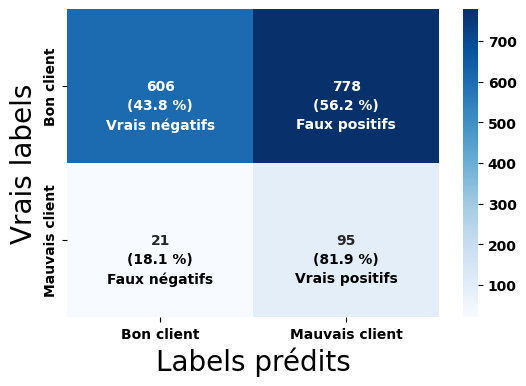

47/47 [==============================] - 0s 1ms/step


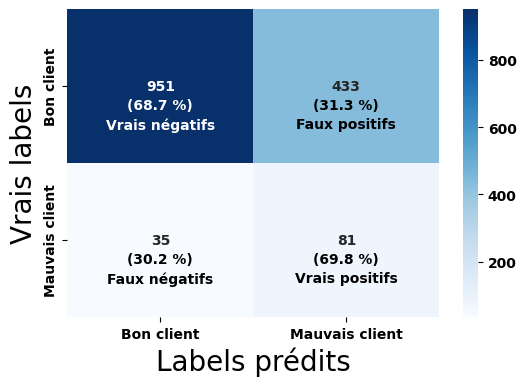

In [965]:
# Fonction retournant une liste de callbacks pour la formation du modèle
def callbacks(path, monitor="auc", patienceStop = 5, patienceReducer = 0):

    # On sauvegarde le modèle quand la valeur augmente de validation est augmentée
    checkpoint = ModelCheckpoint(path, monitor=monitor, verbose=1, save_best_only=True, mode='max')

    # Arrête le modèle s'il n'y a pas d'amélioration au bout de x epoches
    es = EarlyStopping(monitor=monitor, mode='max', verbose=1, patience = patienceStop)

    # Réduit le temps d'apprentissage si le modèle ne s'améliore pas
    lr_reducer = ReduceLROnPlateau(monitor=monitor, factor=0.5, patience = patienceReducer, min_lr=1e-8)

    return [checkpoint, es, lr_reducer]

def build_and_compile_model(normalizer, optimizer='adam', regularization=None, beta = 2.0, th = 0.7):
    model = tf.keras.Sequential([
        normalizer,
        Dense(200, input_shape=(xtrain1.shape[1],), activation='relu',
                              kernel_regularizer=regularization),
        Dropout(0.5),
        Dense(100, activation='relu', kernel_regularizer=regularization),
        Dropout(0.5),
        Dense(50, activation='relu', kernel_regularizer=regularization),
        Dropout(0.5),
        Dense(25, activation='relu', kernel_regularizer=regularization),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=[
                            keras.metrics.TruePositives(name='tp'),
                            keras.metrics.FalsePositives(name='fp'),
                            keras.metrics.TrueNegatives(name='tn'),
                            keras.metrics.FalseNegatives(name='fn'), 
                            keras.metrics.BinaryAccuracy(name='accuracy'),
                            keras.metrics.Precision(name='precision'),
                            keras.metrics.Recall(name='recall'),
                            keras.metrics.AUC(name='auc'),
                            keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
                            F1Score(name='f1_score'),  
                            FBetaScore(name='fbeta_score', beta=beta, threshold=th)
                        ]
                 )
    return model



# Normalize data
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(xtrain1)  # Adapt the normalizer to your training data

best_score = 0

start_time = time.time()
list_score = []
best_auc_test = 0
best_prc_test = 0

# Search for the best parameters
for optimizer_name in ['adam']:
    for regularization in [None, l2(0.01)]:
        for batch_size in [10, 20, 50]:
            if optimizer_name == 'adam':
                optimizer = tf.keras.optimizers.Adam()
            elif optimizer_name == 'rmsprop':
                optimizer = tf.keras.optimizers.RMSprop()  
            else:
                optimizer = tf.keras.optimizers.SGD()

            model_save_path = "./model_best_weights.h5"
            callbacks_list = callbacks(model_save_path, monitor="fbeta_score") 

            model = build_and_compile_model(normalizer, optimizer, regularization, beta, th)
            history = model.fit(xtrain1, 
                                ytrain1,
                                validation_data=(xval1, yval1),
                                callbacks=callbacks_list,
                                epochs=50,
                                batch_size=batch_size,
                                verbose=0,
                                class_weight=class_weight)
            yresult_test = np.round(model.predict(xtest1))
            yresult_train = np.round(model.predict(xtrain1))

            print(optimizer_name, regularization, batch_size)
            #matrice_confusion(ytest1, np.round(model.predict(xtest1)))


            score_test = round(roc_auc_score(ytest1, yresult_test), 2)
            score_train = round(roc_auc_score(ytrain1, yresult_train), 2)


            # Calculate precision and recall
            precision_mean, recall_mean, f1_mean = classification_scores(ytest1, yresult_test)

            list_score.append([optimizer_name, regularization, batch_size, score_train, score_test, recall_mean])

            if score_test > best_auc_test:
                best_auc_test = score_test  
                best_model = model
            #if recall_mean > best_prc_test:
             #   best_prc_test = recall_mean
              #  print(recall_mean)
               # print(regularization, batch_size)
                #best_model = model


            
yresult_test = np.round(best_model.predict(xtest1))

matrice_confusion(ytest1, yresult_test)

In [966]:
list_score

[['adam', None, 10, 0.69, 0.64, 0.64],
 ['adam', None, 20, 0.57, 0.57, 0.57],
 ['adam', None, 50, 0.64, 0.6, 0.6],
 ['adam', <keras.src.regularizers.L2 at 0x16d771f7210>, 10, 0.76, 0.67, 0.67],
 ['adam', <keras.src.regularizers.L2 at 0x16d771f7210>, 20, 0.76, 0.69, 0.69],
 ['adam', <keras.src.regularizers.L2 at 0x16d771f7210>, 50, 0.66, 0.63, 0.63]]

In [586]:
scoring = pd.DataFrame(list_score)

In [587]:
 scoring[3]

0      0.5
1      0.5
2      0.5
3      0.6
4      0.6
      ... 
115    0.8
116    0.8
117    0.9
118    0.9
119    0.9
Name: 3, Length: 120, dtype: float64

In [588]:
for d in scoring[3].unique():
    display(scoring[scoring[3] == d])

0                                                  1    2    3     4  \
0    adam                                               None  1.5  0.5  0.65   
1    adam                                               None  2.0  0.5  0.67   
2    adam                                               None  2.5  0.5  0.60   
15   adam                                               None  1.5  0.5  0.65   
16   adam                                               None  2.0  0.5  0.51   
17   adam                                               None  2.5  0.5  0.67   
30   adam                                               None  1.5  0.5  0.52   
31   adam                                               None  2.0  0.5  0.53   
32   adam                                               None  2.5  0.5  0.52   
45   adam                                               None  1.5  0.5  0.52   
46   adam                                               None  2.0  0.5  0.55   
47   adam                                               None  2.5  0.5  0.52   
60   adam  <keras.src.regularizers.L2 object at 0x0000016...  1.5  0.5  0.75   
61   adam  <keras.src.regularizers.L2 object at 0x0000016...  2.0  0.5  0.76   
62   adam  <keras.src.regularizers.L2 object at 0x0000016...  2.5  0.5  0.76   
75   adam  <keras.src.regularizers.L2 object at 0x0000016...  1.5  0.5  0.74   
76   adam  <keras.src.regularizers.L2 object at 0x0000016...  2.0  0.5  0.73   
77   adam  <keras.src.regularizers.L2 object at 0x0000016...  2.5  0.5  0.72   
90   adam  <keras.src.regularizers.L2 object at 0x0000016...  1.5  0.5  0.64   
91   adam  <keras.src.regularizers.L2 object at 0x0000016...  2.0  0.5  0.53   
92   adam  <keras.src.regularizers.L2 object at 0x0000016...  2.5  0.5  0.51   
105  adam  <keras.src.regularizers.L2 object at 0x0000016...  1.5  0.5  0.53   
106  adam  <keras.src.regularizers.L2 object at 0x0000016...  2.0  0.5  0.51   
107  adam  <keras.src.regularizers.L2 object at 0x0000016...  2.5  0.5  0.54   

        5     6  
0    0.63  0.63  
1    0.62  0.62  
2    0.59  0.59  
15   0.62  0.62  
16   0.50  0.50  
17   0.64  0.64  
30   0.51  0.51  
31   0.51  0.51  
32   0.52  0.52  
45   0.51  0.51  
46   0.54  0.54  
47   0.51  0.51  
60   0.68  0.68  
61   0.65  0.65  
62   0.67  0.67  
75   0.67  0.67  
76   0.65  0.65  
77   0.67  0.67  
90   0.60  0.60  
91   0.53  0.53  
92   0.51  0.51  
105  0.53  0.53  
106  0.52  0.52  
107  0.52  0.52

0                                                  1    2    3     4  \
3    adam                                               None  1.5  0.6  0.65   
4    adam                                               None  2.0  0.6  0.67   
5    adam                                               None  2.5  0.6  0.70   
18   adam                                               None  1.5  0.6  0.69   
19   adam                                               None  2.0  0.6  0.65   
20   adam                                               None  2.5  0.6  0.65   
33   adam                                               None  1.5  0.6  0.55   
34   adam                                               None  2.0  0.6  0.59   
35   adam                                               None  2.5  0.6  0.56   
48   adam                                               None  1.5  0.6  0.54   
49   adam                                               None  2.0  0.6  0.54   
50   adam                                               None  2.5  0.6  0.62   
63   adam  <keras.src.regularizers.L2 object at 0x0000016...  1.5  0.6  0.75   
64   adam  <keras.src.regularizers.L2 object at 0x0000016...  2.0  0.6  0.77   
65   adam  <keras.src.regularizers.L2 object at 0x0000016...  2.5  0.6  0.75   
78   adam  <keras.src.regularizers.L2 object at 0x0000016...  1.5  0.6  0.76   
79   adam  <keras.src.regularizers.L2 object at 0x0000016...  2.0  0.6  0.76   
80   adam  <keras.src.regularizers.L2 object at 0x0000016...  2.5  0.6  0.76   
93   adam  <keras.src.regularizers.L2 object at 0x0000016...  1.5  0.6  0.71   
94   adam  <keras.src.regularizers.L2 object at 0x0000016...  2.0  0.6  0.68   
95   adam  <keras.src.regularizers.L2 object at 0x0000016...  2.5  0.6  0.67   
108  adam  <keras.src.regularizers.L2 object at 0x0000016...  1.5  0.6  0.63   
109  adam  <keras.src.regularizers.L2 object at 0x0000016...  2.0  0.6  0.59   
110  adam  <keras.src.regularizers.L2 object at 0x0000016...  2.5  0.6  0.65   

        5     6  
3    0.61  0.61  
4    0.63  0.63  
5    0.65  0.65  
18   0.61  0.61  
19   0.63  0.63  
20   0.62  0.62  
33   0.53  0.53  
34   0.56  0.56  
35   0.53  0.53  
48   0.54  0.54  
49   0.54  0.54  
50   0.54  0.54  
63   0.67  0.67  
64   0.68  0.68  
65   0.67  0.67  
78   0.68  0.68  
79   0.68  0.68  
80   0.68  0.68  
93   0.67  0.67  
94   0.65  0.65  
95   0.65  0.65  
108  0.59  0.59  
109  0.53  0.53  
110  0.64  0.64

0                                                  1    2    3     4  \
6    adam                                               None  1.5  0.7  0.71   
7    adam                                               None  2.0  0.7  0.69   
8    adam                                               None  2.5  0.7  0.69   
21   adam                                               None  1.5  0.7  0.70   
22   adam                                               None  2.0  0.7  0.68   
23   adam                                               None  2.5  0.7  0.67   
36   adam                                               None  1.5  0.7  0.59   
37   adam                                               None  2.0  0.7  0.51   
38   adam                                               None  2.5  0.7  0.53   
51   adam                                               None  1.5  0.7  0.54   
52   adam                                               None  2.0  0.7  0.62   
53   adam                                               None  2.5  0.7  0.53   
66   adam  <keras.src.regularizers.L2 object at 0x0000016...  1.5  0.7  0.77   
67   adam  <keras.src.regularizers.L2 object at 0x0000016...  2.0  0.7  0.76   
68   adam  <keras.src.regularizers.L2 object at 0x0000016...  2.5  0.7  0.77   
81   adam  <keras.src.regularizers.L2 object at 0x0000016...  1.5  0.7  0.77   
82   adam  <keras.src.regularizers.L2 object at 0x0000016...  2.0  0.7  0.75   
83   adam  <keras.src.regularizers.L2 object at 0x0000016...  2.5  0.7  0.76   
96   adam  <keras.src.regularizers.L2 object at 0x0000016...  1.5  0.7  0.68   
97   adam  <keras.src.regularizers.L2 object at 0x0000016...  2.0  0.7  0.68   
98   adam  <keras.src.regularizers.L2 object at 0x0000016...  2.5  0.7  0.68   
111  adam  <keras.src.regularizers.L2 object at 0x0000016...  1.5  0.7  0.59   
112  adam  <keras.src.regularizers.L2 object at 0x0000016...  2.0  0.7  0.68   
113  adam  <keras.src.regularizers.L2 object at 0x0000016...  2.5  0.7  0.52   

        5     6  
6    0.67  0.67  
7    0.63  0.63  
8    0.65  0.65  
21   0.64  0.64  
22   0.63  0.63  
23   0.63  0.63  
36   0.59  0.59  
37   0.50  0.50  
38   0.51  0.51  
51   0.53  0.53  
52   0.57  0.57  
53   0.49  0.49  
66   0.68  0.68  
67   0.68  0.68  
68   0.67  0.67  
81   0.66  0.66  
82   0.67  0.67  
83   0.68  0.68  
96   0.64  0.64  
97   0.66  0.66  
98   0.65  0.65  
111  0.58  0.58  
112  0.66  0.66  
113  0.51  0.51

0                                                  1    2    3     4  \
9    adam                                               None  1.5  0.8  0.69   
10   adam                                               None  2.0  0.8  0.70   
11   adam                                               None  2.5  0.8  0.72   
24   adam                                               None  1.5  0.8  0.68   
25   adam                                               None  2.0  0.8  0.67   
26   adam                                               None  2.5  0.8  0.72   
39   adam                                               None  1.5  0.8  0.63   
40   adam                                               None  2.0  0.8  0.57   
41   adam                                               None  2.5  0.8  0.57   
54   adam                                               None  1.5  0.8  0.58   
55   adam                                               None  2.0  0.8  0.53   
56   adam                                               None  2.5  0.8  0.58   
69   adam  <keras.src.regularizers.L2 object at 0x0000016...  1.5  0.8  0.76   
70   adam  <keras.src.regularizers.L2 object at 0x0000016...  2.0  0.8  0.76   
71   adam  <keras.src.regularizers.L2 object at 0x0000016...  2.5  0.8  0.76   
84   adam  <keras.src.regularizers.L2 object at 0x0000016...  1.5  0.8  0.76   
85   adam  <keras.src.regularizers.L2 object at 0x0000016...  2.0  0.8  0.75   
86   adam  <keras.src.regularizers.L2 object at 0x0000016...  2.5  0.8  0.74   
99   adam  <keras.src.regularizers.L2 object at 0x0000016...  1.5  0.8  0.51   
100  adam  <keras.src.regularizers.L2 object at 0x0000016...  2.0  0.8  0.53   
101  adam  <keras.src.regularizers.L2 object at 0x0000016...  2.5  0.8  0.60   
114  adam  <keras.src.regularizers.L2 object at 0x0000016...  1.5  0.8  0.66   
115  adam  <keras.src.regularizers.L2 object at 0x0000016...  2.0  0.8  0.57   
116  adam  <keras.src.regularizers.L2 object at 0x0000016...  2.5  0.8  0.63   

        5     6  
9    0.63  0.63  
10   0.64  0.64  
11   0.64  0.64  
24   0.62  0.62  
25   0.63  0.63  
26   0.64  0.64  
39   0.55  0.55  
40   0.55  0.55  
41   0.56  0.56  
54   0.59  0.59  
55   0.51  0.51  
56   0.54  0.54  
69   0.68  0.68  
70   0.68  0.68  
71   0.66  0.66  
84   0.67  0.67  
85   0.67  0.67  
86   0.68  0.68  
99   0.51  0.51  
100  0.52  0.52  
101  0.60  0.60  
114  0.63  0.63  
115  0.54  0.54  
116  0.64  0.64

0                                                  1    2    3     4  \
12   adam                                               None  1.5  0.9  0.69   
13   adam                                               None  2.0  0.9  0.58   
14   adam                                               None  2.5  0.9  0.68   
27   adam                                               None  1.5  0.9  0.65   
28   adam                                               None  2.0  0.9  0.68   
29   adam                                               None  2.5  0.9  0.63   
42   adam                                               None  1.5  0.9  0.54   
43   adam                                               None  2.0  0.9  0.56   
44   adam                                               None  2.5  0.9  0.61   
57   adam                                               None  1.5  0.9  0.51   
58   adam                                               None  2.0  0.9  0.59   
59   adam                                               None  2.5  0.9  0.54   
72   adam  <keras.src.regularizers.L2 object at 0x0000016...  1.5  0.9  0.76   
73   adam  <keras.src.regularizers.L2 object at 0x0000016...  2.0  0.9  0.76   
74   adam  <keras.src.regularizers.L2 object at 0x0000016...  2.5  0.9  0.75   
87   adam  <keras.src.regularizers.L2 object at 0x0000016...  1.5  0.9  0.76   
88   adam  <keras.src.regularizers.L2 object at 0x0000016...  2.0  0.9  0.76   
89   adam  <keras.src.regularizers.L2 object at 0x0000016...  2.5  0.9  0.76   
102  adam  <keras.src.regularizers.L2 object at 0x0000016...  1.5  0.9  0.67   
103  adam  <keras.src.regularizers.L2 object at 0x0000016...  2.0  0.9  0.58   
104  adam  <keras.src.regularizers.L2 object at 0x0000016...  2.5  0.9  0.50   
117  adam  <keras.src.regularizers.L2 object at 0x0000016...  1.5  0.9  0.65   
118  adam  <keras.src.regularizers.L2 object at 0x0000016...  2.0  0.9  0.62   
119  adam  <keras.src.regularizers.L2 object at 0x0000016...  2.5  0.9  0.65   

        5     6  
12   0.66  0.66  
13   0.58  0.58  
14   0.64  0.64  
27   0.64  0.64  
28   0.65  0.65  
29   0.61  0.61  
42   0.55  0.55  
43   0.53  0.53  
44   0.62  0.62  
57   0.52  0.52  
58   0.60  0.60  
59   0.50  0.50  
72   0.68  0.68  
73   0.67  0.67  
74   0.67  0.67  
87   0.66  0.66  
88   0.67  0.67  
89   0.68  0.68  
102  0.65  0.65  
103  0.58  0.58  
104  0.50  0.50  
117  0.62  0.62  
118  0.56  0.56  
119  0.60  0.60

In [578]:
list_score

[['adam', None, 0.7, 0.63, 0.63],
 ['adam', None, 0.55, 0.54, 0.54],
 ['adam', None, 0.58, 0.55, 0.55],
 ['adam', <keras.src.regularizers.L2 at 0x16d8195add0>, 0.75, 0.67, 0.67],
 ['adam', <keras.src.regularizers.L2 at 0x16d8195add0>, 0.68, 0.66, 0.66],
 ['adam', <keras.src.regularizers.L2 at 0x16d8195add0>, 0.65, 0.61, 0.61]]

In [211]:
x_pipe_train = pipe.fit_transform(xtrain1, ytrain1)
x_pipe_test = pipe.transform(xtest1)
x_pipe_val = pipe.transform(xval1)


Epoch 1: val_auc improved from -inf to 0.58197, saving model to .\model_best_weights.h5


C:\Users\33664\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.




Epoch 2: val_auc improved from 0.58197 to 0.63815, saving model to .\model_best_weights.h5

Epoch 3: val_auc improved from 0.63815 to 0.66873, saving model to .\model_best_weights.h5

Epoch 4: val_auc improved from 0.66873 to 0.68466, saving model to .\model_best_weights.h5

Epoch 5: val_auc did not improve from 0.68466

Epoch 6: val_auc improved from 0.68466 to 0.68938, saving model to .\model_best_weights.h5

Epoch 7: val_auc improved from 0.68938 to 0.69270, saving model to .\model_best_weights.h5

Epoch 8: val_auc did not improve from 0.69270

Epoch 9: val_auc did not improve from 0.69270

Epoch 10: val_auc did not improve from 0.69270

Epoch 11: val_auc did not improve from 0.69270

Epoch 12: val_auc improved from 0.69270 to 0.69510, saving model to .\model_best_weights.h5

Epoch 13: val_auc did not improve from 0.69510

Epoch 14: val_auc improved from 0.69510 to 0.69867, saving model to .\model_best_weights.h5

Epoch 15: val_auc did not improve from 0.69867

Epoch 16: val_auc di

C:\Users\33664\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.




Epoch 2: val_auc improved from 0.55294 to 0.66909, saving model to .\model_best_weights.h5

Epoch 3: val_auc did not improve from 0.66909

Epoch 4: val_auc improved from 0.66909 to 0.67963, saving model to .\model_best_weights.h5

Epoch 5: val_auc did not improve from 0.67963

Epoch 6: val_auc did not improve from 0.67963

Epoch 7: val_auc did not improve from 0.67963

Epoch 8: val_auc did not improve from 0.67963

Epoch 9: val_auc improved from 0.67963 to 0.68594, saving model to .\model_best_weights.h5

Epoch 10: val_auc improved from 0.68594 to 0.68906, saving model to .\model_best_weights.h5

Epoch 11: val_auc did not improve from 0.68906

Epoch 12: val_auc did not improve from 0.68906

Epoch 13: val_auc did not improve from 0.68906

Epoch 14: val_auc did not improve from 0.68906

Epoch 15: val_auc did not improve from 0.68906
Epoch 15: early stopping
219/219 [==============================] - 0s 909us/step

Epoch 1: val_auc improved from -inf to 0.56778, saving model to .\model_b

C:\Users\33664\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.




Epoch 2: val_auc improved from 0.56778 to 0.63890, saving model to .\model_best_weights.h5

Epoch 3: val_auc did not improve from 0.63890

Epoch 4: val_auc did not improve from 0.63890

Epoch 5: val_auc did not improve from 0.63890

Epoch 6: val_auc did not improve from 0.63890

Epoch 7: val_auc improved from 0.63890 to 0.66743, saving model to .\model_best_weights.h5

Epoch 8: val_auc did not improve from 0.66743

Epoch 9: val_auc did not improve from 0.66743

Epoch 10: val_auc did not improve from 0.66743

Epoch 11: val_auc did not improve from 0.66743

Epoch 12: val_auc did not improve from 0.66743
Epoch 12: early stopping
219/219 [==============================] - 0s 891us/step

Epoch 1: val_auc improved from -inf to 0.57819, saving model to .\model_best_weights.h5


C:\Users\33664\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.




Epoch 2: val_auc improved from 0.57819 to 0.63669, saving model to .\model_best_weights.h5

Epoch 3: val_auc improved from 0.63669 to 0.64226, saving model to .\model_best_weights.h5

Epoch 4: val_auc did not improve from 0.64226

Epoch 5: val_auc improved from 0.64226 to 0.64302, saving model to .\model_best_weights.h5

Epoch 6: val_auc did not improve from 0.64302

Epoch 7: val_auc did not improve from 0.64302

Epoch 8: val_auc did not improve from 0.64302

Epoch 9: val_auc improved from 0.64302 to 0.64339, saving model to .\model_best_weights.h5

Epoch 10: val_auc did not improve from 0.64339

Epoch 11: val_auc did not improve from 0.64339

Epoch 12: val_auc did not improve from 0.64339

Epoch 13: val_auc did not improve from 0.64339

Epoch 14: val_auc did not improve from 0.64339
Epoch 14: early stopping
219/219 [==============================] - 0s 886us/step

Epoch 1: val_auc improved from -inf to 0.57824, saving model to .\model_best_weights.h5


C:\Users\33664\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.




Epoch 2: val_auc improved from 0.57824 to 0.62430, saving model to .\model_best_weights.h5

Epoch 3: val_auc improved from 0.62430 to 0.66254, saving model to .\model_best_weights.h5

Epoch 4: val_auc did not improve from 0.66254

Epoch 5: val_auc improved from 0.66254 to 0.68481, saving model to .\model_best_weights.h5

Epoch 6: val_auc did not improve from 0.68481

Epoch 7: val_auc did not improve from 0.68481

Epoch 8: val_auc did not improve from 0.68481

Epoch 9: val_auc did not improve from 0.68481

Epoch 10: val_auc did not improve from 0.68481
Epoch 10: early stopping
219/219 [==============================] - 0s 941us/step

Epoch 1: val_auc improved from -inf to 0.59133, saving model to .\model_best_weights.h5


C:\Users\33664\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.




Epoch 2: val_auc improved from 0.59133 to 0.64803, saving model to .\model_best_weights.h5

Epoch 3: val_auc improved from 0.64803 to 0.66986, saving model to .\model_best_weights.h5

Epoch 4: val_auc did not improve from 0.66986

Epoch 5: val_auc did not improve from 0.66986

Epoch 6: val_auc did not improve from 0.66986

Epoch 7: val_auc did not improve from 0.66986

Epoch 8: val_auc improved from 0.66986 to 0.67141, saving model to .\model_best_weights.h5

Epoch 9: val_auc did not improve from 0.67141

Epoch 10: val_auc improved from 0.67141 to 0.67551, saving model to .\model_best_weights.h5

Epoch 11: val_auc did not improve from 0.67551

Epoch 12: val_auc did not improve from 0.67551

Epoch 13: val_auc did not improve from 0.67551

Epoch 14: val_auc did not improve from 0.67551

Epoch 15: val_auc did not improve from 0.67551
Epoch 15: early stopping
219/219 [==============================] - 0s 918us/step

Epoch 1: val_auc improved from -inf to 0.57979, saving model to .\model_b

C:\Users\33664\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.




Epoch 2: val_auc improved from 0.57979 to 0.64984, saving model to .\model_best_weights.h5

Epoch 3: val_auc did not improve from 0.64984

Epoch 4: val_auc improved from 0.64984 to 0.67317, saving model to .\model_best_weights.h5

Epoch 5: val_auc improved from 0.67317 to 0.67705, saving model to .\model_best_weights.h5

Epoch 6: val_auc did not improve from 0.67705

Epoch 7: val_auc did not improve from 0.67705

Epoch 8: val_auc did not improve from 0.67705

Epoch 9: val_auc did not improve from 0.67705

Epoch 10: val_auc did not improve from 0.67705
Epoch 10: early stopping
219/219 [==============================] - 0s 1ms/step

Epoch 1: val_auc improved from -inf to 0.57815, saving model to .\model_best_weights.h5


C:\Users\33664\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.




Epoch 2: val_auc improved from 0.57815 to 0.64260, saving model to .\model_best_weights.h5

Epoch 3: val_auc improved from 0.64260 to 0.65036, saving model to .\model_best_weights.h5

Epoch 4: val_auc improved from 0.65036 to 0.65740, saving model to .\model_best_weights.h5

Epoch 5: val_auc improved from 0.65740 to 0.66537, saving model to .\model_best_weights.h5

Epoch 6: val_auc improved from 0.66537 to 0.67699, saving model to .\model_best_weights.h5

Epoch 7: val_auc improved from 0.67699 to 0.68323, saving model to .\model_best_weights.h5

Epoch 8: val_auc did not improve from 0.68323

Epoch 9: val_auc did not improve from 0.68323

Epoch 10: val_auc did not improve from 0.68323

Epoch 11: val_auc did not improve from 0.68323

Epoch 12: val_auc did not improve from 0.68323
Epoch 12: early stopping
219/219 [==============================] - 0s 1ms/step

Epoch 1: val_auc improved from -inf to 0.49177, saving model to .\model_best_weights.h5


C:\Users\33664\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.




Epoch 2: val_auc improved from 0.49177 to 0.53513, saving model to .\model_best_weights.h5

Epoch 3: val_auc improved from 0.53513 to 0.55648, saving model to .\model_best_weights.h5

Epoch 4: val_auc improved from 0.55648 to 0.56811, saving model to .\model_best_weights.h5

Epoch 5: val_auc did not improve from 0.56811

Epoch 6: val_auc improved from 0.56811 to 0.57184, saving model to .\model_best_weights.h5

Epoch 7: val_auc did not improve from 0.57184

Epoch 8: val_auc improved from 0.57184 to 0.57782, saving model to .\model_best_weights.h5

Epoch 9: val_auc did not improve from 0.57782

Epoch 10: val_auc improved from 0.57782 to 0.58574, saving model to .\model_best_weights.h5

Epoch 11: val_auc did not improve from 0.58574

Epoch 12: val_auc improved from 0.58574 to 0.59239, saving model to .\model_best_weights.h5

Epoch 13: val_auc did not improve from 0.59239

Epoch 14: val_auc did not improve from 0.59239

Epoch 15: val_auc did not improve from 0.59239

Epoch 16: val_auc di

C:\Users\33664\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.




Epoch 2: val_auc improved from 0.51231 to 0.52133, saving model to .\model_best_weights.h5

Epoch 3: val_auc improved from 0.52133 to 0.54220, saving model to .\model_best_weights.h5

Epoch 4: val_auc did not improve from 0.54220

Epoch 5: val_auc improved from 0.54220 to 0.57305, saving model to .\model_best_weights.h5

Epoch 6: val_auc improved from 0.57305 to 0.58686, saving model to .\model_best_weights.h5

Epoch 7: val_auc did not improve from 0.58686

Epoch 8: val_auc did not improve from 0.58686

Epoch 9: val_auc did not improve from 0.58686

Epoch 10: val_auc improved from 0.58686 to 0.60136, saving model to .\model_best_weights.h5

Epoch 11: val_auc did not improve from 0.60136

Epoch 12: val_auc did not improve from 0.60136

Epoch 13: val_auc did not improve from 0.60136

Epoch 14: val_auc did not improve from 0.60136

Epoch 15: val_auc did not improve from 0.60136
Epoch 15: early stopping
219/219 [==============================] - 0s 1ms/step

Epoch 1: val_auc improved from

C:\Users\33664\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.




Epoch 2: val_auc improved from 0.49836 to 0.52035, saving model to .\model_best_weights.h5

Epoch 3: val_auc improved from 0.52035 to 0.54521, saving model to .\model_best_weights.h5

Epoch 4: val_auc improved from 0.54521 to 0.57038, saving model to .\model_best_weights.h5

Epoch 5: val_auc did not improve from 0.57038

Epoch 6: val_auc improved from 0.57038 to 0.57373, saving model to .\model_best_weights.h5

Epoch 7: val_auc did not improve from 0.57373

Epoch 8: val_auc did not improve from 0.57373

Epoch 9: val_auc did not improve from 0.57373

Epoch 10: val_auc did not improve from 0.57373

Epoch 11: val_auc did not improve from 0.57373
Epoch 11: early stopping
219/219 [==============================] - 0s 992us/step

Epoch 1: val_auc improved from -inf to 0.53549, saving model to .\model_best_weights.h5


C:\Users\33664\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.




Epoch 2: val_auc improved from 0.53549 to 0.55474, saving model to .\model_best_weights.h5

Epoch 3: val_auc improved from 0.55474 to 0.56676, saving model to .\model_best_weights.h5

Epoch 4: val_auc improved from 0.56676 to 0.58050, saving model to .\model_best_weights.h5

Epoch 5: val_auc improved from 0.58050 to 0.59735, saving model to .\model_best_weights.h5

Epoch 6: val_auc did not improve from 0.59735

Epoch 7: val_auc did not improve from 0.59735

Epoch 8: val_auc did not improve from 0.59735

Epoch 9: val_auc did not improve from 0.59735

Epoch 10: val_auc did not improve from 0.59735
Epoch 10: early stopping
47/47 [==============================] - 0s 1ms/step


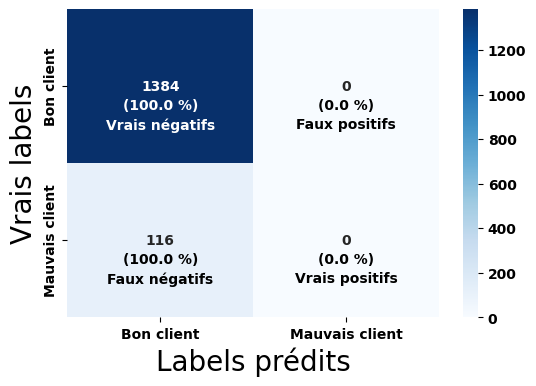

In [235]:


best_score = 0

start_time = time.time()
list_score = []
best_auc_test = 0
best_prc_test = 0

# Search for the best parameters
for optimizer_name in ['adam', 'rmsprop', 'sgd']:
    for regularization in [None, l2(0.01)]:
        for scaler in [None, StandardScaler()]:
            if optimizer_name == 'adam':
                optimizer = tf.keras.optimizers.Adam()
            elif optimizer_name == 'rmsprop':
                optimizer = tf.keras.optimizers.RMSprop()  
            else:
                optimizer = tf.keras.optimizers.SGD()

            pipe = Pipeline([
                    ('imputer', SimpleImputer(strategy='median')),
                    ('feature_elimination', VarianceThreshold(threshold=0.0)),
                    ('feature_selection', SelectKBest(score_func=f_classif, k = 10)),
                    ('scaler', scaler),
                ])
            x_pipe_train = pipe.fit_transform(xtrain1, ytrain1)
            x_pipe_test = pipe.transform(xtest1)
            x_pipe_val = pipe.transform(xval1)
            # Normalize data
            normalizer = tf.keras.layers.Normalization(axis=-1)
            normalizer.adapt(x_pipe_train)  # Adapt the normalizer to your training data

            model_save_path = "./model_best_weights.h5"
            callbacks_list = callbacks(model_save_path, monitor="val_auc")

            model = build_and_compile_model(normalizer, optimizer, regularization)
            history = model.fit(x_pipe_train, 
                                ytrain1,
                                validation_data=(x_pipe_val, yval1),
                                callbacks=callbacks_list,
                                epochs=50,
                                batch_size=20,
                                class_weight=class_weight,
                                verbose=0)
            yresult_test = model.predict(x_pipe_test)
            yresult_train = model.predict(x_pipe_train)

            score_test = round(roc_auc_score(ytest1, yresult_test), 2)
            score_train = round(roc_auc_score(ytrain1, yresult_train), 2)
            
            
            # Calculate precision and recall
            precision_mean, recall_mean, f1_mean = classification_scores(ytest1, yresult_test)

            # Calculate area under the precision-recall curve
            prc_auc = auc(recall, precision)

            list_score.append([optimizer_name, regularization, scaler, score_train, score_test, prc_auc])
            #print([score_train, score_test])

            #if score_test > best_auc_test:
             #   best_model = model
            if prc_auc > best_prc_test:
                best_model = model

            
yresult_test = np.argmax(best_model.predict(x_pipe_test), axis=1)

matrice_confusion(ytest1, yresult_test)

In [48]:
stop


NameError: name 'stop' is not defined

In [582]:
neg, pos = np.bincount(ytrain1)

In [500]:
total = neg + pos
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.54
Weight for class 1: 6.45


In [ ]:
# Identify columns with unique values
unique_columns = [col for col in data.columns if data[col].nunique() == data.shape[0]]

# Print the columns with unique values
print("Columns with unique values:", unique_columns)

In [ ]:

X = data.drop("TARGET", axis = 1)
Y = data["TARGET"]
imputer = SimpleImputer(strategy='median')

# On fit l'imputer et on transforme avec les valeurs imputées
X = imputer.fit_transform(X)

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load or prepare your dataset (X: features, y: target)
# X, y = load_dataset()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialize the SelectKBest feature selector using ANOVA
num_features_to_select = 30  # You can choose the number of top features to select
selector = SelectKBest(score_func=f_classif, k=num_features_to_select)

# Fit the selector to the training data and transform the features
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Initialize and train a model (e.g., Logistic Regression) using the selected features
model = LogisticRegression()
model.fit(X_train_selected, y_train)

# Predict using the model and evaluate its performance
y_pred = model.predict(X_test_selected)
y_pred_prob = model.predict_proba(X_test_selected)[:, 1]
roc_auc_test = round(roc_auc_score(y_test, y_pred_prob), 2)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("roc_auc_test:", roc_auc_test)


In [ ]:

    y_pred_prob_train = best_param_pipe.predict_proba(x_train)[:, 1]
    y_pred_prob_test = best_param_pipe.predict_proba(x_test)[:, 1]
    
    # On prédit les labels
    y_pred_train = best_param_pipe.predict(x_train)
    y_pred_test = best_param_pipe.predict(x_test)
    
    # On calcul le score de performance
    score_performance_train = my_custom_score_func(y_train, y_pred_train)
    score_performance_test = my_custom_score_func(y_test, y_pred_test)
    
    # On calcul le score roc auc
    roc_auc_train = round(roc_auc_score(y_train, y_pred_prob_train), 2)

In [ ]:
#Partie test/debug

In [ ]:
# Ancienne version avant d'ajouter SimpleImputer dans le pipeline
# On garde pour debuggage

# On impute les valeurs manquantes par la médiane
imputer = SimpleImputer(strategy='median')

# On fit l'imputer et on transforme avec les valeurs imputées
xtrain_median = imputer.fit_transform(xtrain)
xtest_median = imputer.transform(xtest)

# On retransforme en DataFrame pour avoir l'information sur les colonnes
xtrain_median = pd.DataFrame(xtrain_median, columns = xtrain.columns)
xtest_median = pd.DataFrame(xtest_median, columns = xtest.columns)

In [ ]:
param_grid_search = {
    "scaler" : [None, StandardScaler(), RobustScaler()],
                    }

# On instancie le modèle
modele_XGB = XGBClassifier(random_state = 42)



In [ ]:
from imblearn.pipeline import Pipeline
param_grid_search = {
    "scaler" : [None, StandardScaler(), RobustScaler()],
}

# On instancie le modèle
modele_XGB = XGBClassifier(random_state = 42)

pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', None),
        ('model', modele_XGB)
    ])

    # On utilise notre scorer, on veut maximiser le score
my_scorer = make_scorer(my_custom_score_func, greater_is_better=True)
    
    # On veut suivre plusieurs scores
scorers = {
    "custom_score" : my_scorer,
    "roc_auc" : "roc_auc"
    }
grid = GridSearchCV(pipe, param_grid_search, cv = 5, scoring = scorers, refit = "custom_score", verbose = 2)

# On fit sur les données d'entrainement
grid.fit(xtrain, ytrain)

# On récupère les meilleurs paramètres 
best_param_pipe = grid.best_estimator_

# On fit sur les données
best_param_pipe.fit(xtrain, ytrain)



In [ ]:
pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', None),
        ('model', modele_XGB)
    ])

    # On utilise notre scorer, on veut maximiser le score
my_scorer = make_scorer(my_custom_score_func, greater_is_better=True)
    
    # On veut suivre plusieurs scores
scorers = {
    "custom_score" : my_scorer,
    "roc_auc" : "roc_auc"
    }
grid = GridSearchCV(pipe, param_grid_search, cv = 5, scoring = scorers, refit = "custom_score", verbose = 2)

# On fit sur les données d'entrainement
grid.fit(xtrain, ytrain)

# On récupère les meilleurs paramètres 
best_param_pipe = grid.best_estimator_

# On fit sur les données
best_param_pipe.fit(xtrain, ytrain)

In [ ]:
## DEBUG ##
## TEST focntionnalitées ##

# On recherche les meilleurs hyperparamètres
param_grid_search = {
                "imputer" : [SimpleImputer(strategy='median')],
                "scaler" : [None, StandardScaler(), RobustScaler()]}

# On instancie le modèle
rfc = LogisticRegression()
#rfc = XGBClassifier()

# On ajoute en plus du nom du classifier
name = "LogisticRegression"

# On récupère les résultats après application de la fonction search_model_params
results = search_model_params(name, rfc, param_grid_search, xtrain, ytrain, xtest, ytest, "Reggresion")

In [ ]:
results

In [ ]:
## DEBUG ##
## TEST focntionnalitées ##

# On recherche les meilleurs hyperparamètres
param_grid_search = {
                "imputer" : [SimpleImputer(strategy='median')],
                "scaler" : [None, StandardScaler(), RobustScaler()]}

# On instancie le modèle
rfc = RandomForestClassifier()
rfc = XGBClassifier()
for rfc, aaa in zip([RandomForestClassifier(), XGBClassifier(), KNeighborsClassifier()], ["DecisionTree", "DecisionTree", "kernel"]):
    # On ajoute en plus du nom du classifier
    name = "RandomForestClassifier"

    # On récupère les résultats après application de la fonction search_model_params
    results = search_model_params(name, rfc, param_grid_search, xtrain, ytrain, xtest, ytest, aaa)